<a id='top'></a>

# Customer segmentation using K-Means clustering
<em>Completed by Geovanna Meier</em>
***

<p>This mini-project is based on the <a href = 'http://blog.yhat.com/posts/customer-segmentation-using-python.html'> Customer segmentation blog post</a> from the Yhat Blog.</p>
<p>The objective of this analysis is to use use clustering algorithms to find similarities among the successful campaign outcomes and form groups of customers. The idea is to detect patterns that may help target marketing campaigns for each group.</p>
<p><b><em>Language:</em></b> Python</p>
<p><b><em>Skills:</em></b> EDA, Unsupervised ML, K-Means Clustering</p>
<p><b><em>Libraries:</em></b> Pandas, NumPy, Matplotlib, Seaborn, Scikit-learn.</p>
***  

# Table of contents
* [Set up environment](#setup)
* [Data](#data)
* [Data wrangling](#dw)
* [EDA](#eda)
* [K-Means clustering](#km)
    * [Choosing K - Elbow method](#elbow)
    * [Choosing K - Silhouette method](#sm)
* [Visualizing clusters using PCA](#pca)
* [Feature reduction with PCA](#pca2)
* [EDA with clusters](#edaclusters)
    * [Most popular variety by cluster](#mpc)
    * [Campaign month by clusters](#cmc)
    * [Cluster 1](#cluster1)
* [K-Means clustering results](#kmc)
* [PCA 'optimal' dimensions](#pcaoptimal)
* [Other clustering algorithms](#oca)
    * [Affinity propagation](#afp)
    * [Spectral clustering](#sc)
    * [Agglomerative clustering](#aclustering)
    * [DBSCAN](#db) 
* [Conclusions](#conclusion)

<a id='setup'></a>

# Set up environment

In [1]:
# Show warning only the first time the cell is run
import warnings
warnings.filterwarnings('ignore')

# pretty print all cell's output and not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# 'double resolution plot output for Retina screens'
%config InlineBackend.figure_format = 'retina'

In [2]:
# import modules
import numpy as np
import pandas as pd
# Setup Pandas
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
#pd.set_option('display.notebook_repr_html', True)

In [3]:
# import visualization modules

import matplotlib.pyplot as plt
_=plt.rcParams['figure.figsize'] = [18,8]
_=plt.rcParams['axes.xmargin'] = 0.7
_=plt.style.use(['fivethirtyeight'])
#_=plt.style.use(['dark_background']) # enable to see plots when using JupyterLab Dark Theme for each graph
import seaborn as sns
_=sns.set_style("dark")
_=sns.set_context("talk", font_scale=1.4, rc={"lines.linewidth": 4})

In [4]:
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

<a id='data'></a>

# Wine marketing campaign data
<p>The data come from two Excel worksheets with the details and outcome of a wine marketing campaign.</p>
<p>The first dataset contains transactional data with the campaign identification number and customer name. The second dataset contains the details of the marketing campaign, including the identification number, the month the campaign was available, the wine's varietal, the minimum quantity, the discount, the wine's country of origin. and whether the wine was past peak.</p>

In [5]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns=["offer_id", "campaign","varietal",
                   "min_qty","discount", "origin", "past_peak"]
print('Offer data records:', df_offers.shape[0])
df_offers.head(3)

Offer data records: 32


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True


In [6]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
# dummy variable indicating the customer responded to this campaign
# this will be used when creating a matrix to run the clustering
df_transactions['n'] = 1
print('Transactional data records:', df_transactions.shape[0])
df_transactions.head(3)

Transactional data records: 324


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1


<a id='dw'></a>

## Data wrangling

<p>Before running the clustering algorithms, the datasets were merge the two datasets, and some preliminary exploratory data analysis was done.</p>

In [7]:
# merge the datasets to keep only complete records.
df =pd.merge(df_transactions,df_offers, on = 'offer_id')
df.head(2)

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak
0,Smith,2,1,January,Pinot Noir,72,17,France,False
1,Rodriguez,2,1,January,Pinot Noir,72,17,France,False


<a id ='eda'>

# Exploratory Data Analysis

In [8]:
df.describe()

,offer_id,n,min_qty,discount
count,324.000000,324.0,324.000000,324.000000
mean,17.012346,1.0,58.407407,59.481481
std,9.703332,0.0,49.741444,20.327877
min,1.000000,1.0,6.000000,17.000000
25%,8.000000,1.0,6.000000,45.000000
50%,18.000000,1.0,72.000000,56.000000
75%,26.000000,1.0,72.000000,83.000000
max,32.000000,1.0,144.000000,89.000000


A quick look at the summary statistics, shows that there are 324 responses, the minimum quantity for any offer is 6, and one campaign has a minimum of 144. The highest discount offered is 89 and the lowest one is 17, with 50% of the offers having a discount of 56 or less. 

## High volumen campaigns

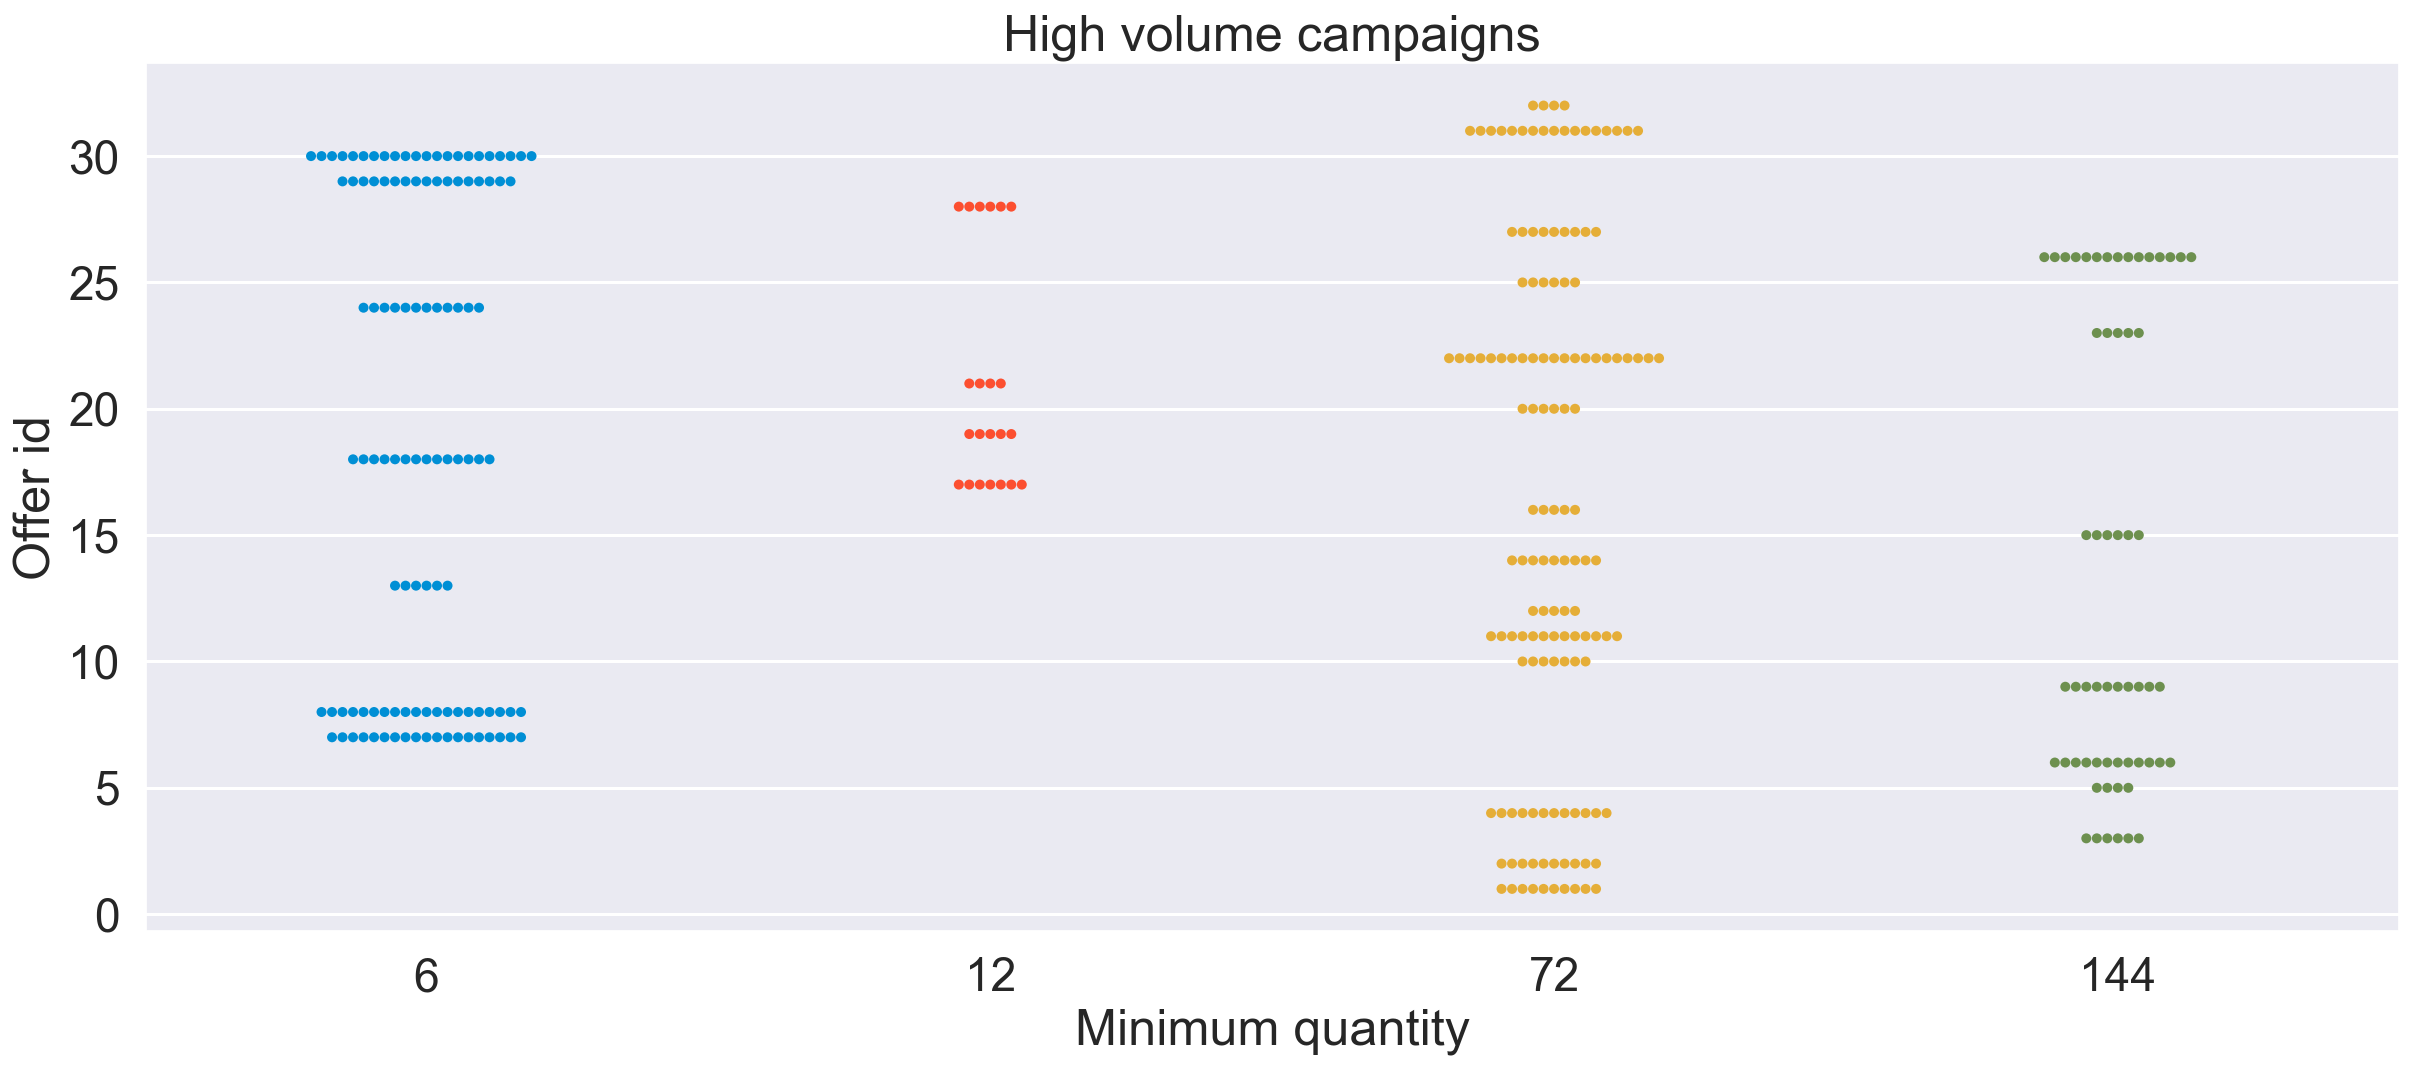

In [9]:
_=sns.set_style("darkgrid")
_=plt.rcParams['figure.figsize'] = [18,8]
_=sns.swarmplot(x='min_qty', y='offer_id',data = df)
_=plt.xlabel('Minimum quantity')
_=plt.ylabel('Offer id')
_=plt.title('High volume campaigns')
#pd.crosstab(df.offer_id,df.min_qty, margins=True, margins_name="Total")

60% of the offers were bulk-packaged campaigns, with 41% of them requiring a minimum of 72 bottles and 18% having a minimum of 144. These campaigns more likely were directed to small business owners who would prefer high volume. 34% of the campaigns offered a minimum of 6 bottles of wine, which would be more in line with individual buyers. 

## Varietal by Campaign

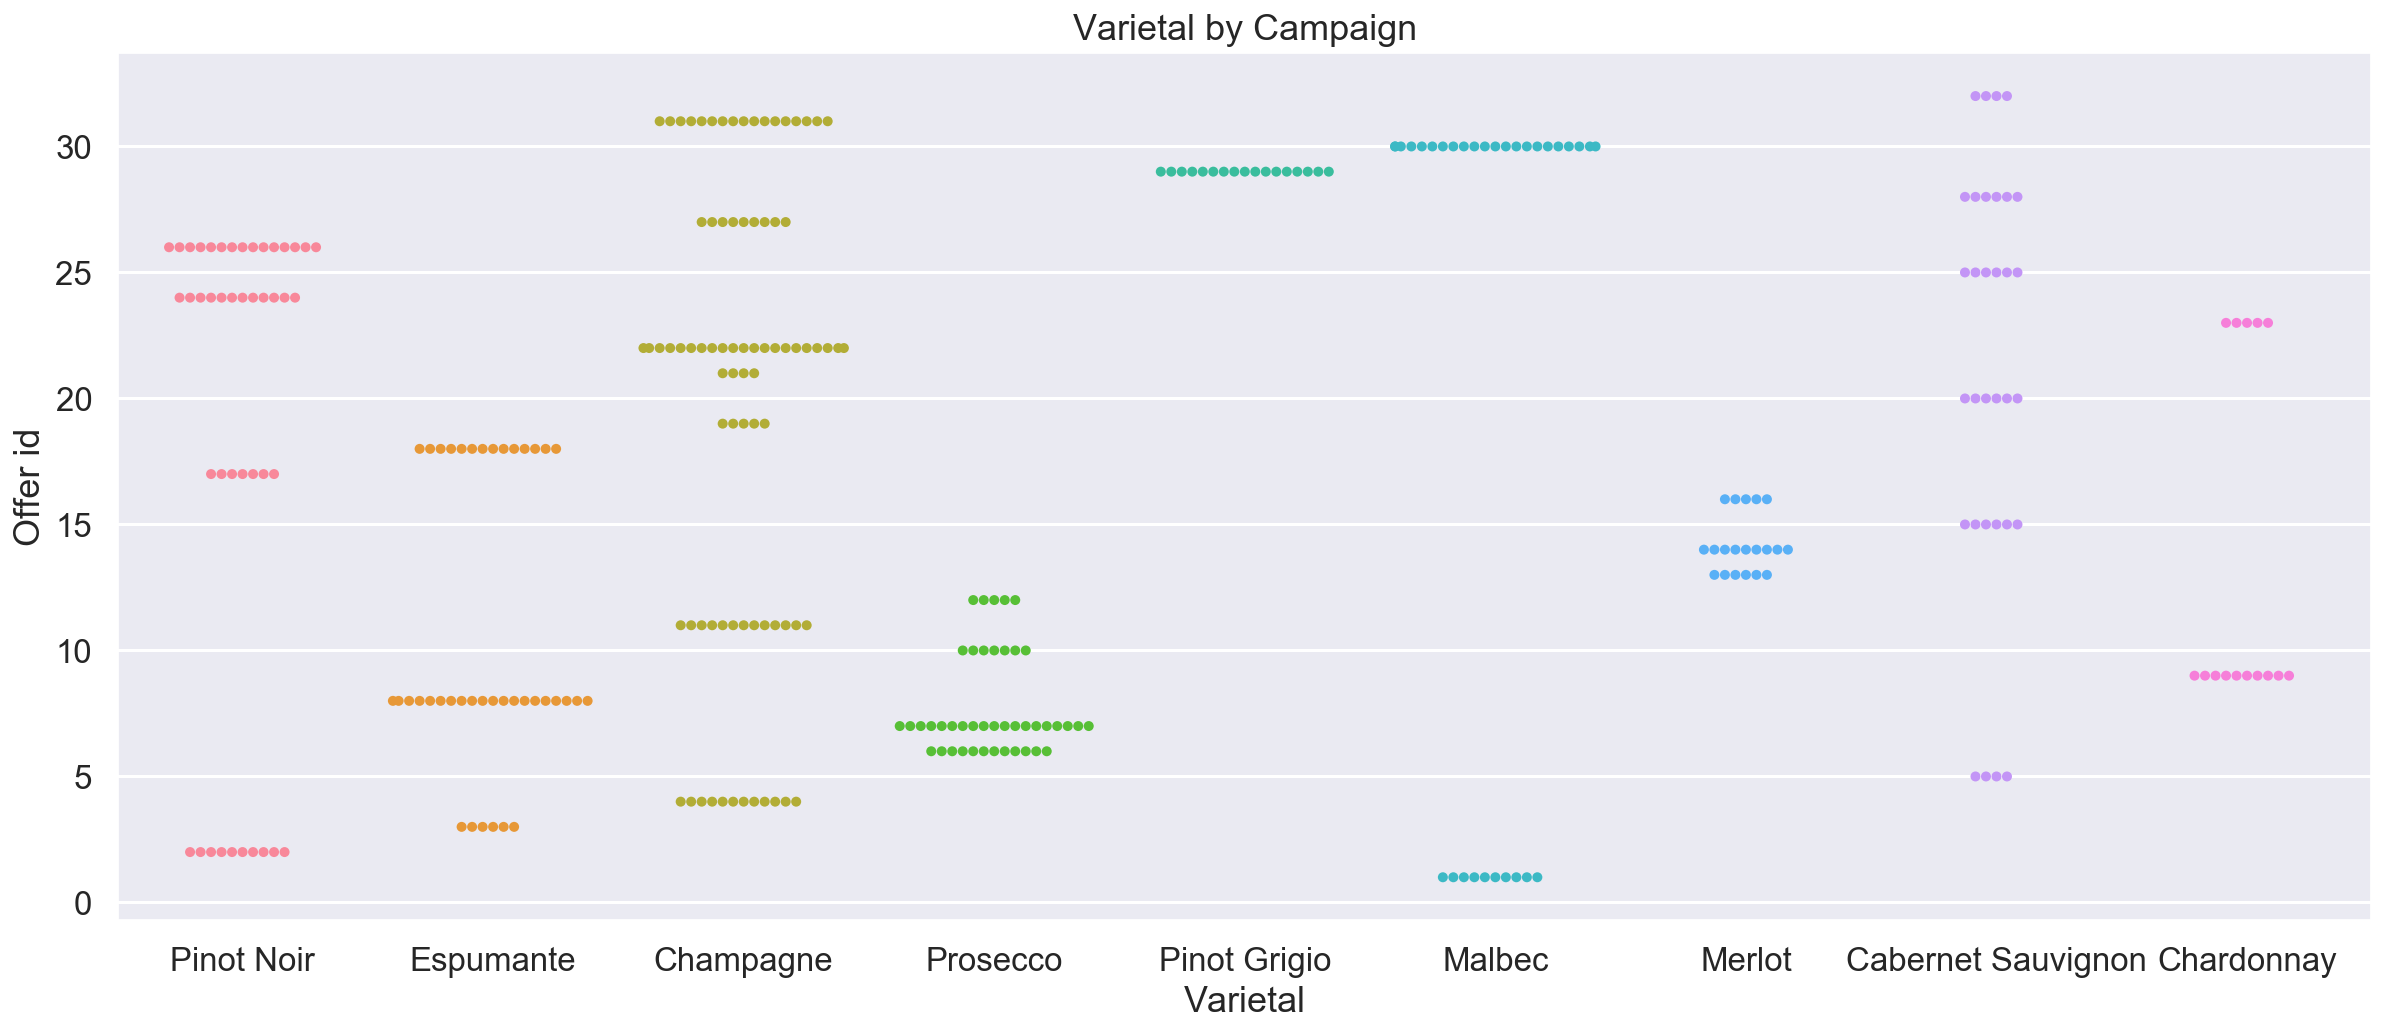

In [10]:
_=sns.set_context("talk", font_scale=1, rc={"lines.linewidth": 4})
_=plt.rcParams['figure.figsize'] = [18,8]
_=sns.set_style("darkgrid")
_=sns.swarmplot(y='offer_id',x='varietal', data = df)
_=plt.xlabel('Varietal')
_=plt.ylabel('Offer id')
_=plt.title('Varietal by Campaign')

Each campaign has a distinct variety, with some varietal wines belonging to several campaigns throughout the year. The most popular ones, which are present in more than one campaign, are Champagne and Cabernet Sauvignon, being featured 7 and 6 times respectively. Pinot Grigio is only offer in a single campaign and the Malbec and Chardonay in two. 

### '30' is the most popular offer
From the 32 available offers, campaign number 30 is the most popular one with 22 responses. The top five campaigns are 30, 22, 8, 7 and 29, all with over 15 responses. 

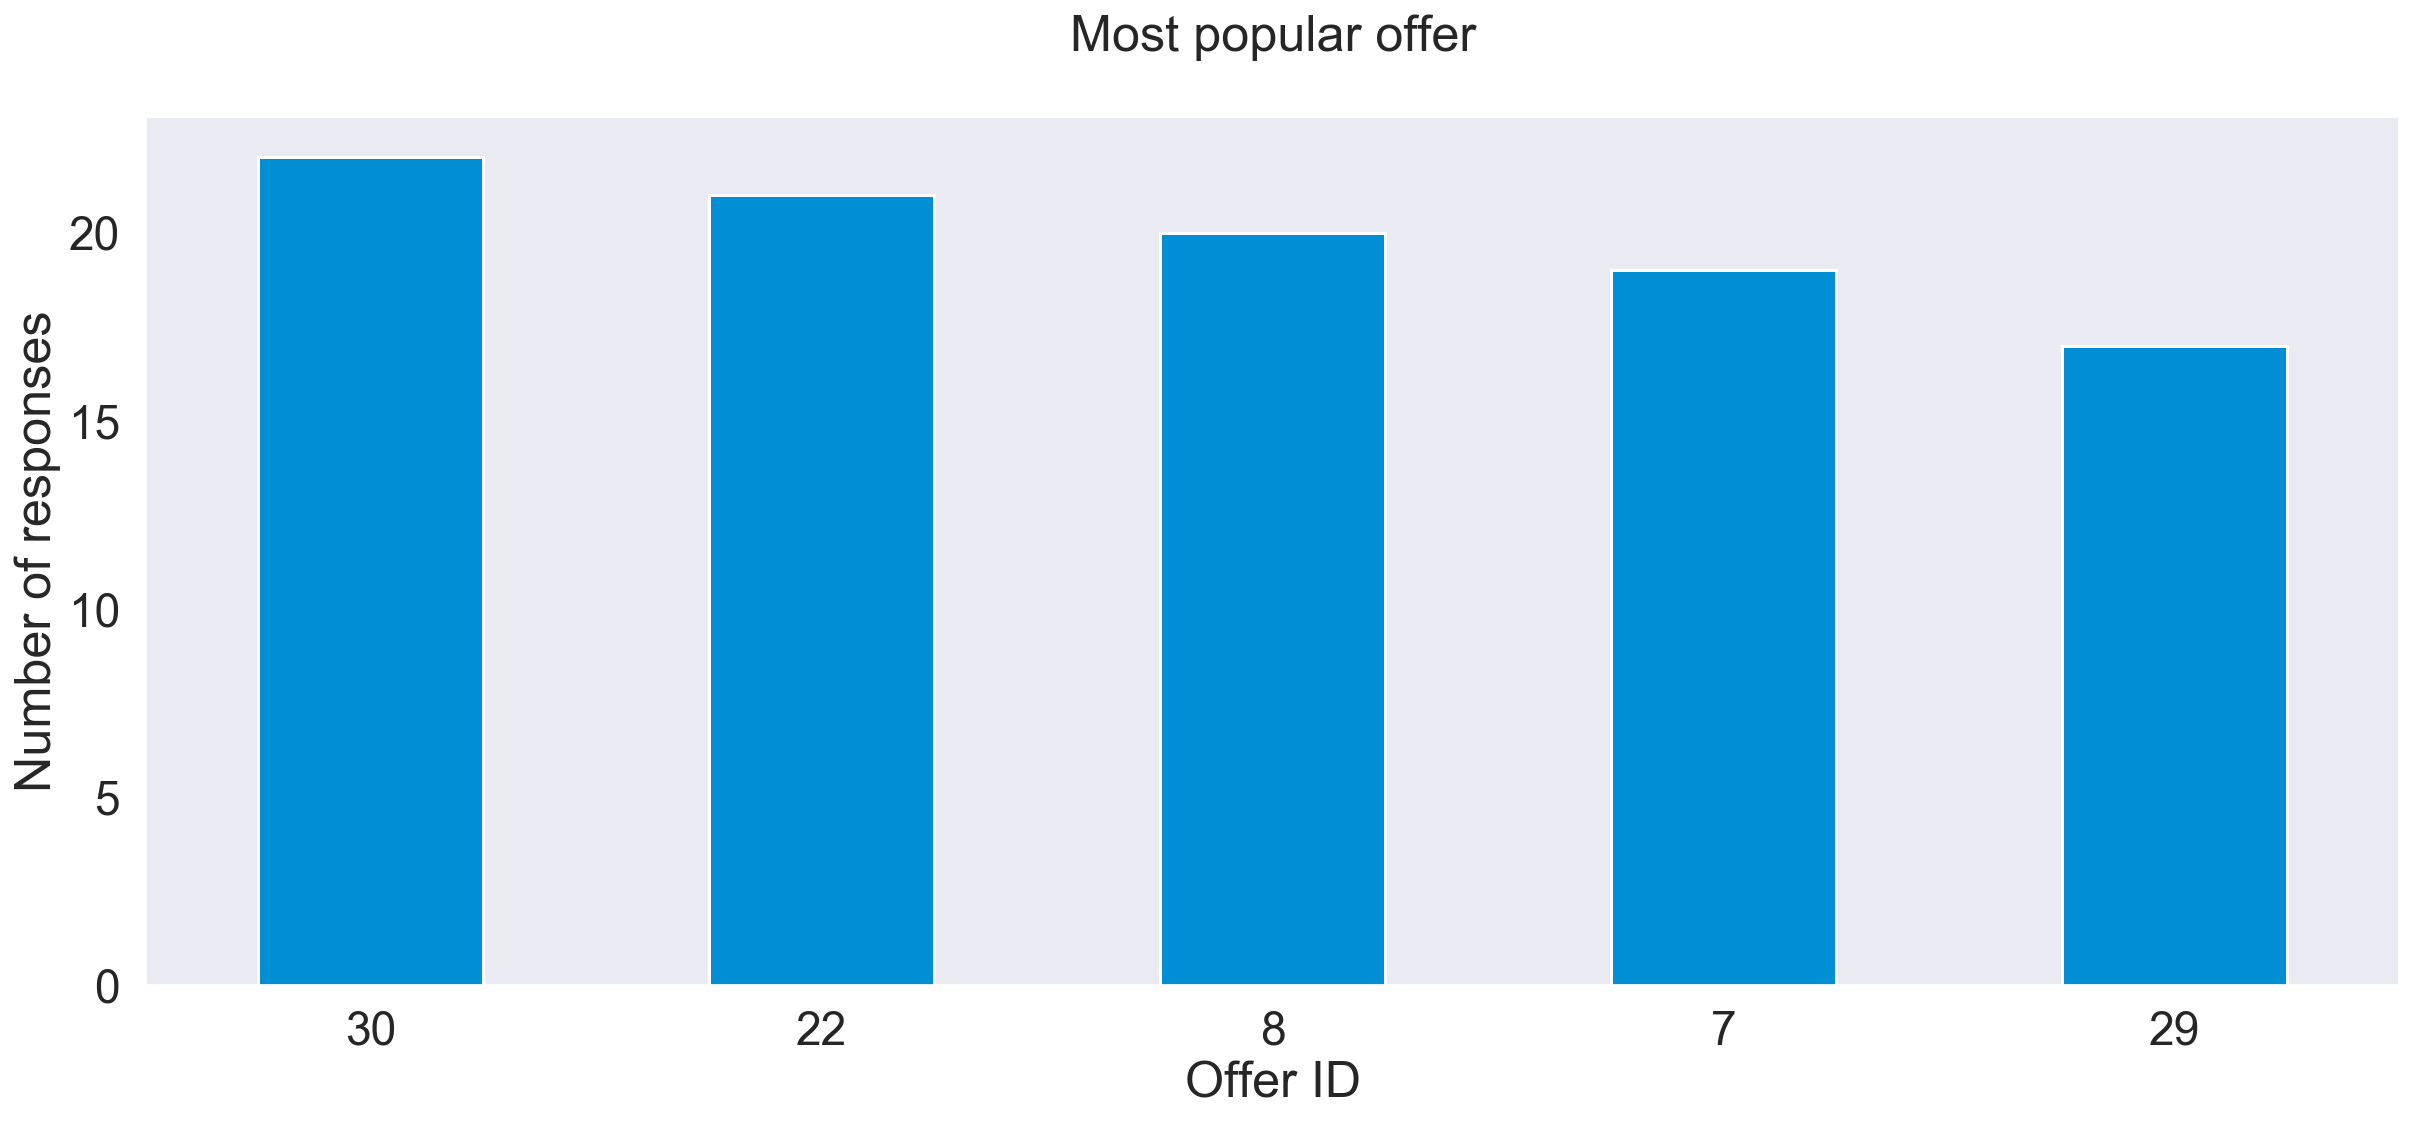

In [11]:
_=sns.set_context("talk", font_scale=1.4, rc={"lines.linewidth": 4})
_=sns.set_style("dark")

# plot top five offers
_=df.groupby(['offer_id']).size().sort_values(ascending = False).head(5).plot(kind = 'bar', rot = 0)
_=plt.title("Most popular offer\n")
_=plt.xlabel('Offer ID')
_=plt.ylabel('Number of responses')

## What makes the top 5 successful?
In order to find what make these campaigns successful, other offer features were analyzed, such as wine's origin, campaign months, and the discount offered.

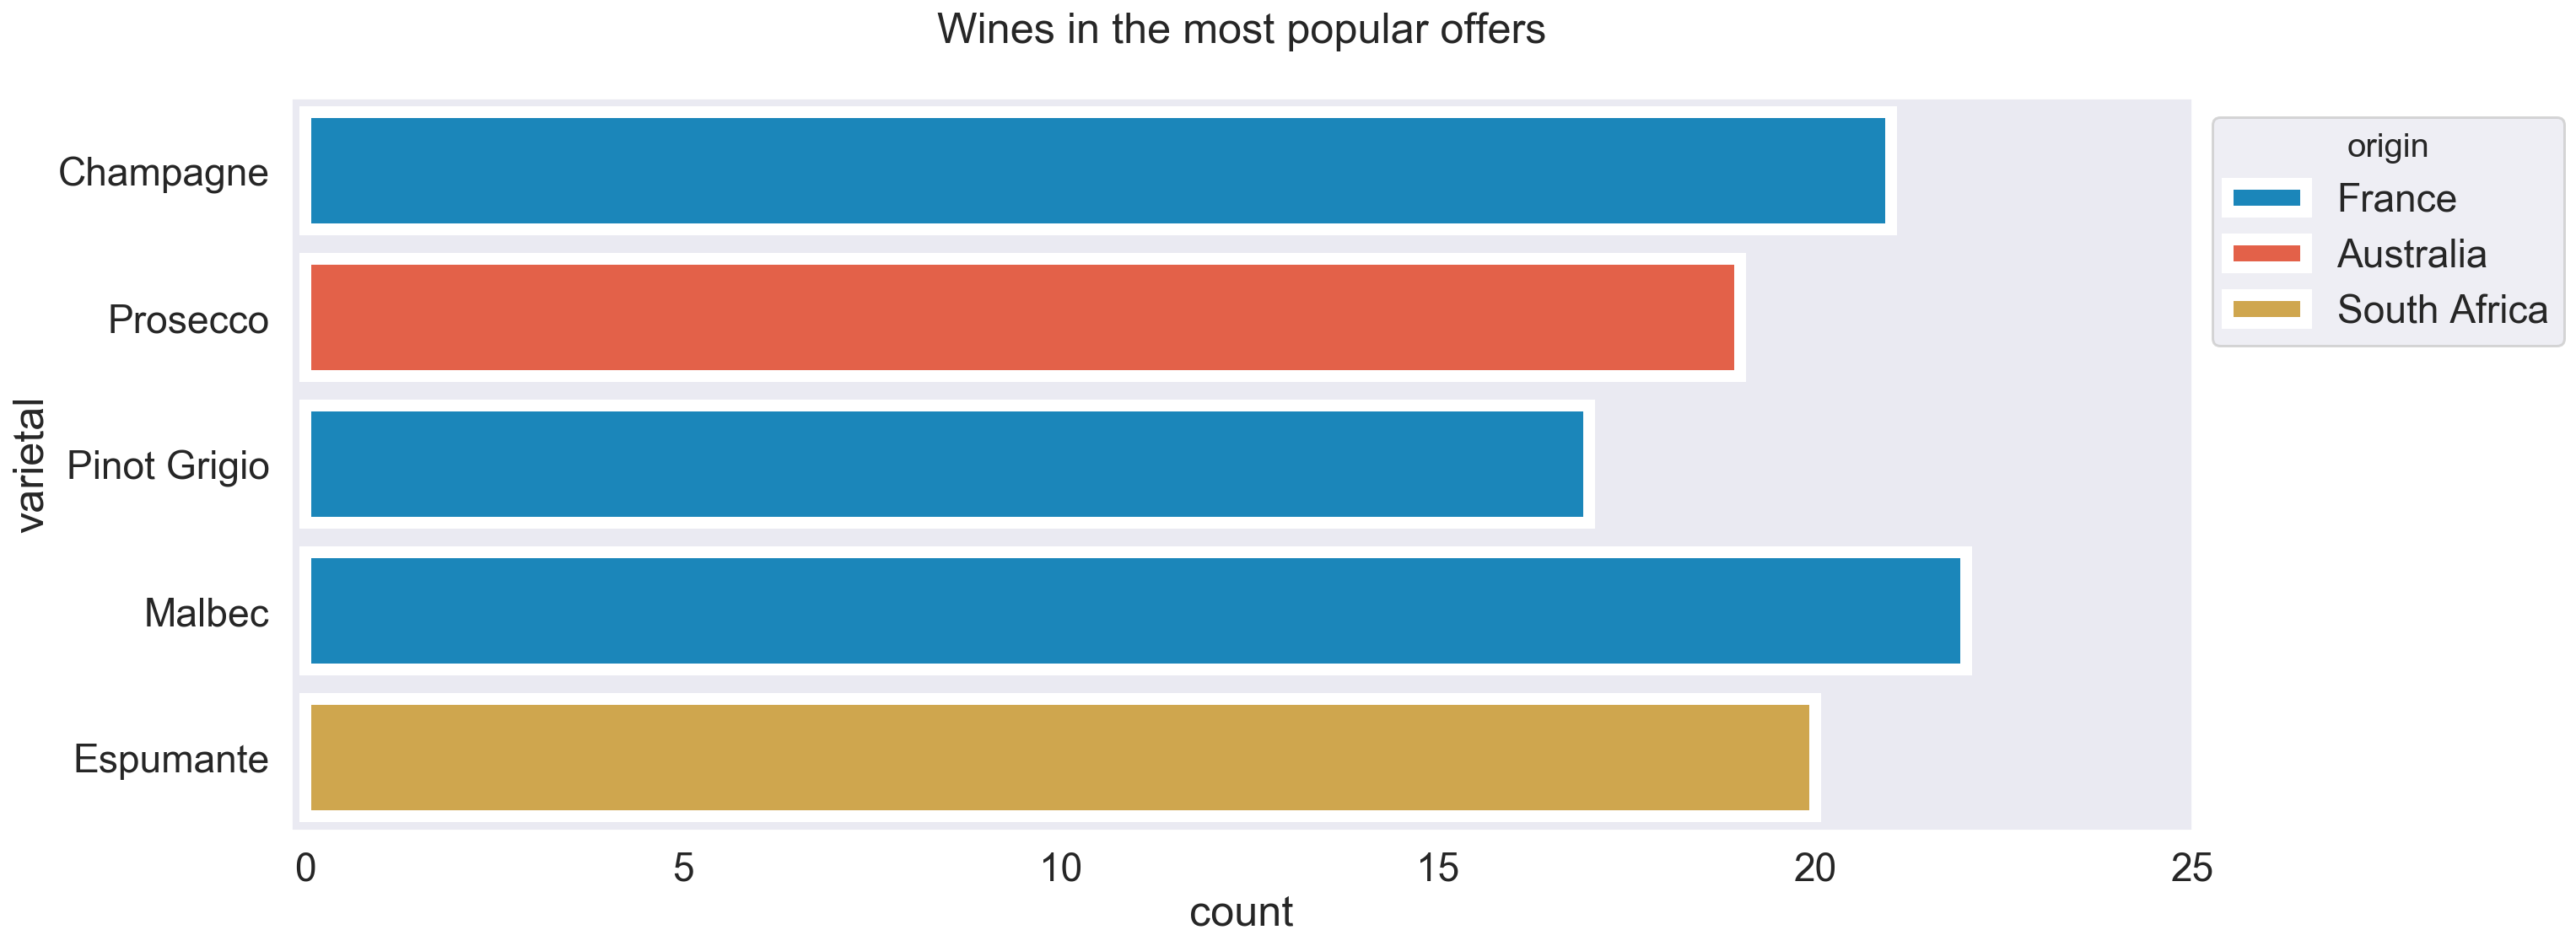

In [12]:
ids = [30,22,8,7,29]
popular = df.loc[df['offer_id'].isin (ids)]
_=sns.set_style("dark")
_=sns.countplot(y='varietal', hue= 'origin',data = popular, linewidth=7, dodge=False)
_=plt.legend(bbox_to_anchor=(1, 1), loc=2, title= 'origin', title_fontsize=20)
_=plt.xlim(-0.2,25)
_=plt.title('Wines in the most popular offers\n')

<p>The bar chart above shows that wines in the top campaigns come from three countries: France, Australia, and South Africa, with two of the most popular wines coming from France, Malbec and Champagne. The Espumante, from South Africa is the third most popular campaign, followed by the Prosecco from Australia.</p> There are two sparkling wines in the top five, Champagne and Espumante, and out of these five wines, the only red one is the Malbec.</p>

## Are these the  offers with the highest discounts?

The top highest discounts offered by a campaign are between between 85 and 89. To see if the most popular campaigns also have the highest discounts, a bar chart was done comparing the number of responses of the five most popular campaigns and the discount amount.

In [13]:
# five highest discounts
df.groupby(['offer_id', 'discount']).size().reset_index().sort_values('discount', ascending = False).head(6)

,offer_id,discount,0
30,31,89,17
15,16,88,5
26,27,88,9
28,29,87,17
5,6,86,12
10,11,85,13


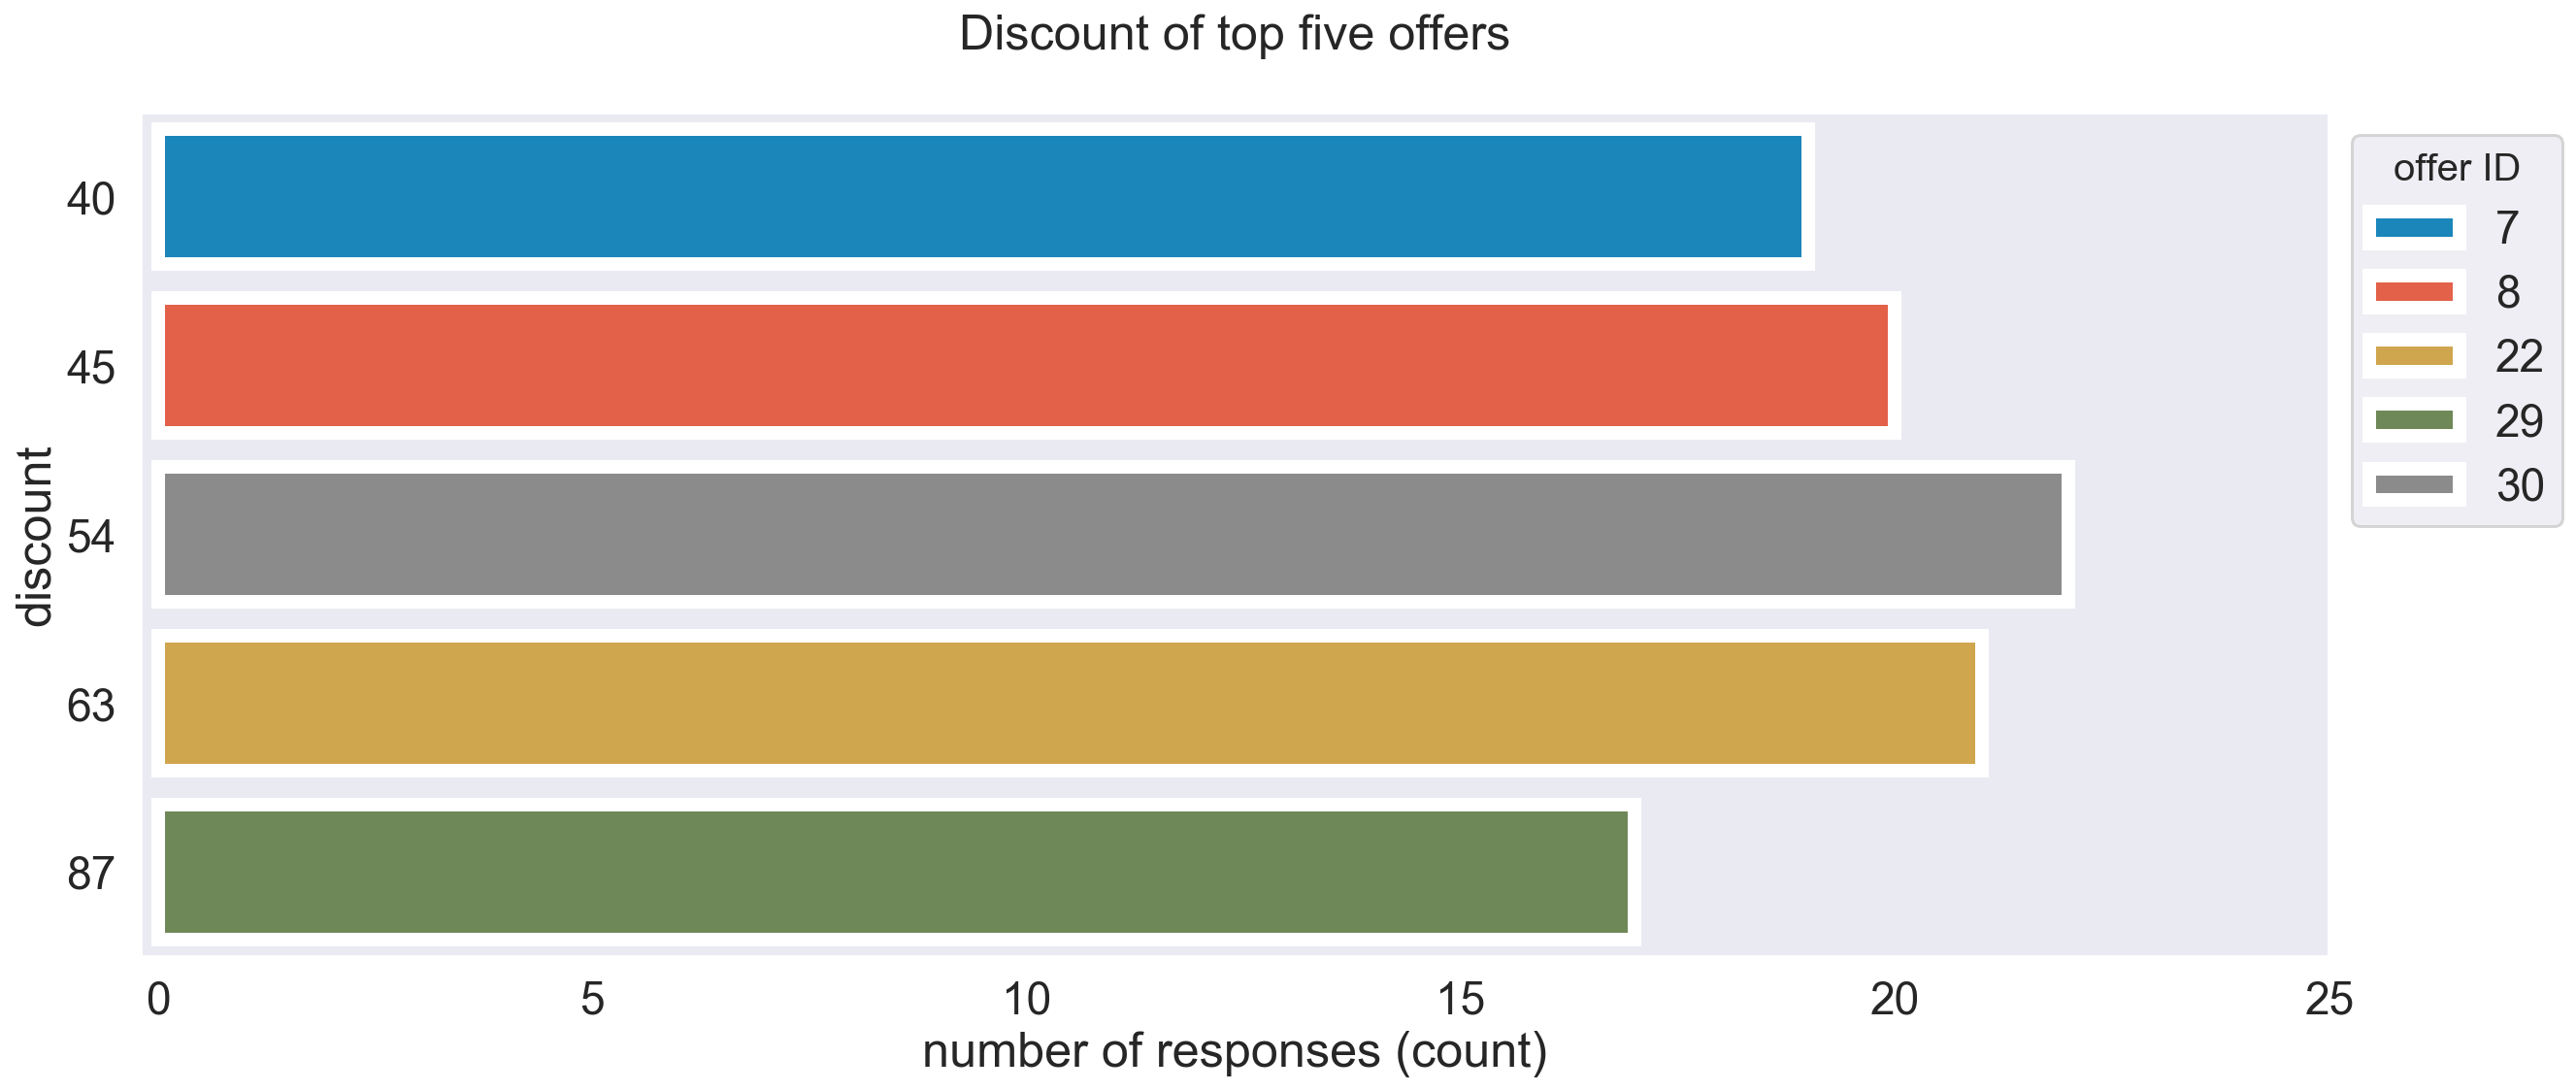

In [14]:
# plot number of responses of five most popular campaigns by discount amount and colored by id
_=sns.countplot(y='discount',data = popular,hue = 'offer_id', linewidth=7, dodge = False)
_=plt.legend(bbox_to_anchor=(1, 1), loc=2, title= 'offer ID', title_fontsize=20)
_=plt.xlim(-0.2,25)
_=plt.title('Discount of top five offers\n')
_=plt.xlabel('number of responses (count)')

The bar plot shows that the top offer, number 30, doesn't have the highest discount among the top five or overall. In fact the discount for offer 30 is below the median discount, which is 56. The highest discount was for offer 29, which is also the top three overall highest discount.

## Best months

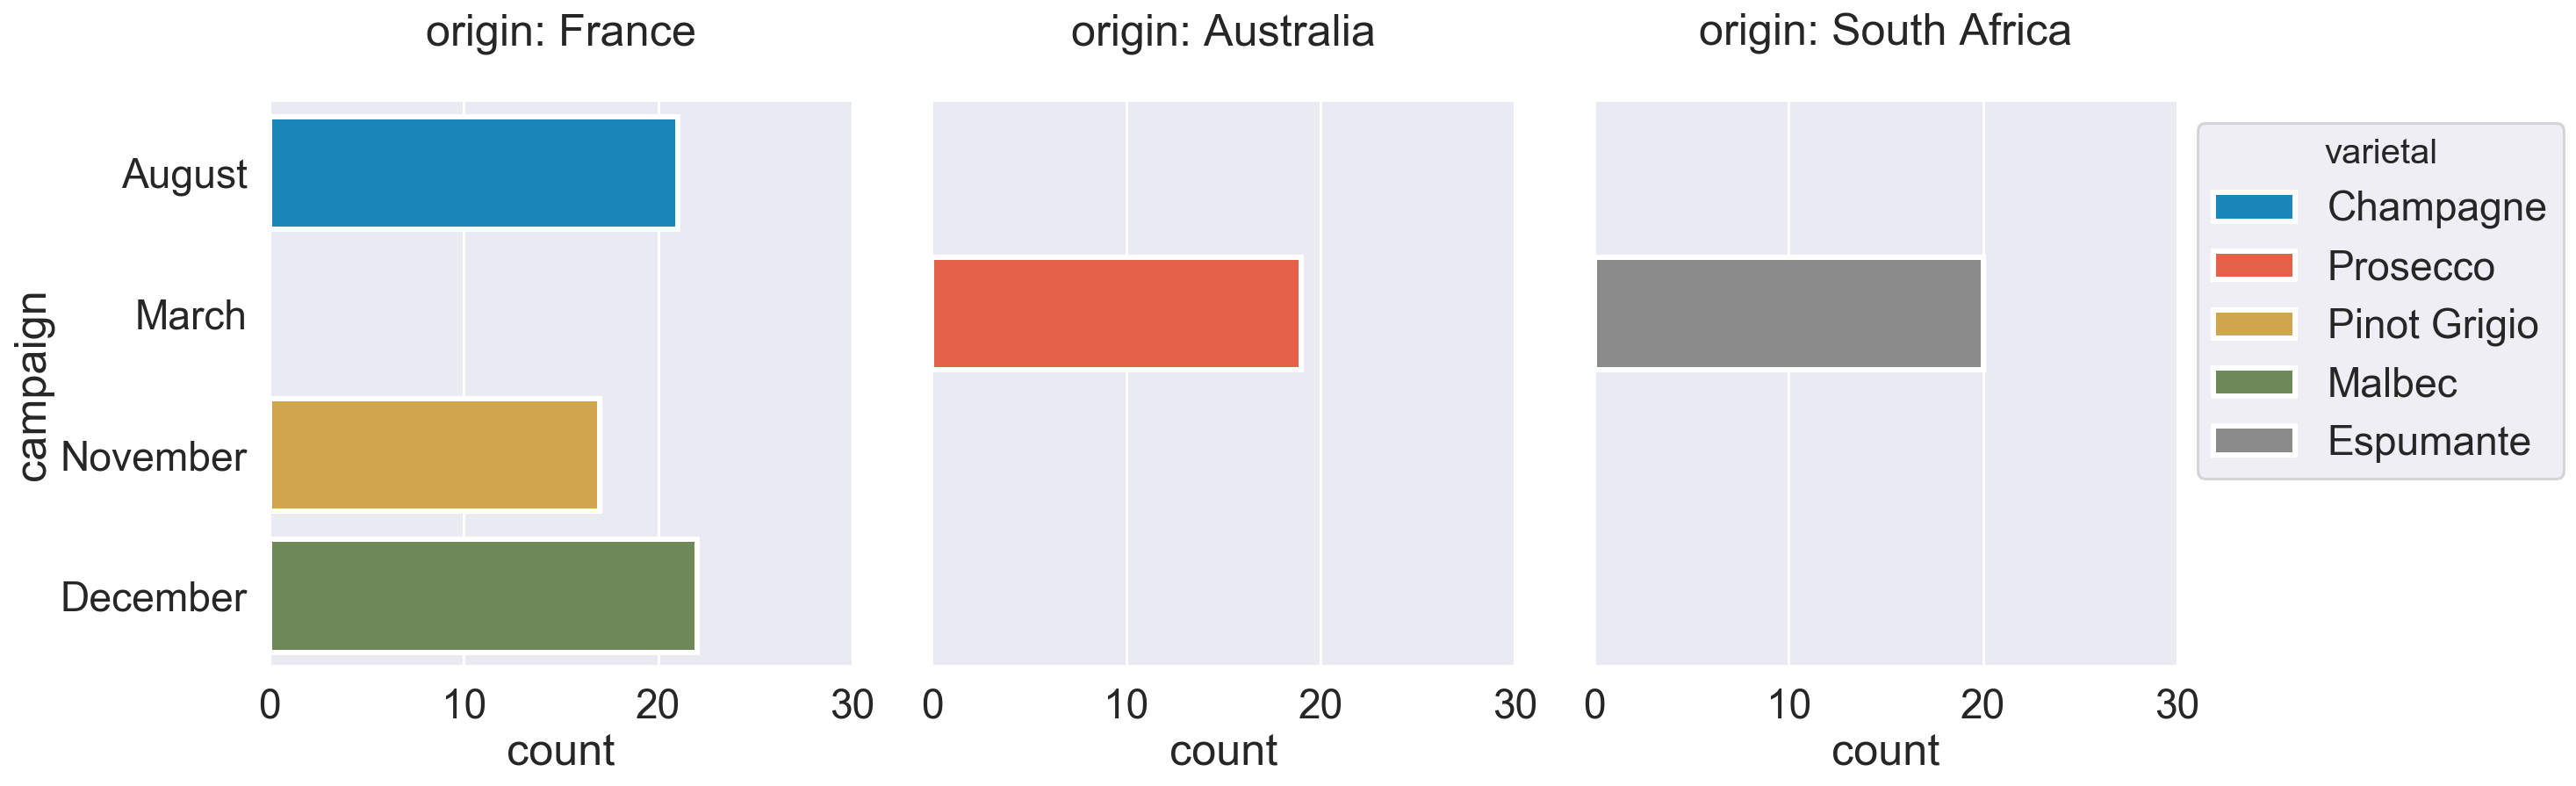

In [15]:
_=sns.set_style("darkgrid")
_=sns.catplot(y="campaign", hue="varietal", col="origin",data=popular, kind="count",height=6, aspect=1,
              col_wrap=3, dodge = False, linewidth = 3, legend=False)
_=_.set_titles("{col_var}: {col_name}\n")
_=plt.legend(bbox_to_anchor=(1, 1), loc=2, title= 'varietal', title_fontsize=20)
_=plt.xlim(0,30)

<p>The best offers run in December with the Malbec variety, in August with Champagne, and in March with Espumante. The popularity of the Malbec variety in December may be due to the holiday season as more people may buy the offer as a present and the cold weather, since read wines are specially popular during winter. This may also explain why it has the highest discount, since the holiday season retailers to have special discounts or promotions.</p>

## Least popular offers
After looking at the top five, we're interested in looking at the campaigns that didn't receive many responses.

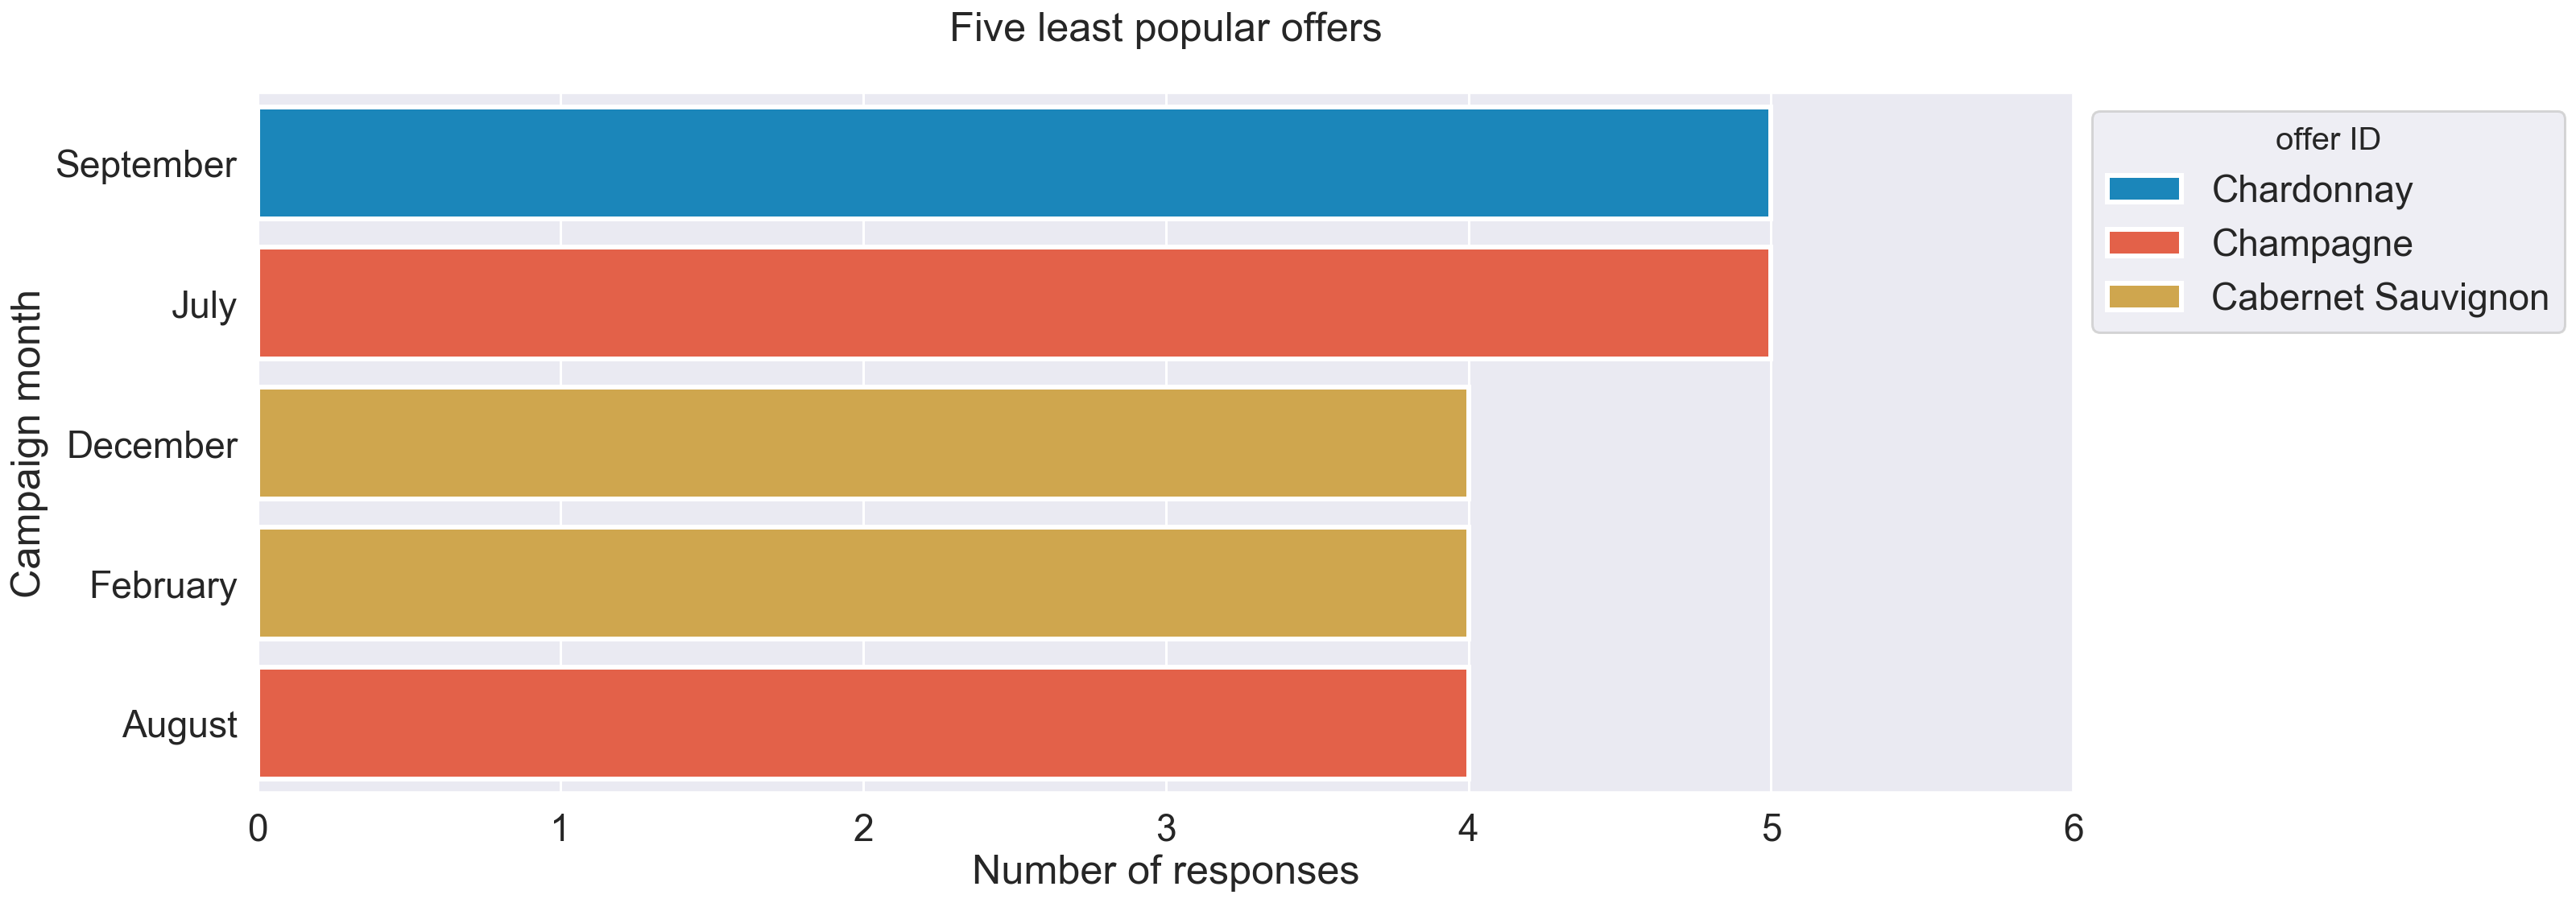

In [16]:
_=plt.rcParams['figure.figsize'] = [18,8]
n_least = [32,21,5,23,19]
least_pop = df.loc[df['offer_id'].isin (n_least)]

_=sns.countplot(y='campaign', hue= 'varietal',data = least_pop, linewidth=3, dodge=False)
_=plt.legend(bbox_to_anchor=(1, 1), loc=2, title= 'offer ID', title_fontsize=20)
_=plt.xlabel('Number of responses')
_=plt.ylabel('Campaign month')
_=plt.xlim(0,6)
_=plt.title('Five least popular offers\n')

The least popular campaigns offer Cabernet Sauvignon, which run in December and February, and the Champagne campaign in August. Although the Cabernet Savignon is also a red wine it is not as popular as the Malbec.

## EDA summary
<p>The preliminary analysis showed that offer number 30 had 22 responses, followed by number 22 with 21, campaign 8 with 20. White wine was in four of the five top offers and the most popular wines come from France, South Africa and Australia, with three of them coming from France. Only one of the campaigns, 29, offers one of the highest discounts among all campaigns and three of them offer discounts that are below the median.</p>
<p>The most popular campaign was run in December with the Malbec variety with 22 responses. The second  most popular was the offer run in August with Champagne, followed by the March campaign, which offer Prosecco.</p>

***

<a id='km'></a>

## K-Means Clustering
<p>Since clustering is a type of unsupervised learning, where the data has no labels, the classification happens when the algorithm finds similarities among a group. The objective of K-Means clustering is to use the distance between the data points to minimize the distance between the points in each group and its center and maximize the distance between the center of each group and other groups.</p>
<p>Before running the algorithms, we need to change the data structure to a matrix that has a row for each customer and a binary variable for each campaign, with a 1 if the customer responded to the campaign and a 0 otherwise. The idea is to have one row per outcome, whether it's positive(1) or negative(0).</p>

In [17]:
# create the matrix and fill missing values with 0
# this represents no response to the marketing offer
marketing = df.pivot_table(index ='customer_name', columns='offer_id',values='n', aggfunc= 'count',fill_value=0)
marketing.reset_index(inplace=True)

In [18]:
# confirm structure was change
print('number of records: ', marketing.shape[0])
marketing.head(2)

number of records:  100


offer_id,customer_name,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,Adams,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
1,Allen,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


<a id='elbow'></a>

### Choosing $K$: The Elbow Sum-of-Squares Method

<p>There are a few methods used to identify the 'optimal' number of clusters. The following sections will discuss the 'Elbow method', the Silhouette method and the gap statistic.</p>


The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

#### What values of  𝑆𝑆  would represent better clusterings?

<p>Since the idea of clustering is to have similar data points together and clearly separated from others, a small sum-of-squares will mean the points within the cluster are close to the  center of the cluster they have been assigned to. Hence, the smaller the number, the higher the similarity between the data points.</p>


#### Finding a suitable number of clusters
<p>The first part to find a 'suitable' number of cluster that identifies similarities in the successful marketing campaigns is to try different number of clusters.</p>

In [19]:
# create a matrix with only the results of the campaigns
x_cols = np.matrix(marketing.iloc[:,1:])

# extract the campaign identification numbers
col_names = np.array(marketing.columns[1:])

In [20]:
# use a for loop to find the 'best' number of clusters
np.random.seed(88)

# number of clusters to try
clusters =range(2,11)
# append the sum of squared distances of samples to their closest cluster center.
ssd = []
ss= []
for i in clusters:
    #initialize KMeans object
    km = KMeans(n_clusters=i, random_state=10)
    # fit the model to the data
    km_predict=km.fit_predict(x_cols)
    #find the distance
    ssd.append(km.inertia_)
    ss.append(km_predict)

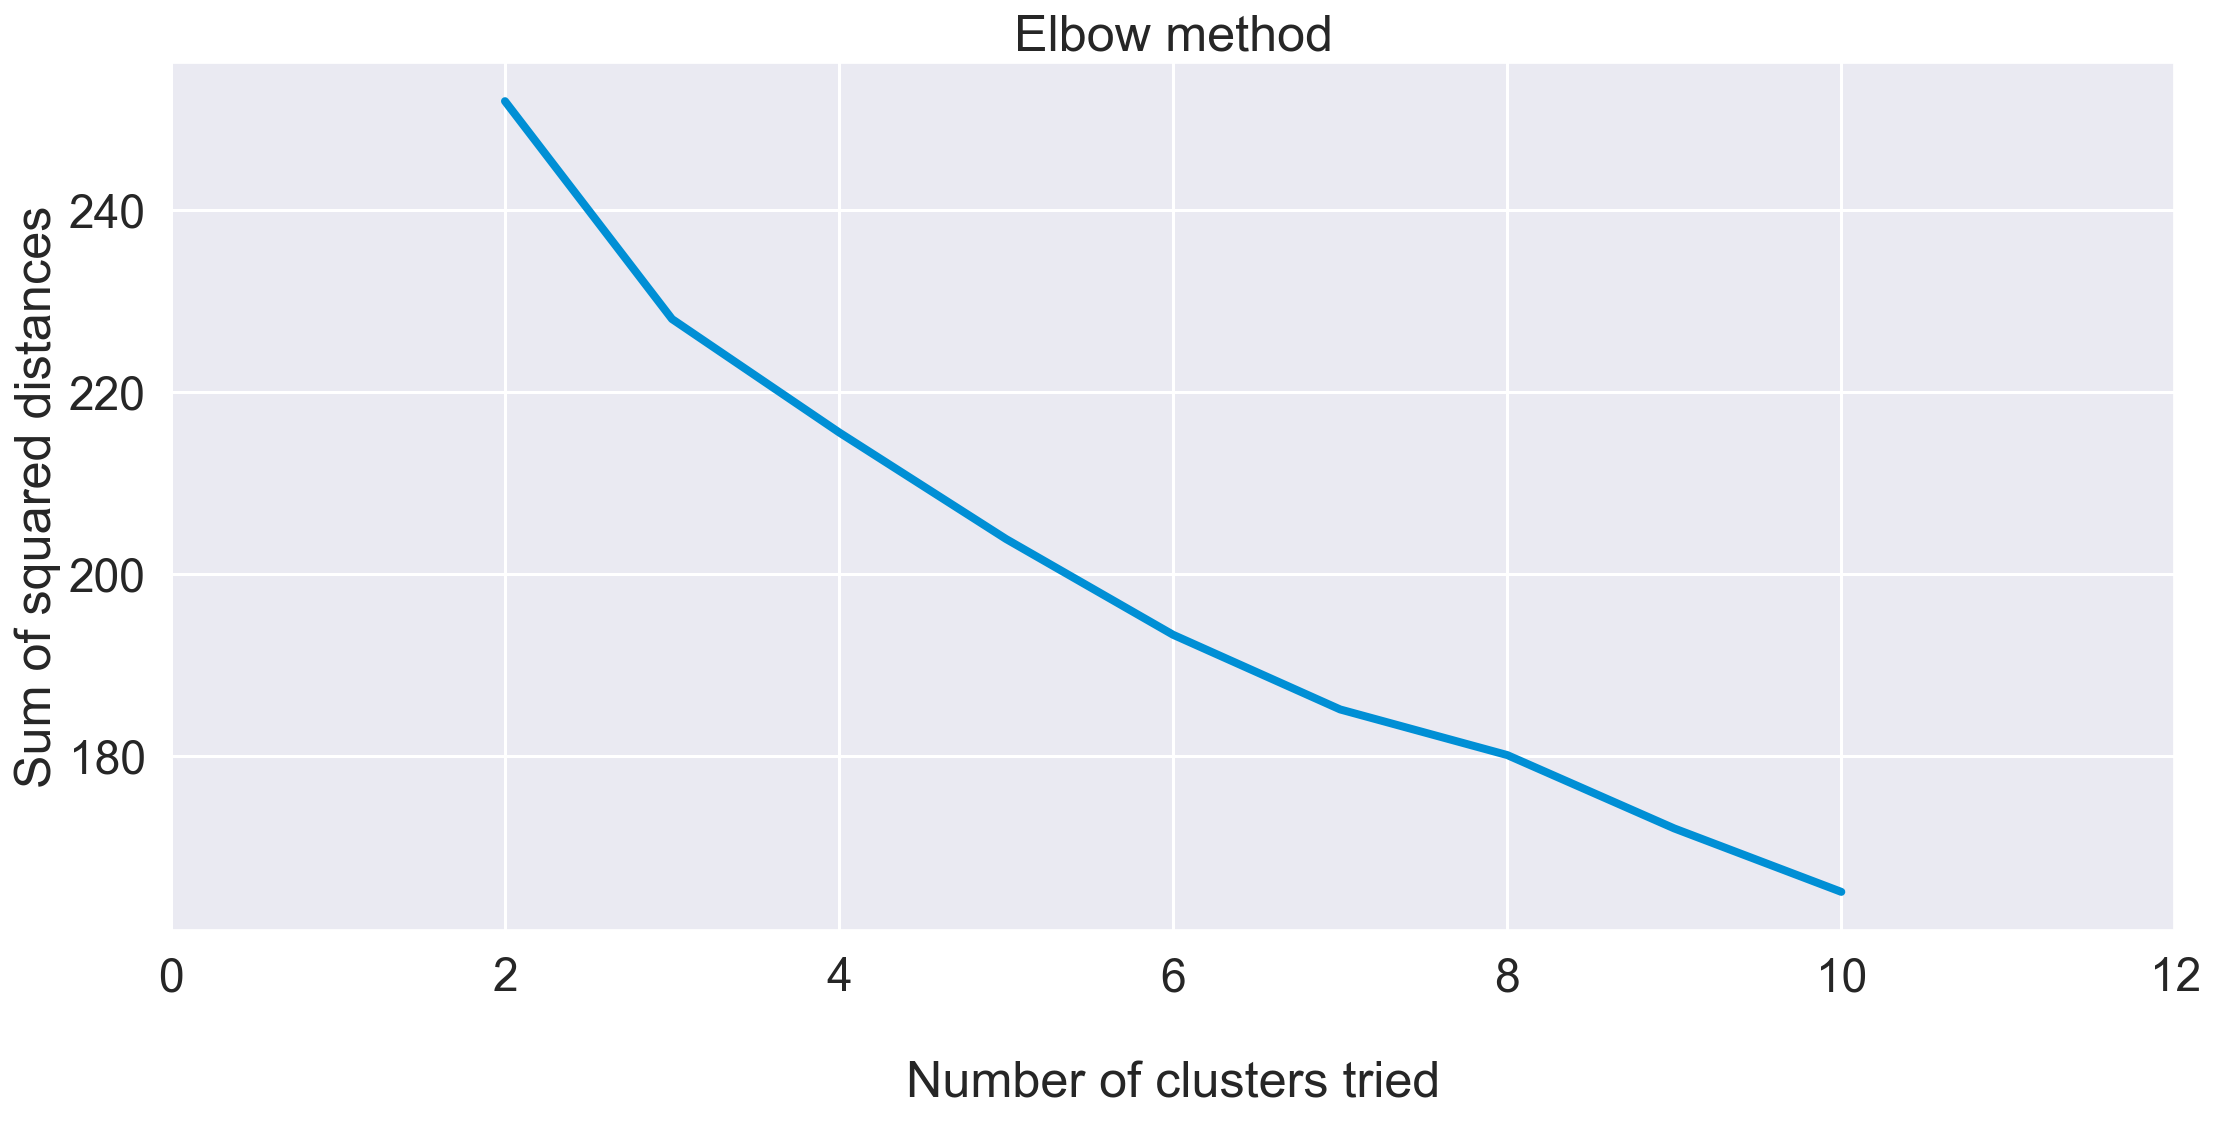

In [21]:
# plot showing SS for each K
_=plt.rcParams['figure.figsize'] = [16,8]
_=sns.set_style("darkgrid")
_=plt.plot(clusters,ssd)
_=plt.xlim(0,12)
_=plt.title('Elbow method')
_=plt.xlabel('\nNumber of clusters tried')
_=plt.ylabel('Sum of squared distances')


The 'Elbow' method shows that the 'optimal' number of clusters is 3. One of the challenges of the method is that the 'optimal' number is not absolute and it can drastically changed based on the seed and the distance method used when running the algorithm.

#### Customer Segmentation with 'optimal' number of clusters

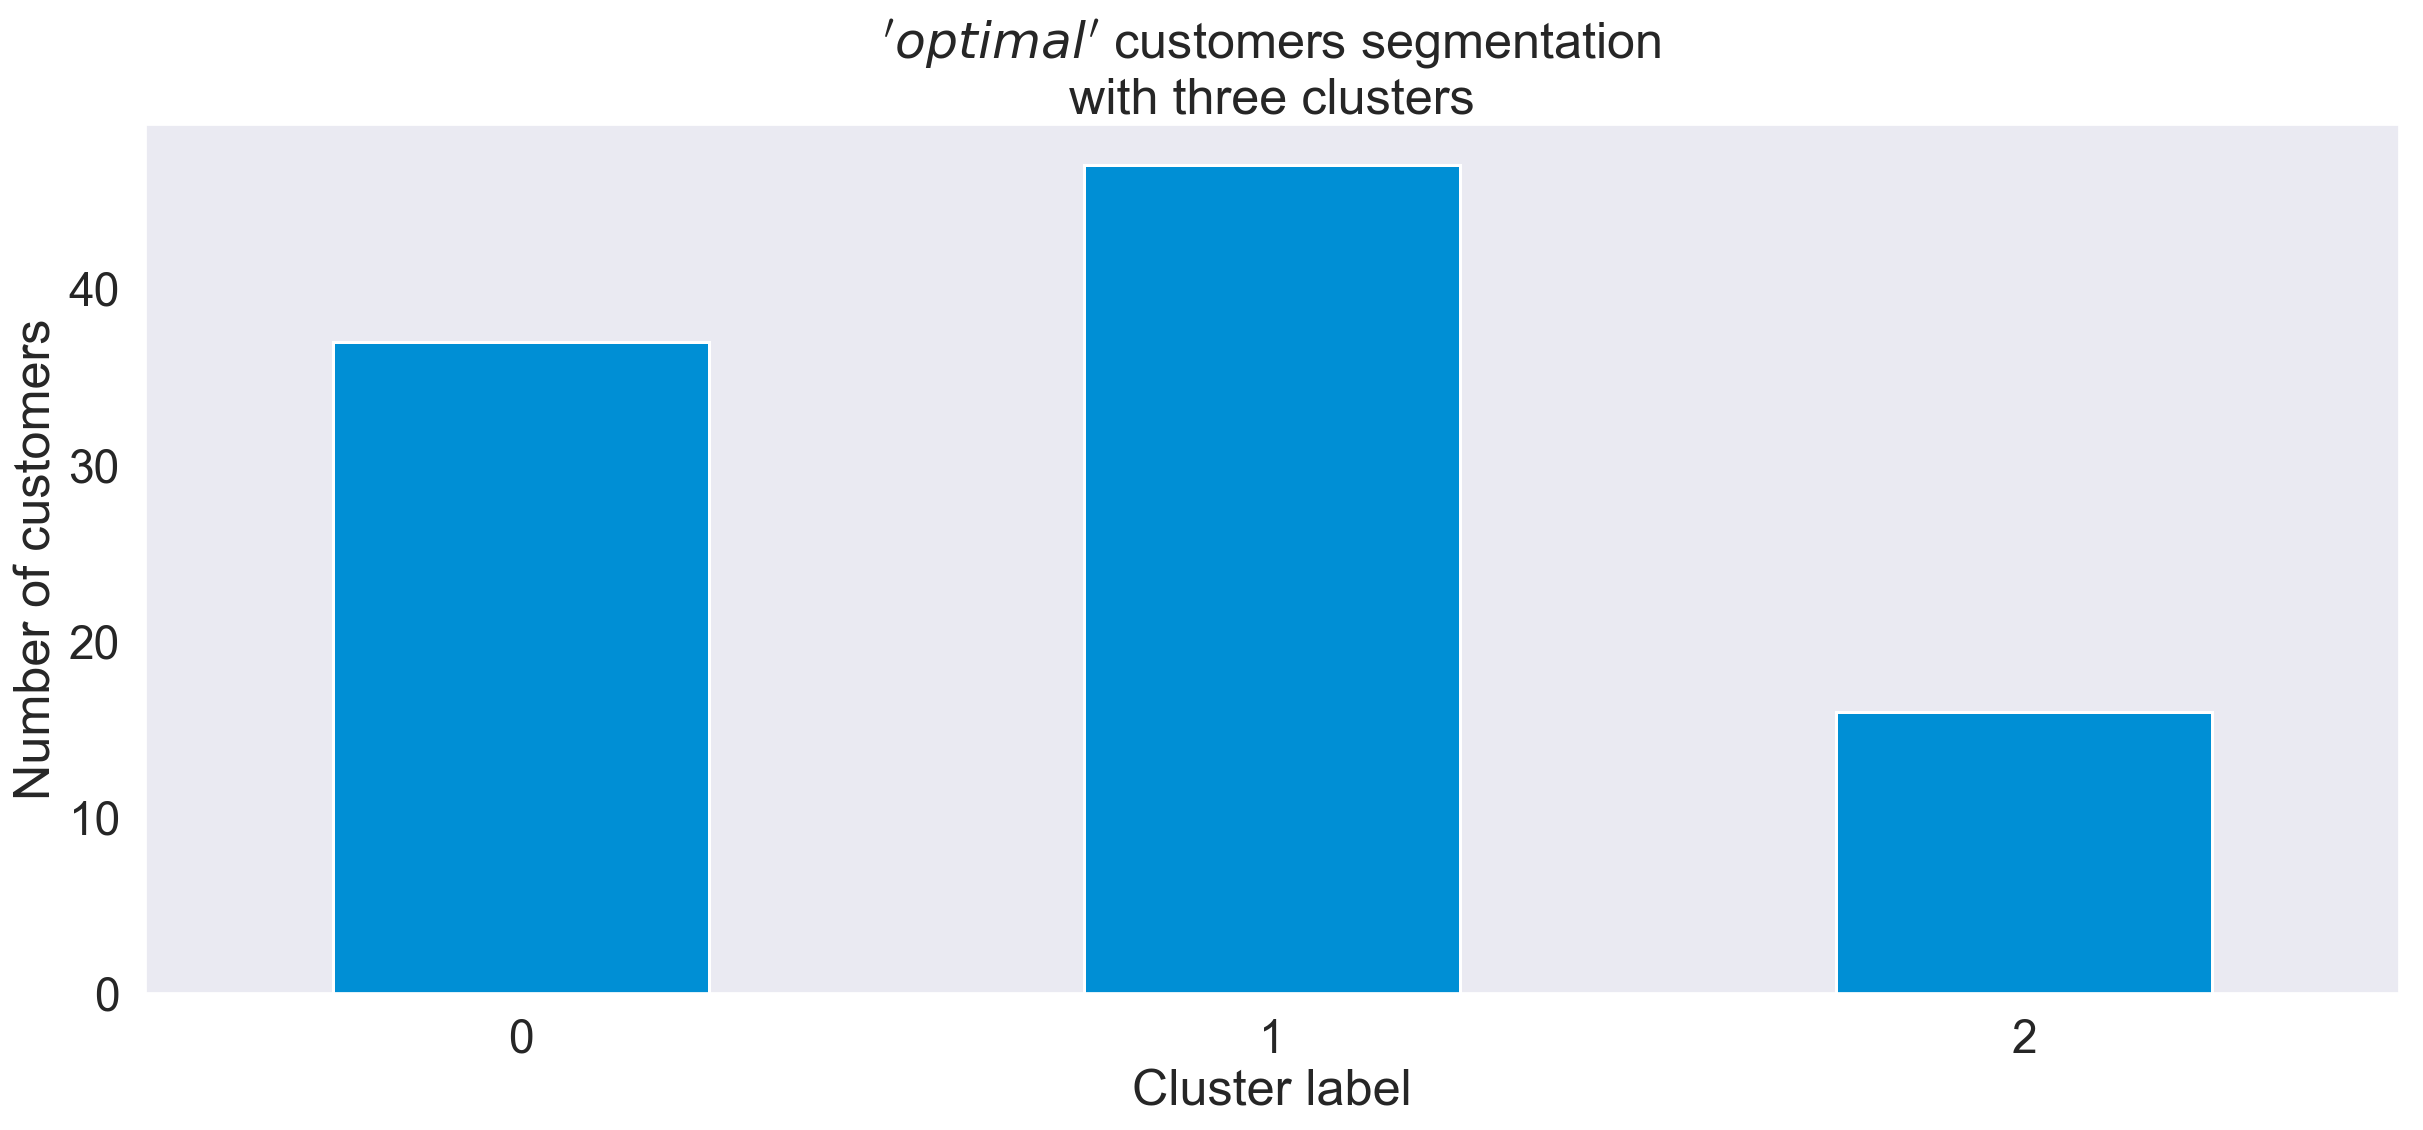

In [22]:
sns.set_style("dark")
_=plt.rcParams['figure.figsize'] = [18,8]
from collections import Counter 
km = KMeans(n_clusters=3, random_state=8)
best_k=km.fit_predict(x_cols)
_=pd.Series(Counter(best_k)).sort_index().plot(kind = 'bar', rot = 0)
_=plt.title("$'optimal'$ customers segmentation\nwith three clusters")
_=plt.ylabel('Number of customers')
_=plt.xlabel('Cluster label')

Using three clusters, the algoritm estimates that there are over 40 customers that share similar tastes and attributes when it comes to wines.

In [23]:
# add the cluster label to the merged dataframe
marketing['predict_cluster'] = best_k

<a id='sm'></a>

## Choosing $K$: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

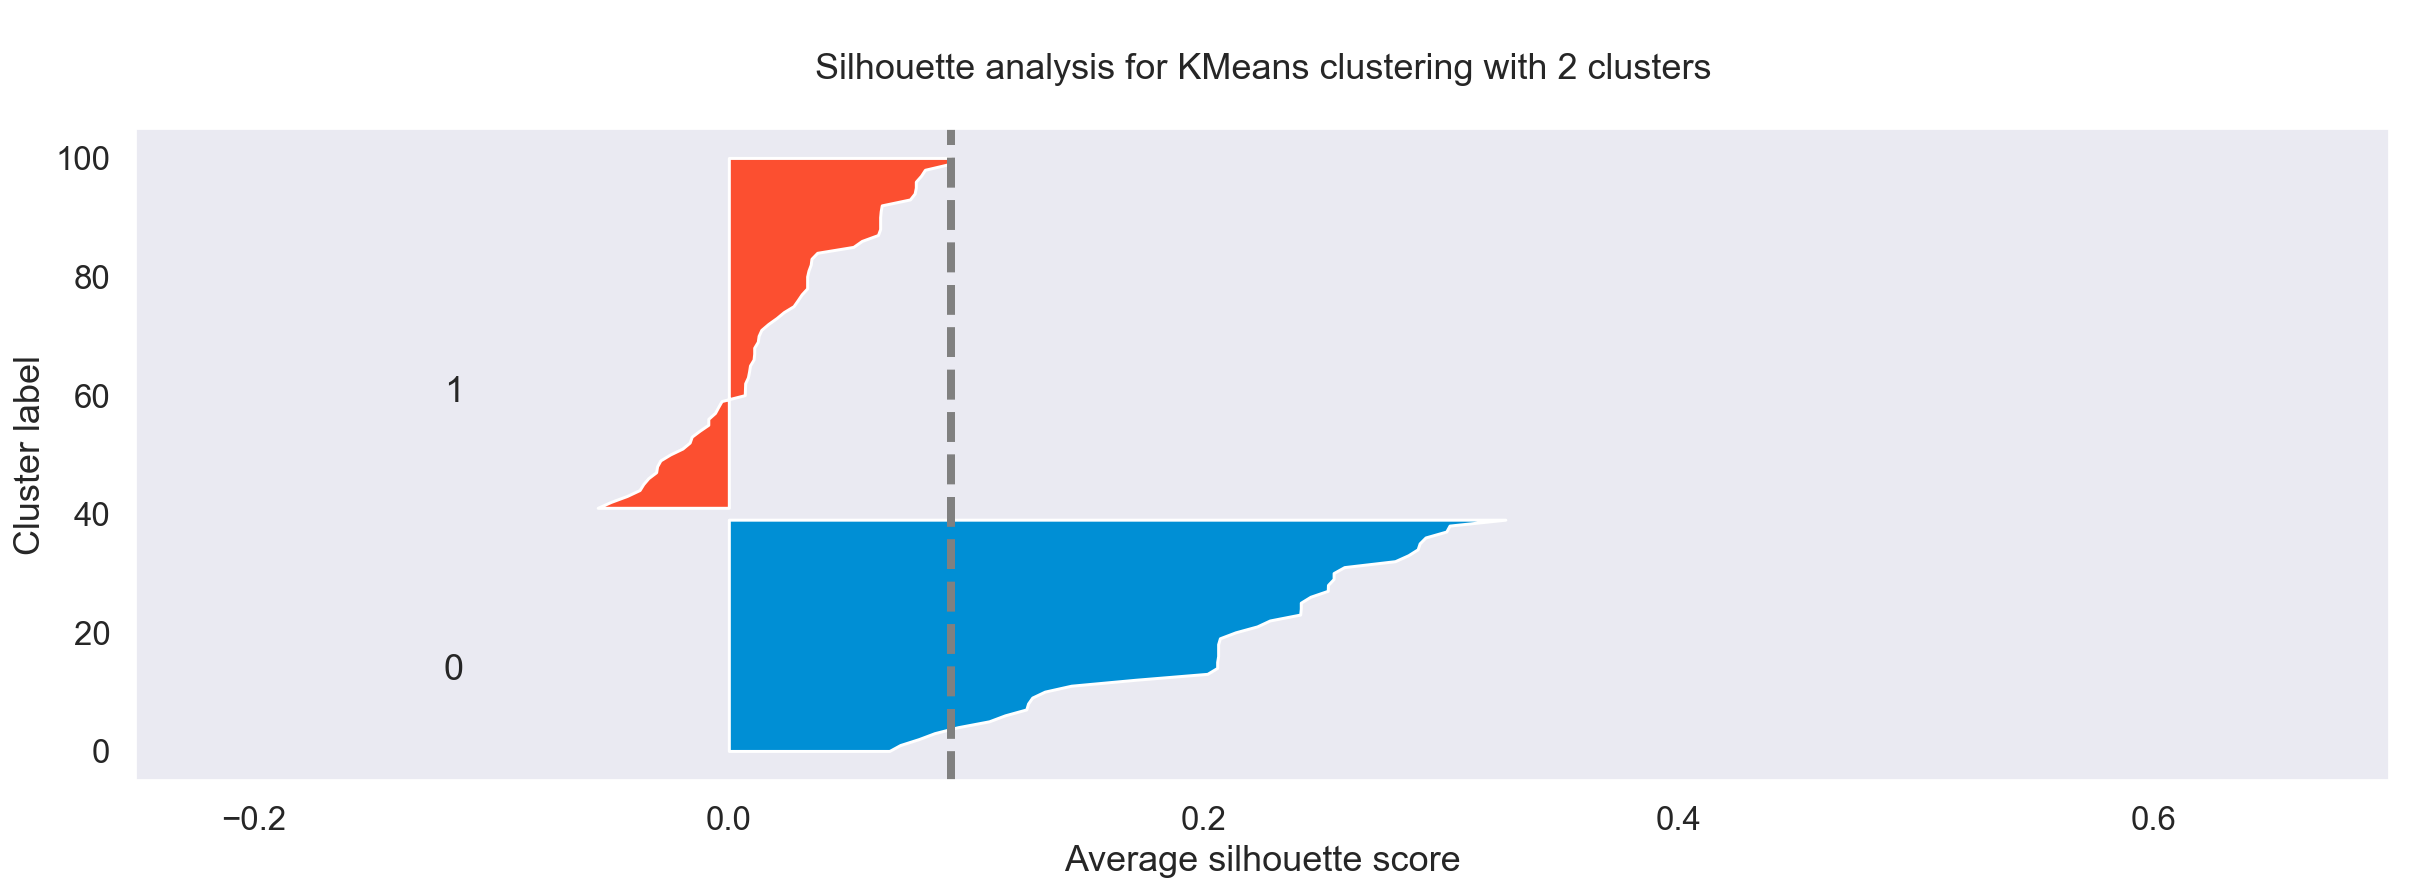

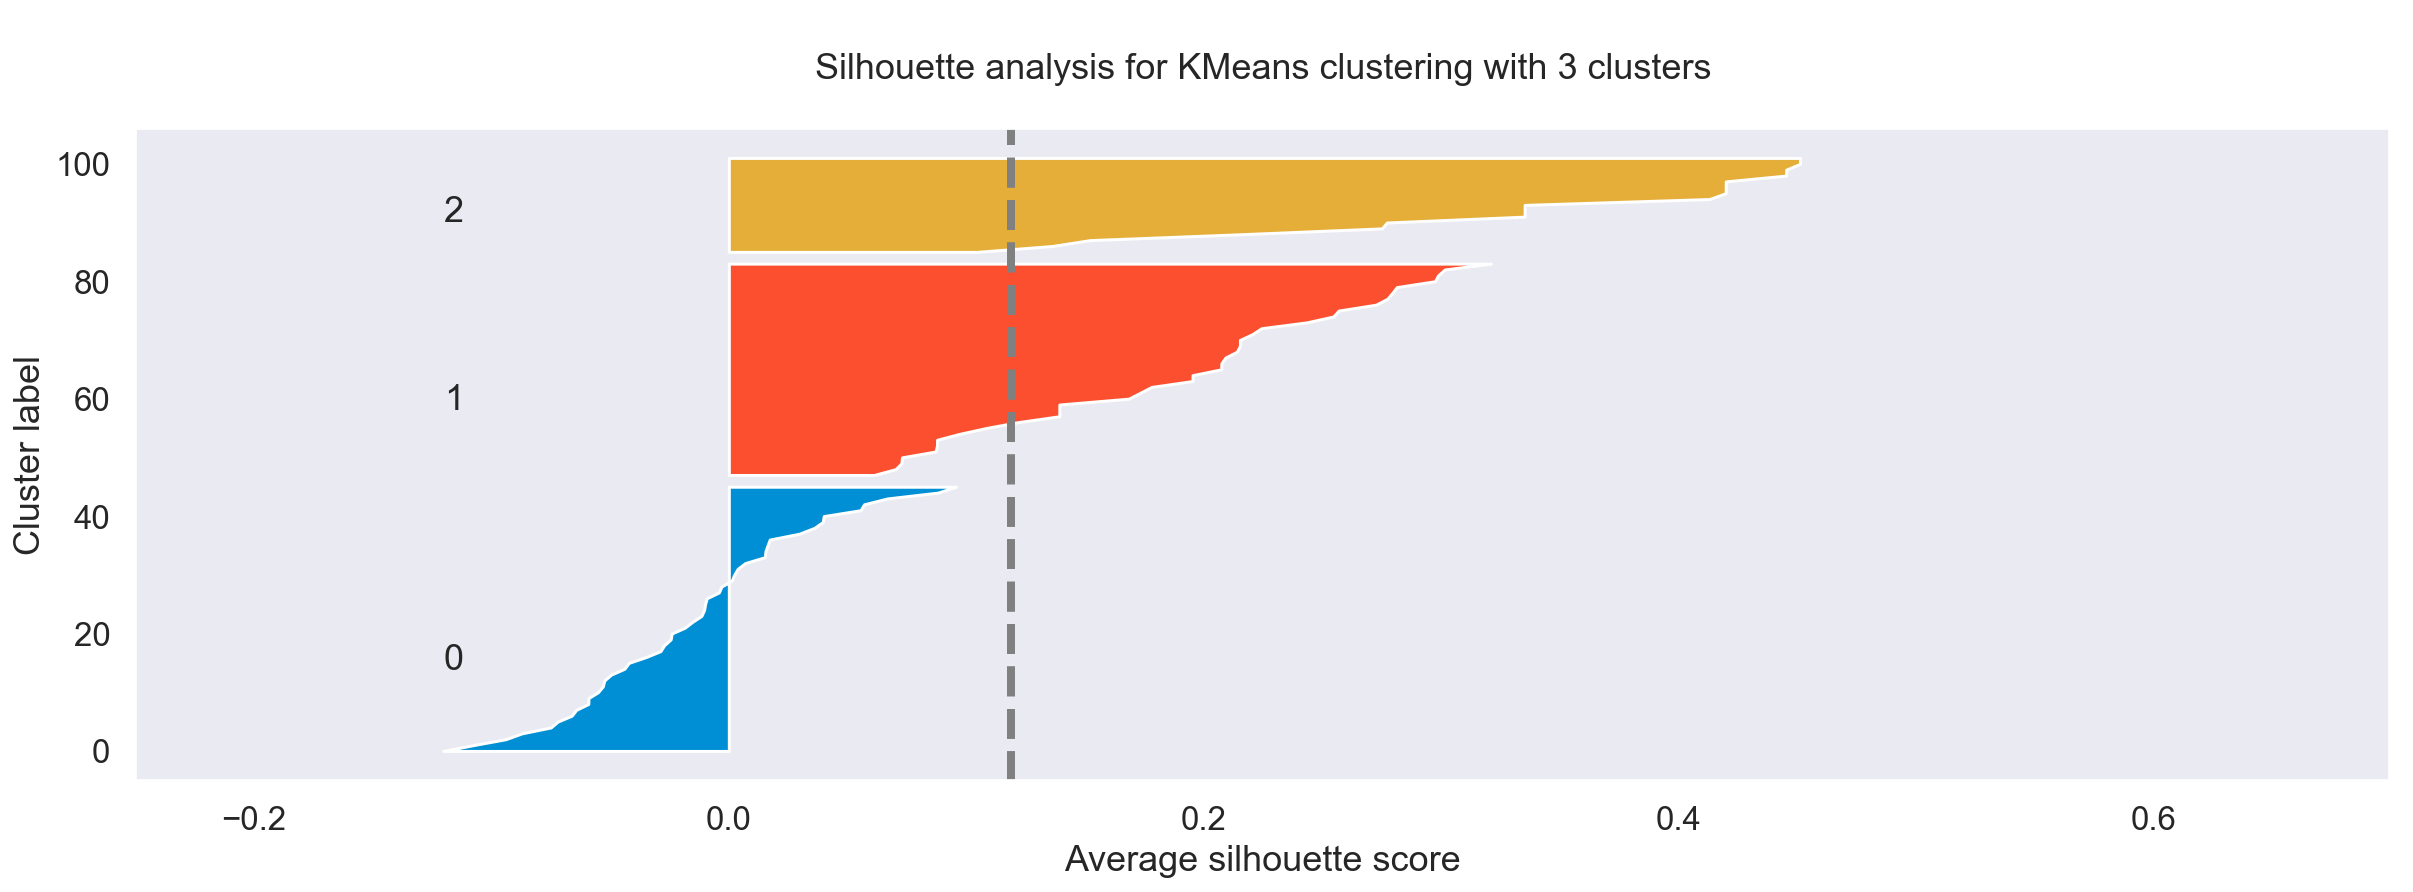

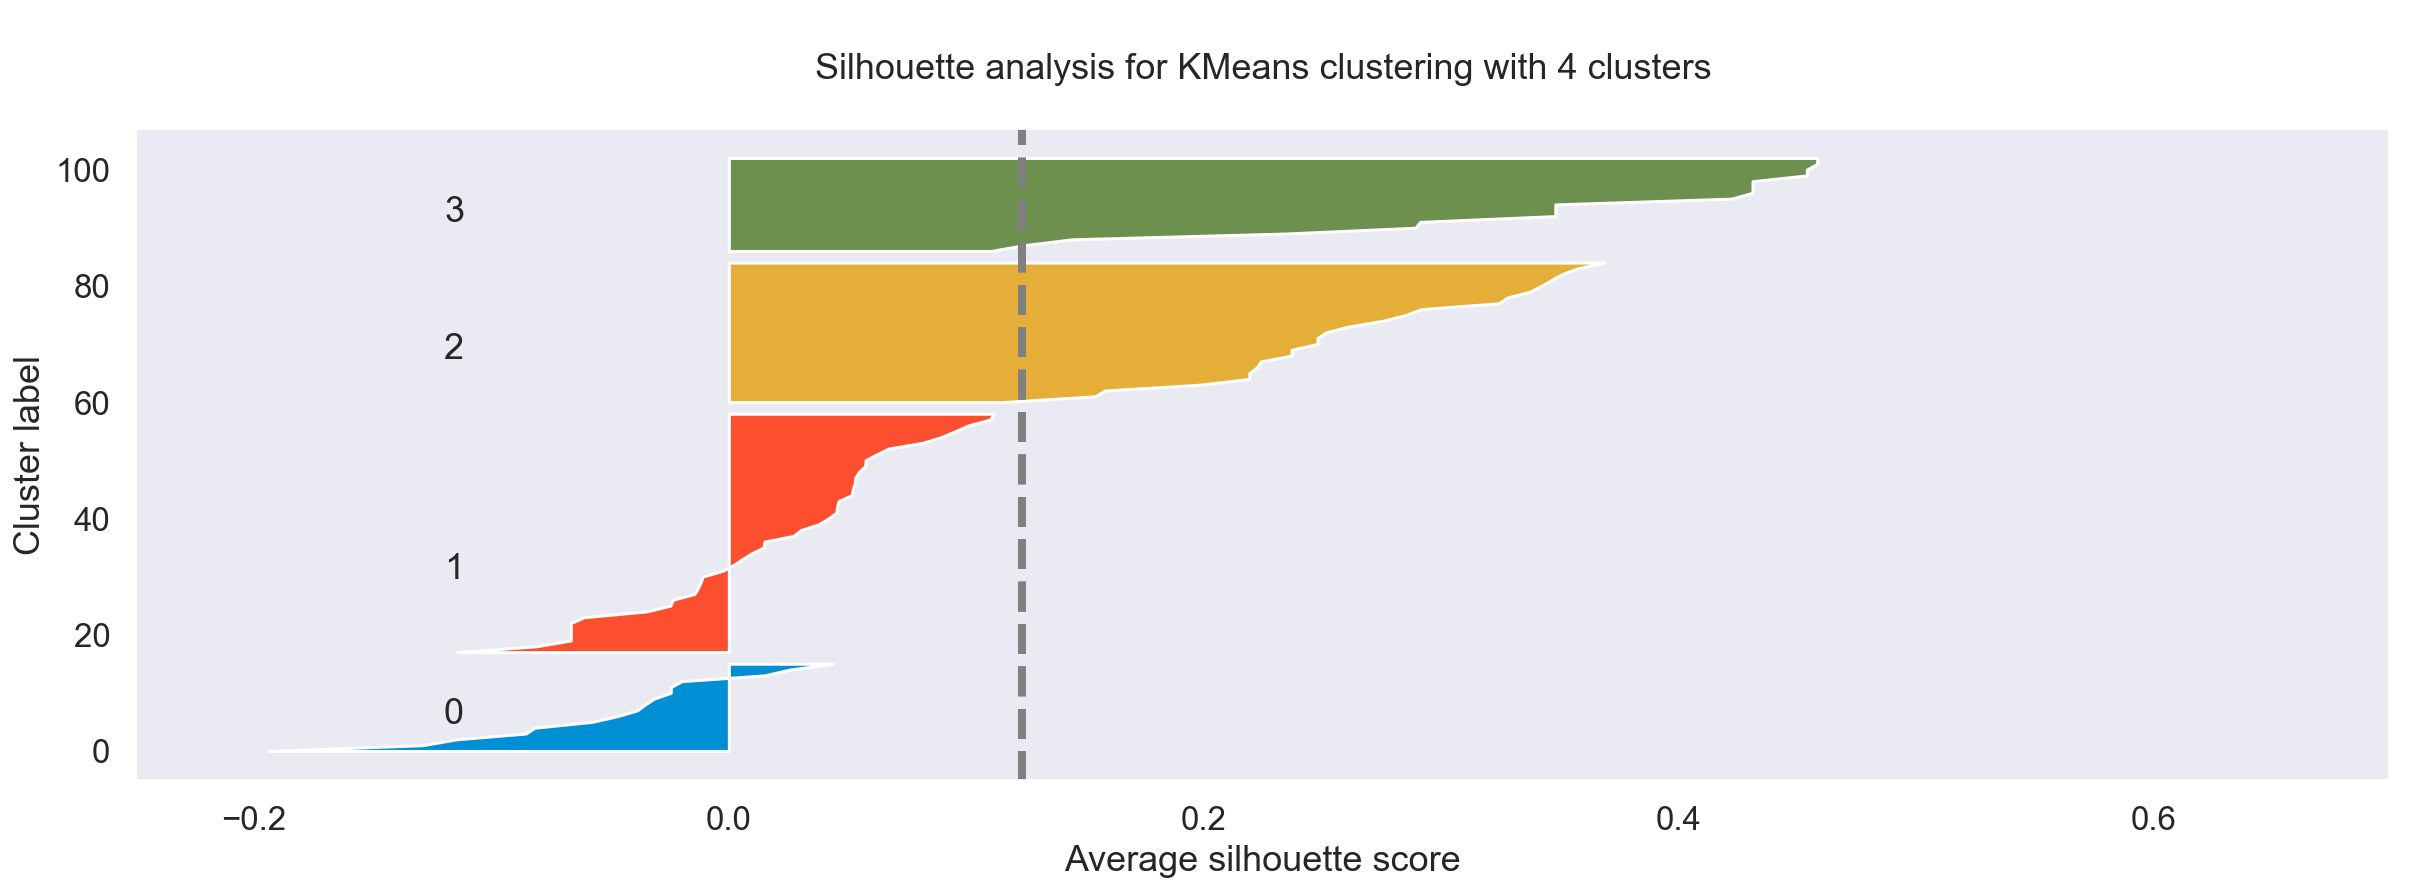

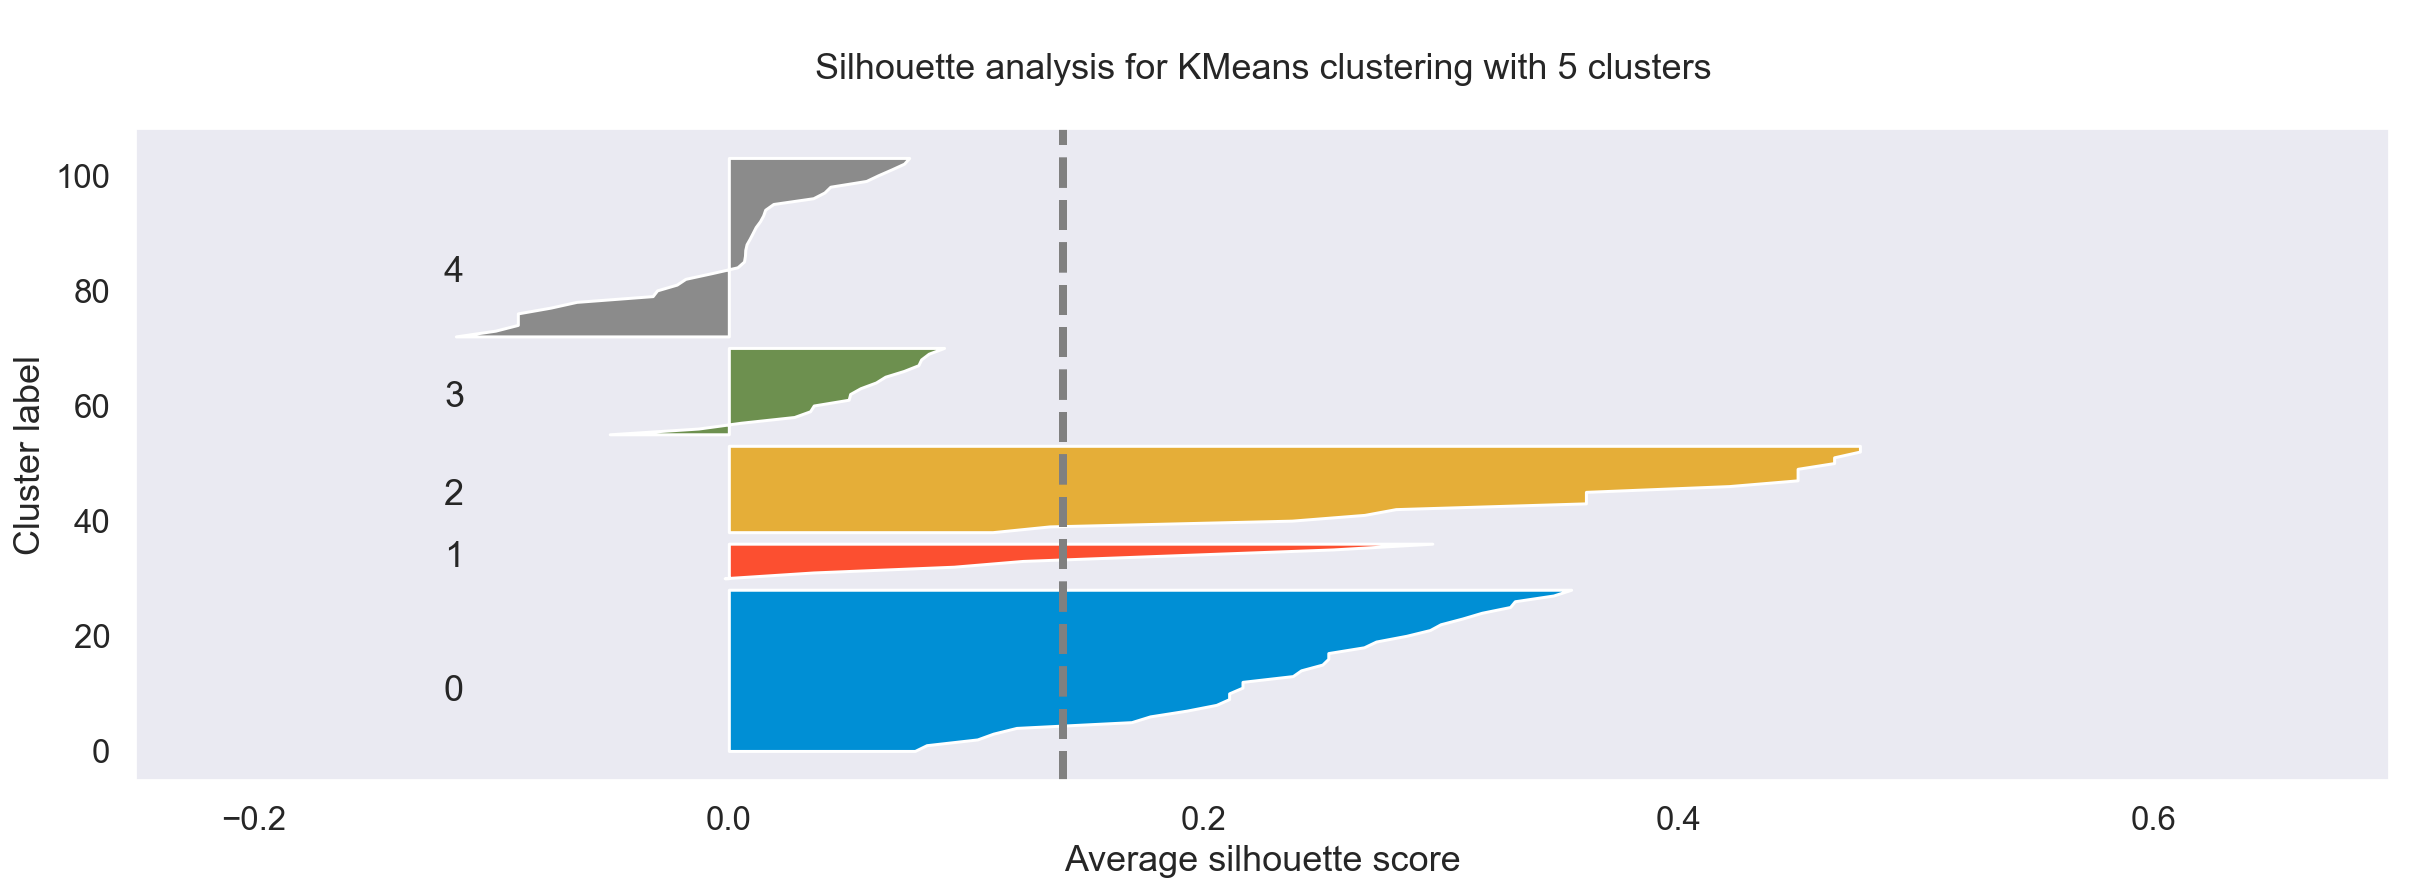

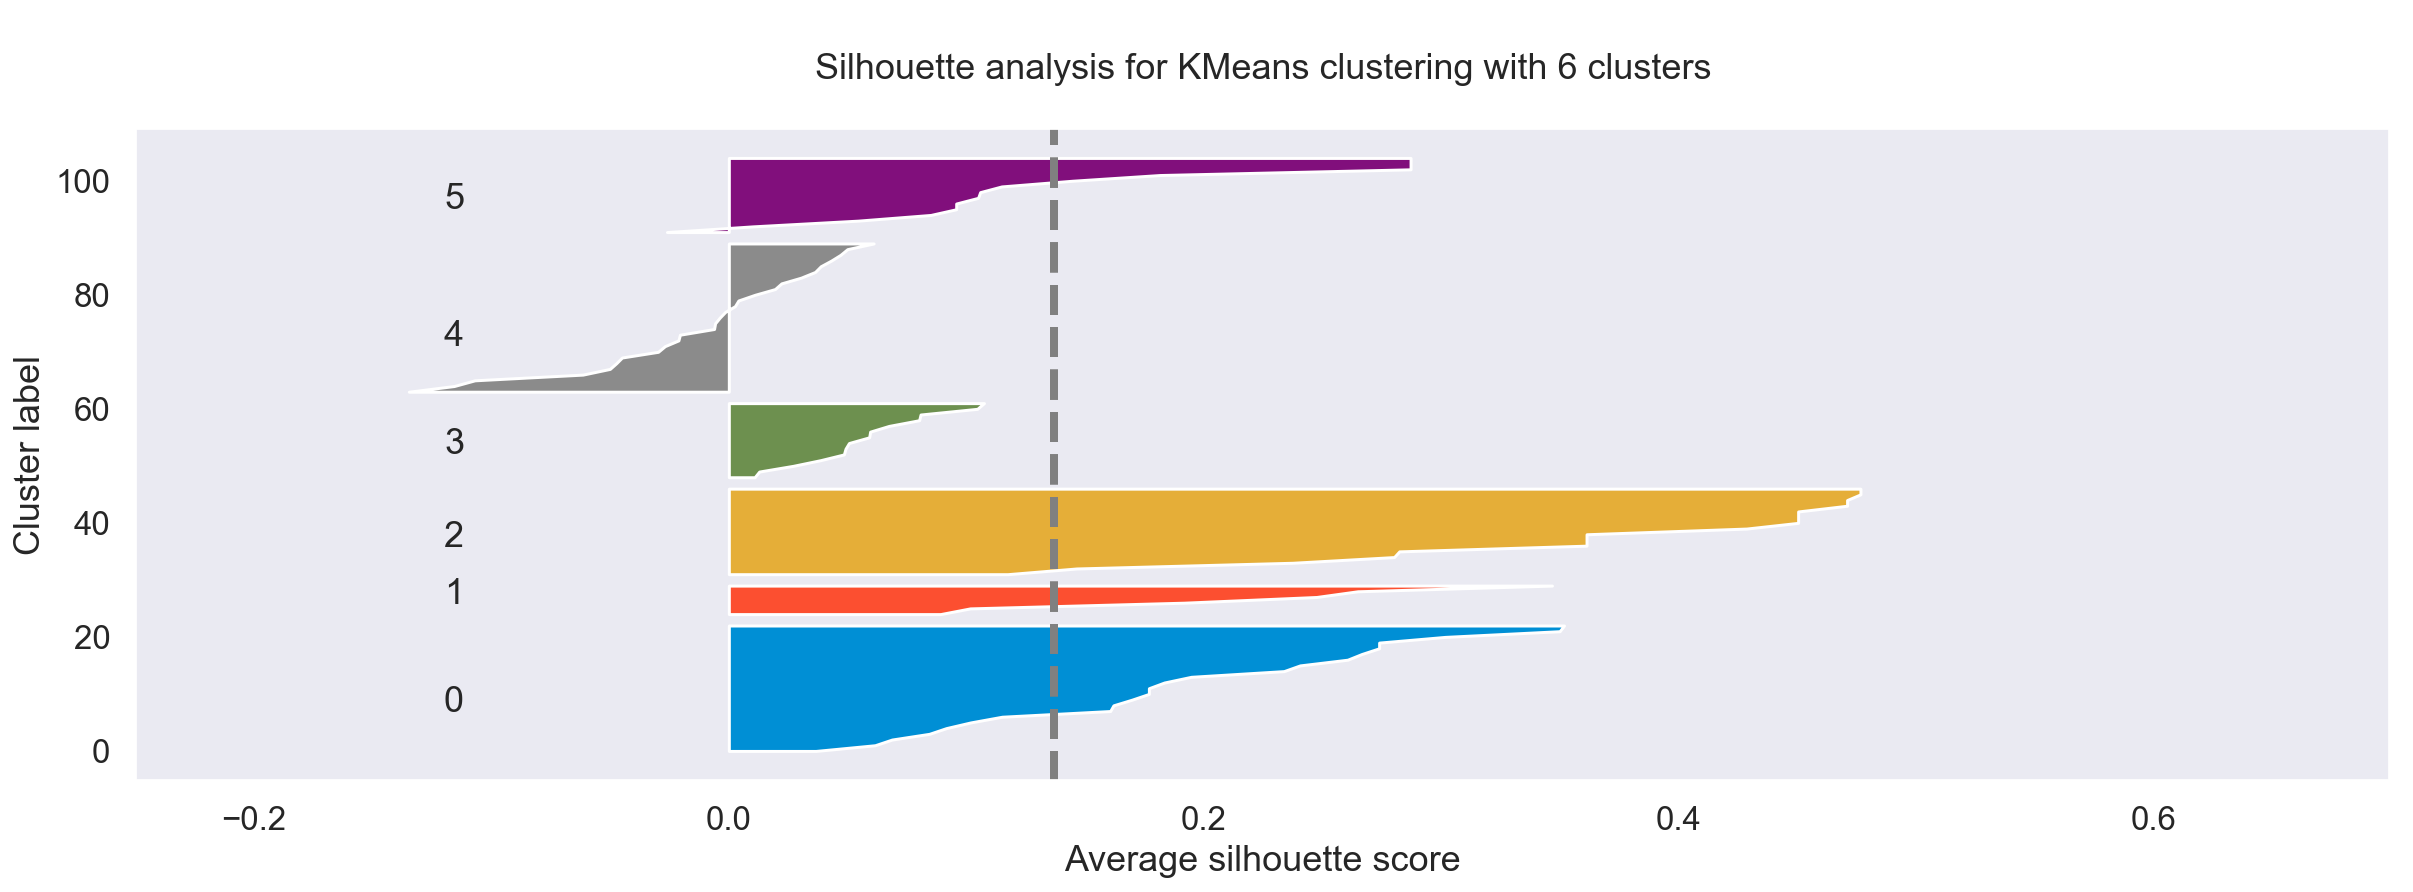

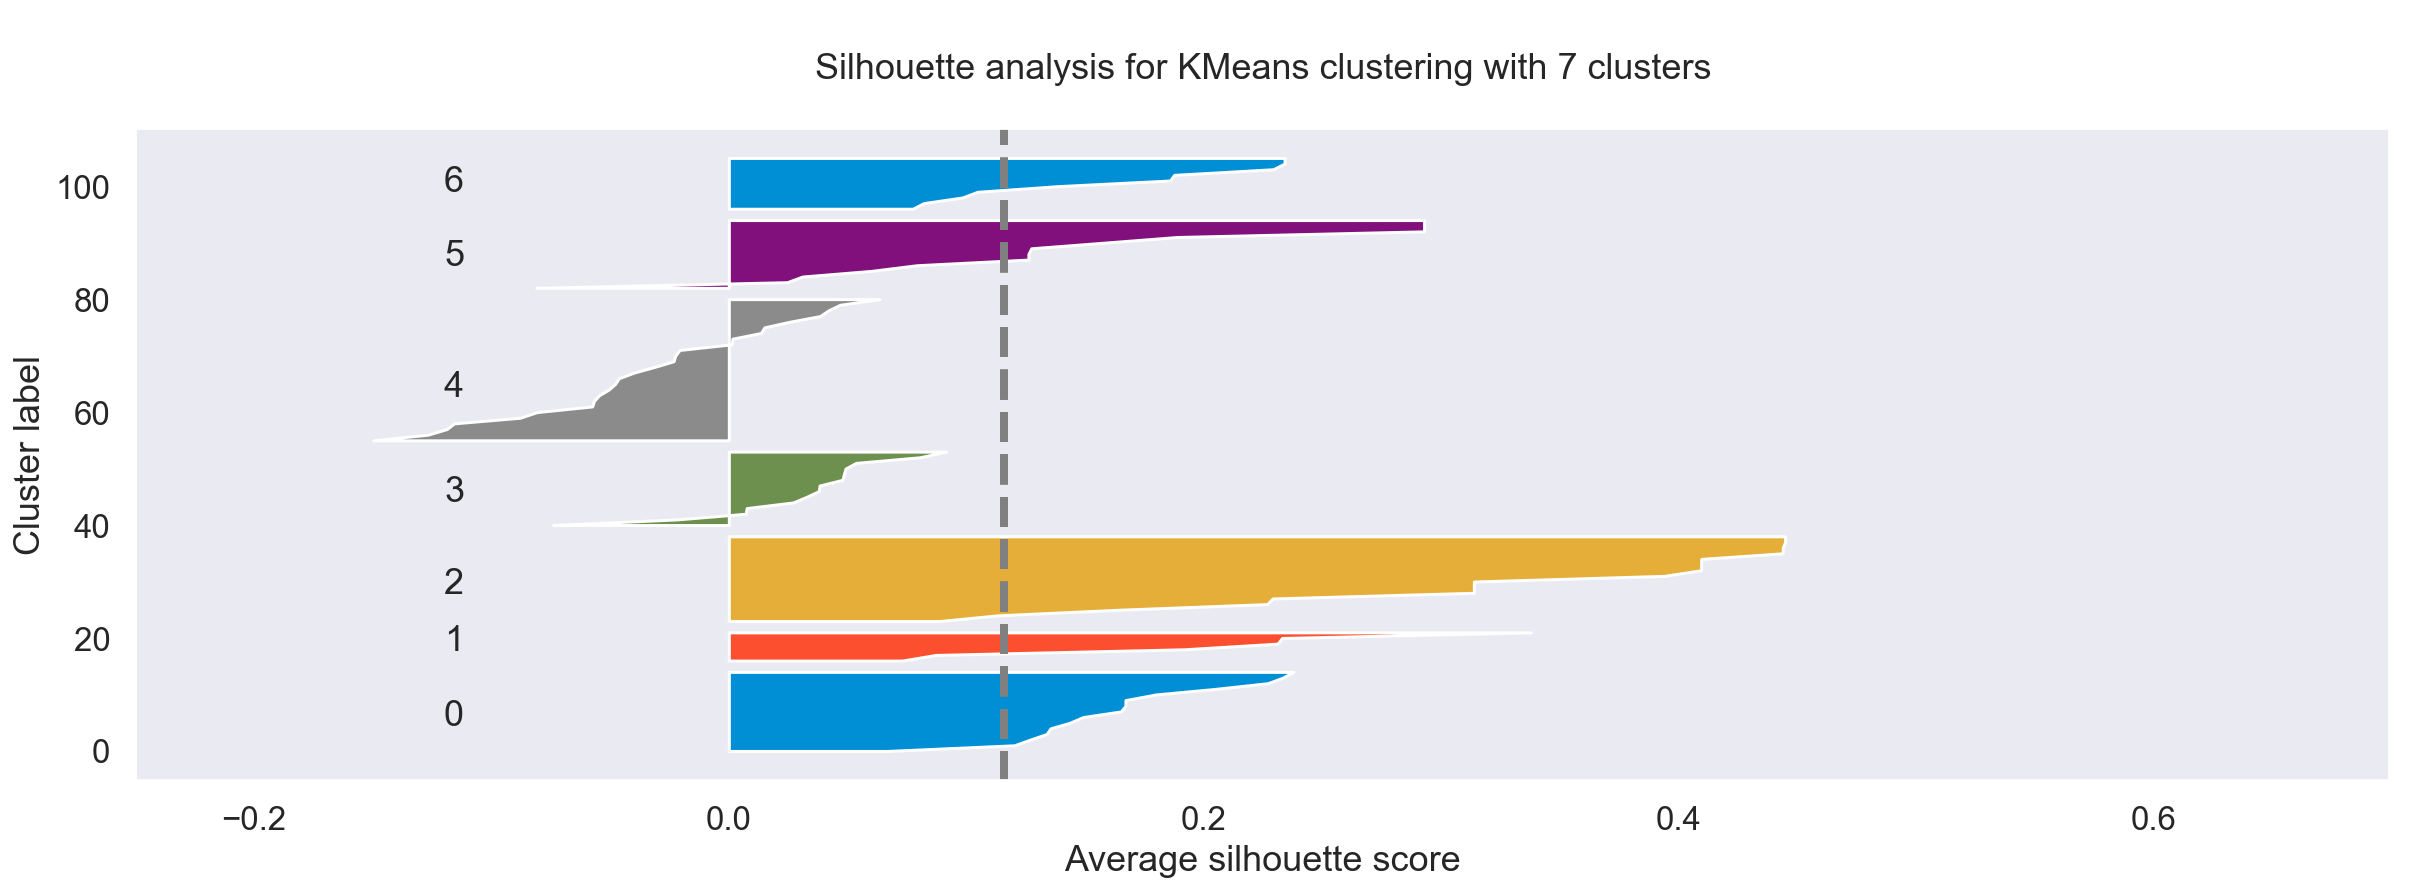

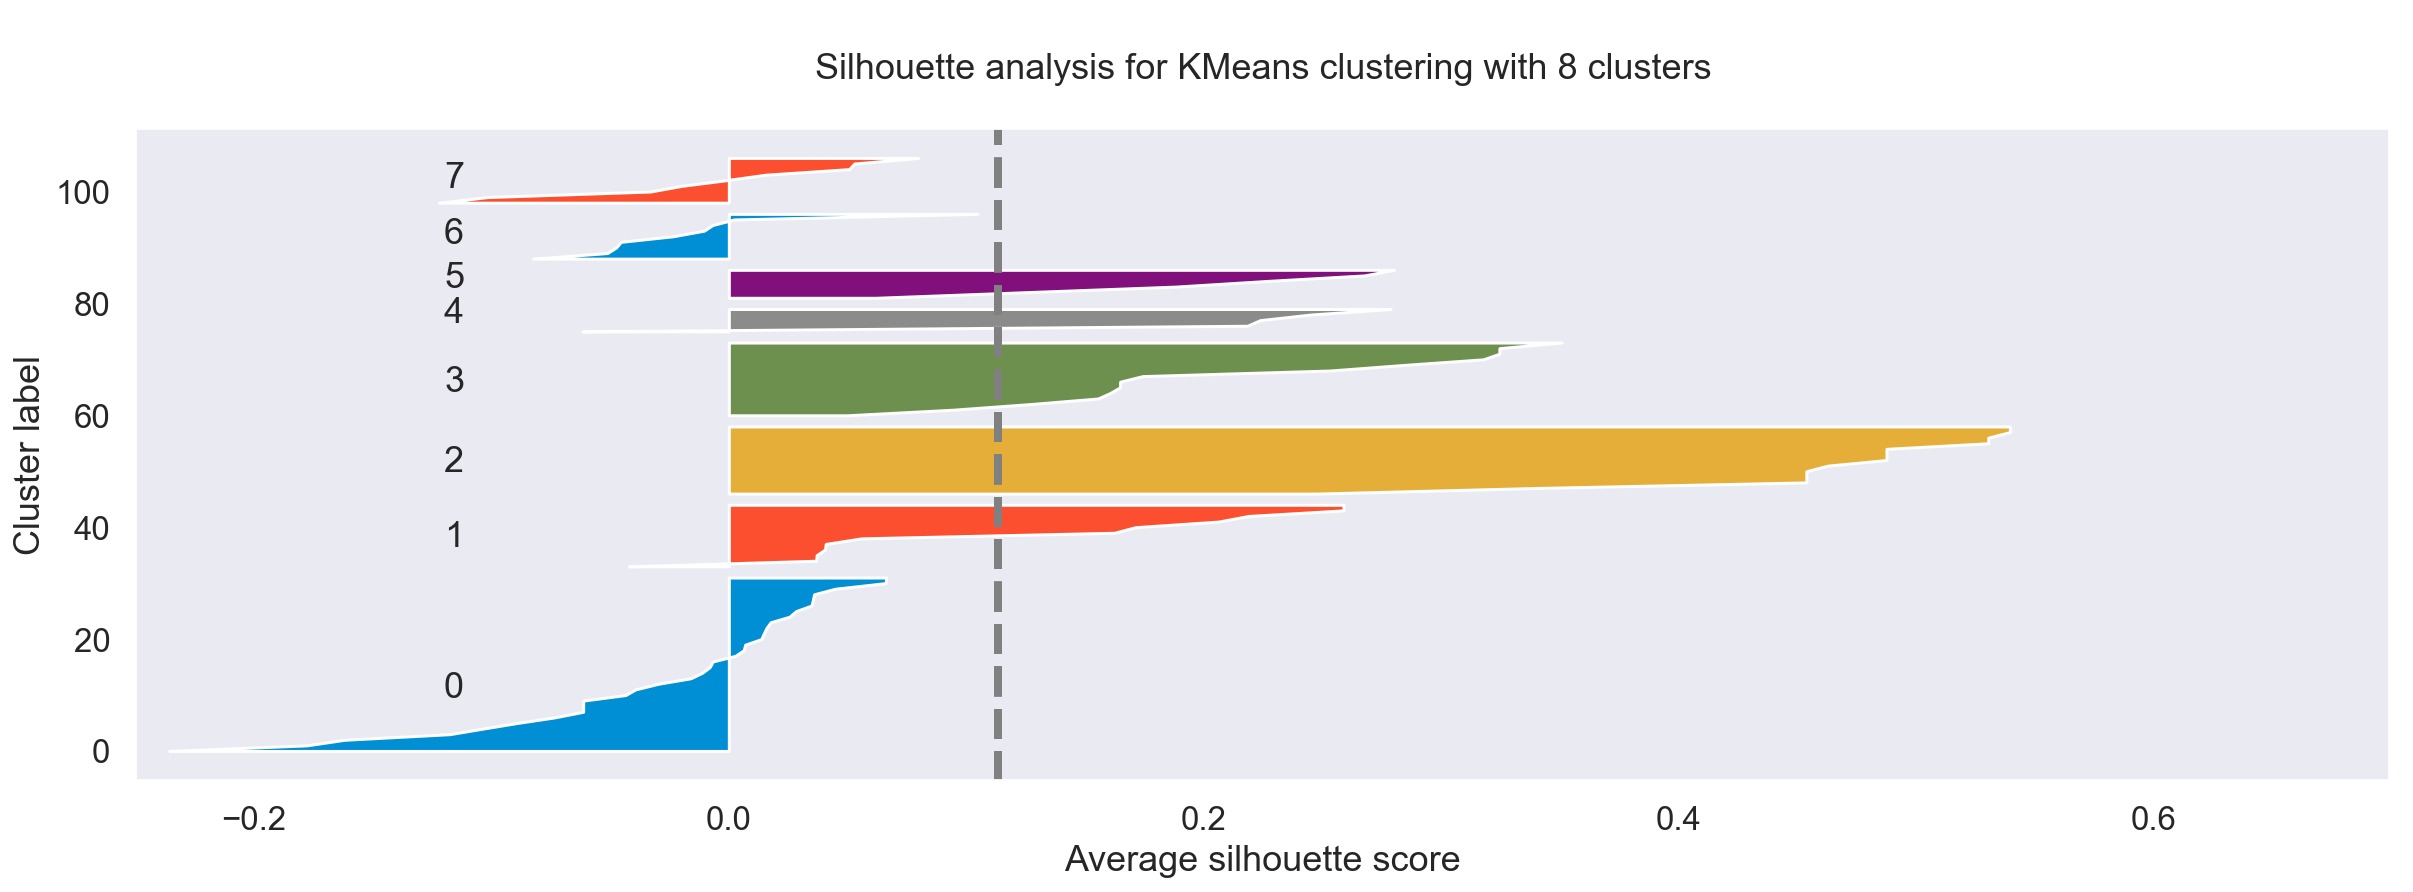

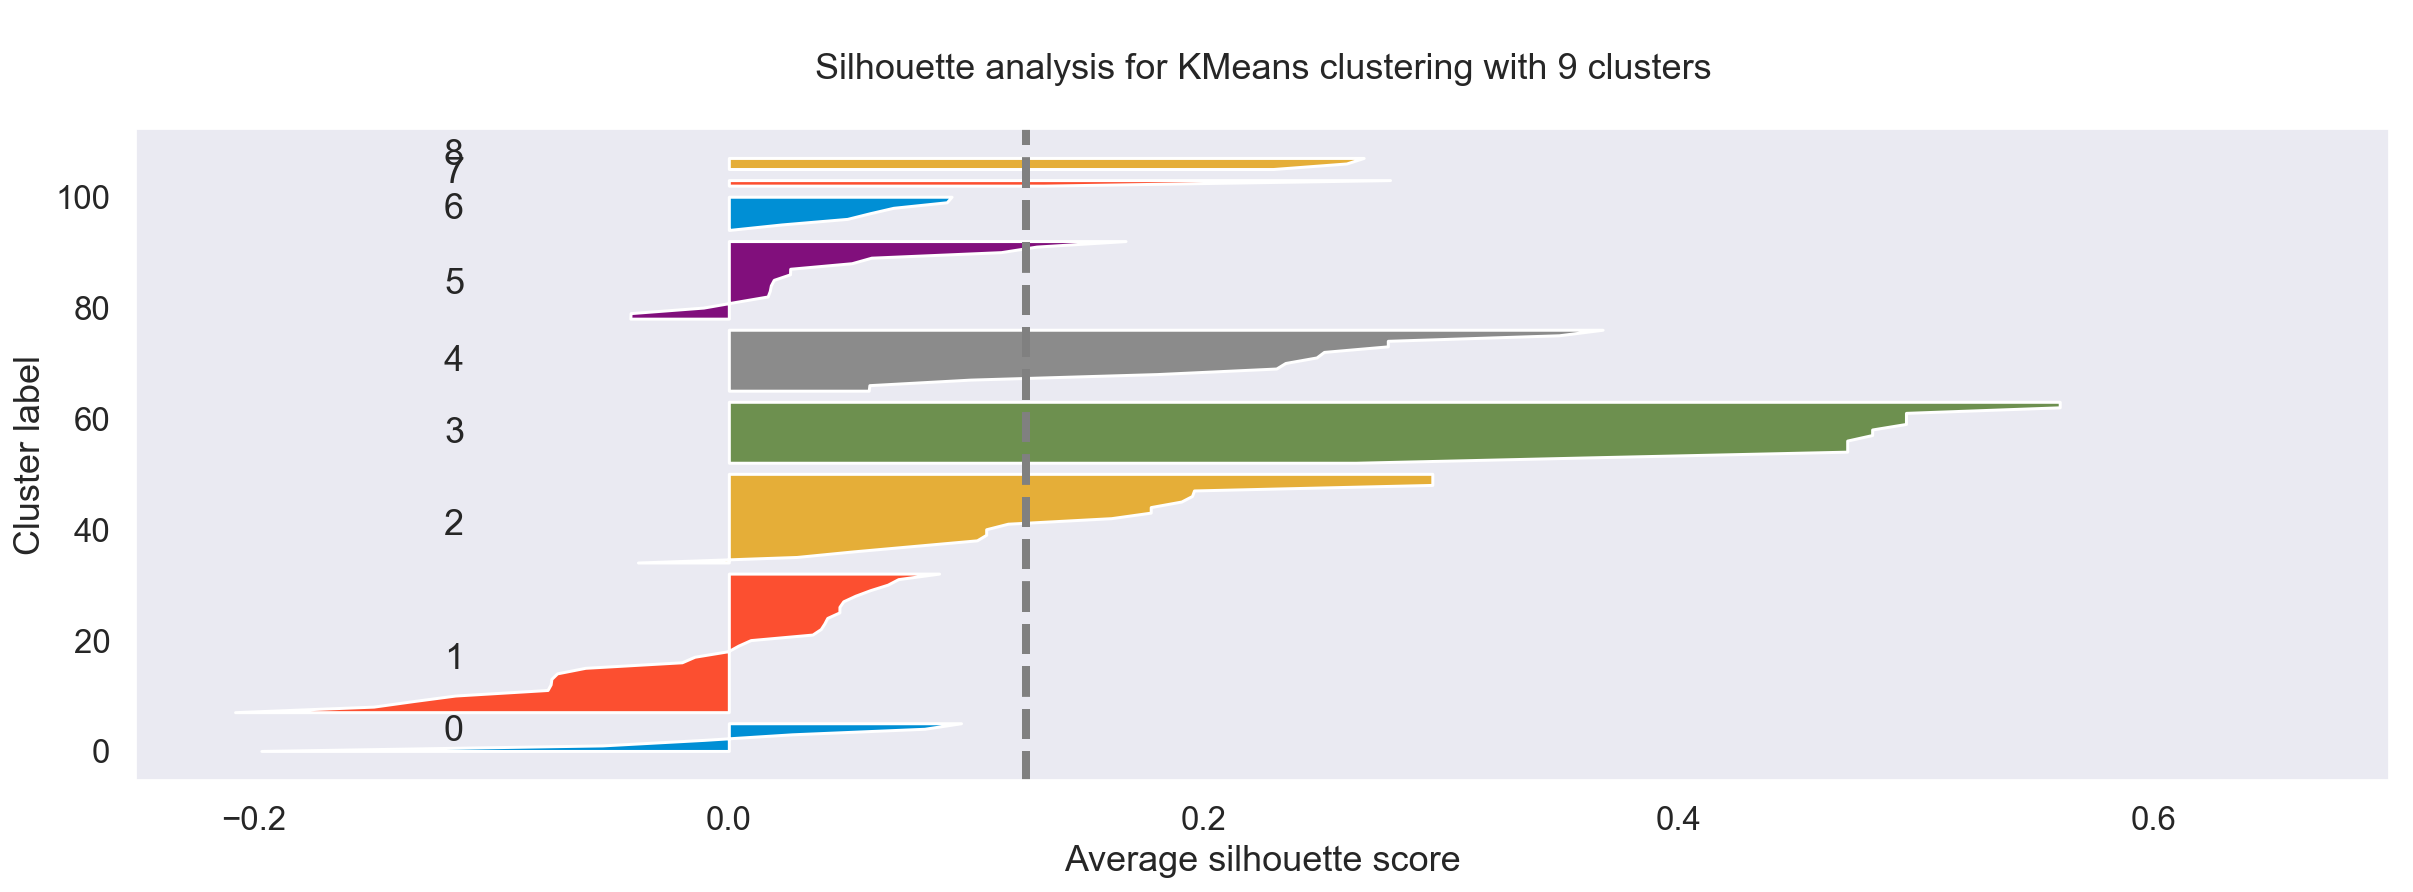

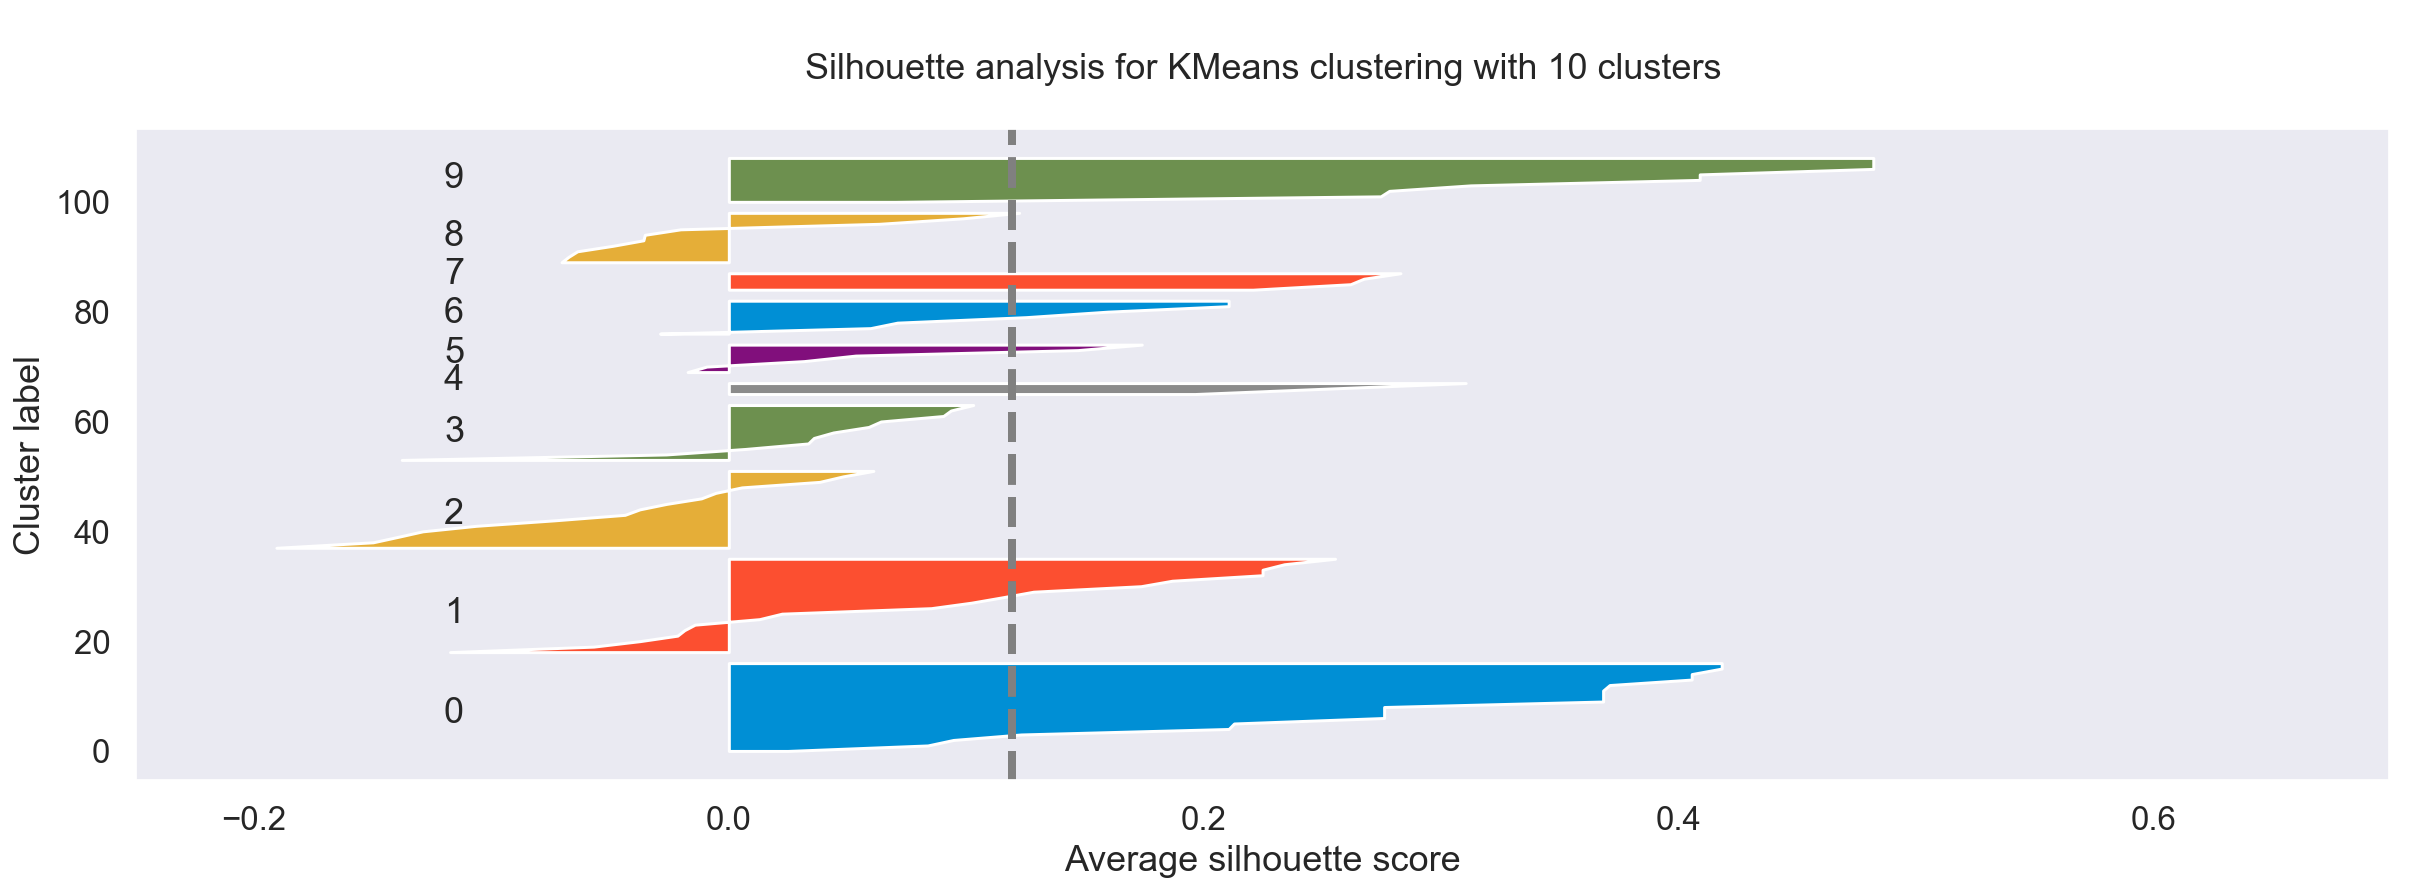

In [24]:
# set random seed to replicate results
#np.random.seed(88)

# set context for plots
sns.set_context("talk", font_scale=1, rc={"lines.linewidth": 4})

# number of clusters to try
clusters = range(2,11)
avg_scores = []

# compute average silhouette score for each cluster number in the clusters list and plot it
for n in clusters:
    # set parameters for each plot
    fig, ax = plt.subplots(1,1)
    _=fig.set_size_inches(18, 6)
    _=ax.set_xlim([-0.25, .7])
    
    # initialize the kmeans cluster
    km = KMeans(n_clusters=n, random_state=10)#10
    # fit and predict the model on the customers data
    km_predict=km.fit_predict(x_cols)
    
    # the silhouette_score gives the average value for all the samples.
    s_score = silhouette_score(x_cols, km_predict)
    avg_scores.append(s_score)
    
    #silhouette scores for each sample
    s_samples = silhouette_samples(x_cols, km_predict)
    
    # set y-axis lower limit
    y_lower = 0
    
    # create silhouette plots for different cluster values
    for i in range(n):
        # Aggregate the silhouette scores for samples belonging to
        # each cluster run and sort them
        cluster_values = s_samples[km_predict == i]
        cluster_values.sort()
        
        # set upper limit of y-axis
        cluster_size = len(cluster_values)
        y_upper = y_lower + cluster_size
        
        # silhouette plot
        _=ax.fill_betweenx(np.arange(y_lower,y_upper),0,cluster_values)
        _=ax.text(-0.12, y_lower + 0.3 * cluster_size, str(i))
        
        # create a space between clusters in the plot
        _=y_lower = y_upper + 1
        
        # show the average silhouette score of all the values
        _=ax.axvline(x=s_score, color="grey", linestyle="--")
        
        # set labels
        _=ax.set_title("\nSilhouette analysis for KMeans clustering with %d clusters\n"%(n))
        _=ax.set_xlabel("Average silhouette score")
        _=ax.set_ylabel("Cluster label")

The plots shows that all the K values under performed and the algorithm wasn't able to accurately separate customers into distinct groups. There are clusters with below average silhouette scores in all the plots and the size of the silhouette plots are uneven.

#### Choosing K using the average silhouette scores

<p>Using the <code>avg_scores</code> list created above with the average silhouette scores, the following plot is used to determine the 'optimal' number of clusters for customer segmentation.</p>

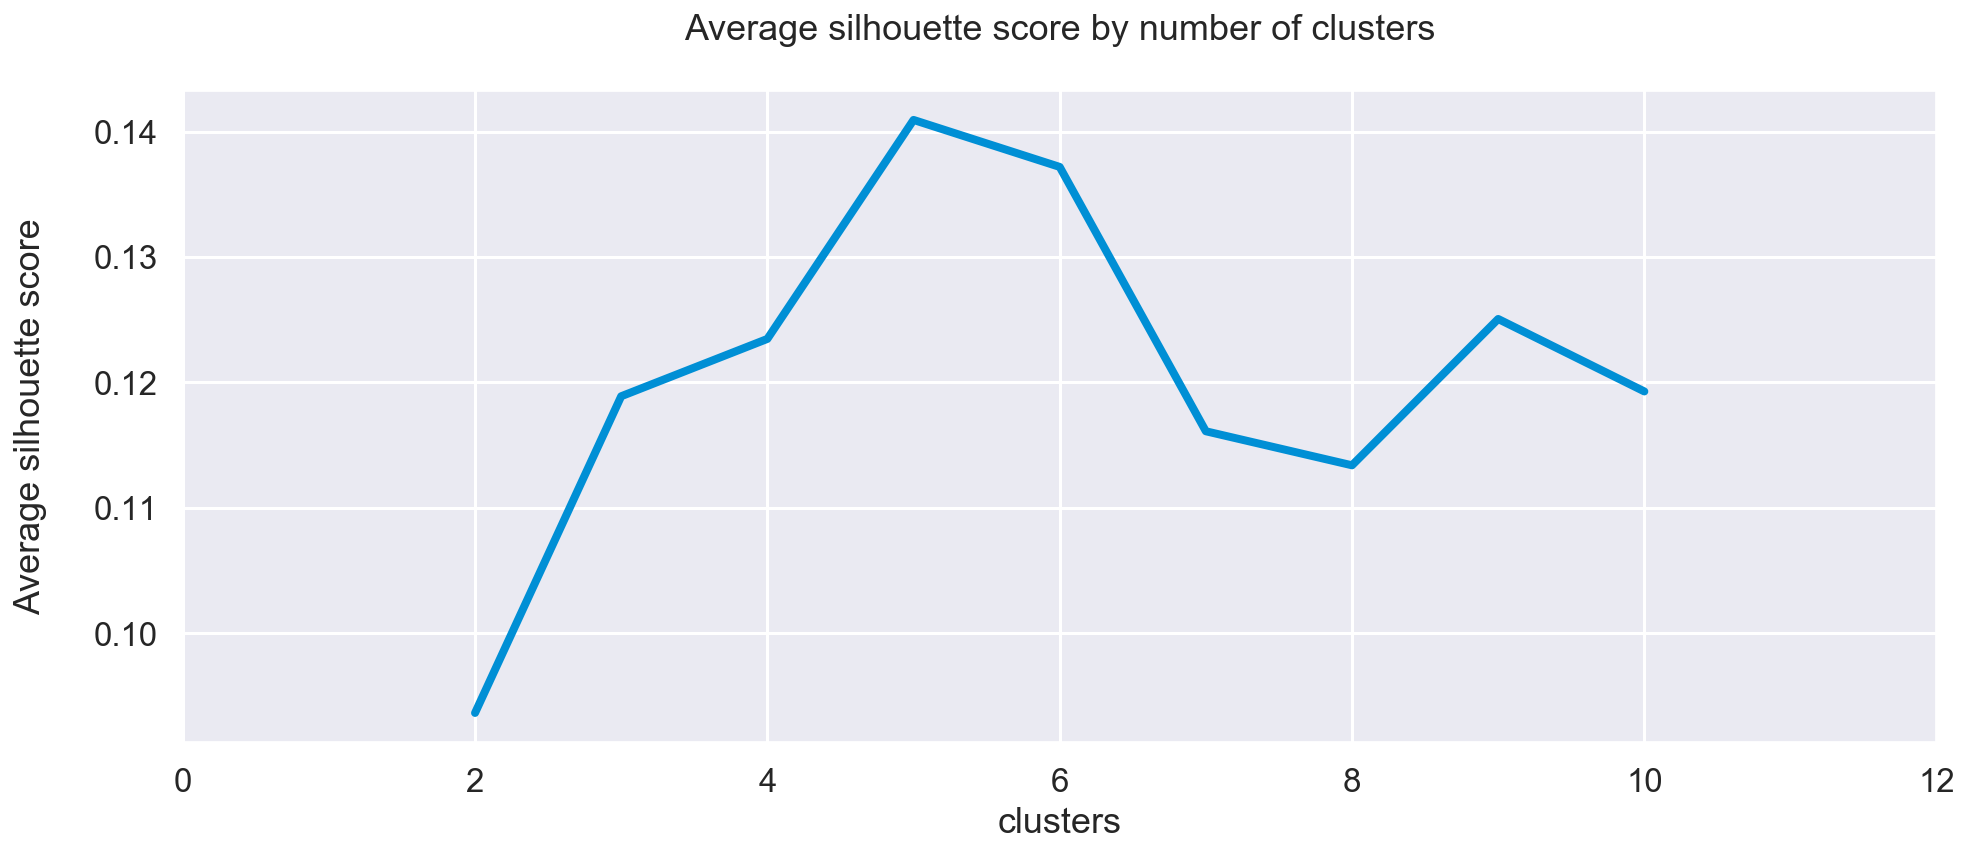

In [25]:
# reset figure parameters
_=plt.rcParams['figure.figsize'] = [14,6]
_=sns.set_style("darkgrid")

# plot avg silohoutte score for each cluster
_=sns.lineplot(clusters, avg_scores)
_=plt.xlim(0,12)
_=plt.title('Average silhouette score by number of clusters\n')
_=plt.ylabel('Average silhouette score\n')
_=plt.xlabel('clusters')
_=sns.set_style("dark")

<p>The lineplot suggests that the 'optimal' number of cluster is 5, since this is the largest coefficient. However, the low value (0.14) confirms that no substantial structure has been found, as shown by the clusters with below average silhouette scores in all the silhouette plots.</p>
<p>The number of clusters found using this method differs from the one found using the 'Elbow' method.</p>

### Choosing $K$ - The Gap Statistic

<p>There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:</p>

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

<p>In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute:</p>

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

<p>Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.</p>

<a id='pca'></a>

## Visualizing Clusters using PCA
<p>When the data we're working with has two features, the clusters can be easily visualized. However, the wine marketing campaign has 100 records and 32 features (dimensions), one for each offer. In this case, the Principal Component Analysis (PCA) can be used to reduce the number of dimensions.</p>
<p>PCA can also be used when running regression with highly correlated variables by reducing the number of features to ones that are not correlated.</p>

<a id='pca2'></a>

### Feature reduction with PCA - 2 components

In [26]:
#import PCA module
from sklearn.decomposition import PCA

# set the number of dimensions to 2
pca = PCA(n_components=2, random_state=8)

#use the marketing dataset using the PCA-reduced data
marketing['x'] = pca.fit_transform(marketing[col_names])[:,0]
marketing['y'] = pca.fit_transform(marketing[col_names])[:,1]


In [27]:
# create a compy of the merged data to add the PCA components
pca_segmentation = marketing[['customer_name','predict_cluster','x','y']]
pca_segmentation.head()

offer_id,customer_name,predict_cluster,x,y
0,Adams,0,1.007580,0.108215
1,Allen,1,-0.287539,0.044715
2,Anderson,2,-0.392032,1.038391
3,Bailey,0,0.699477,-0.022542
4,Baker,1,0.088183,-0.471695


### K-Means clustering on wine marketing campaign visualization

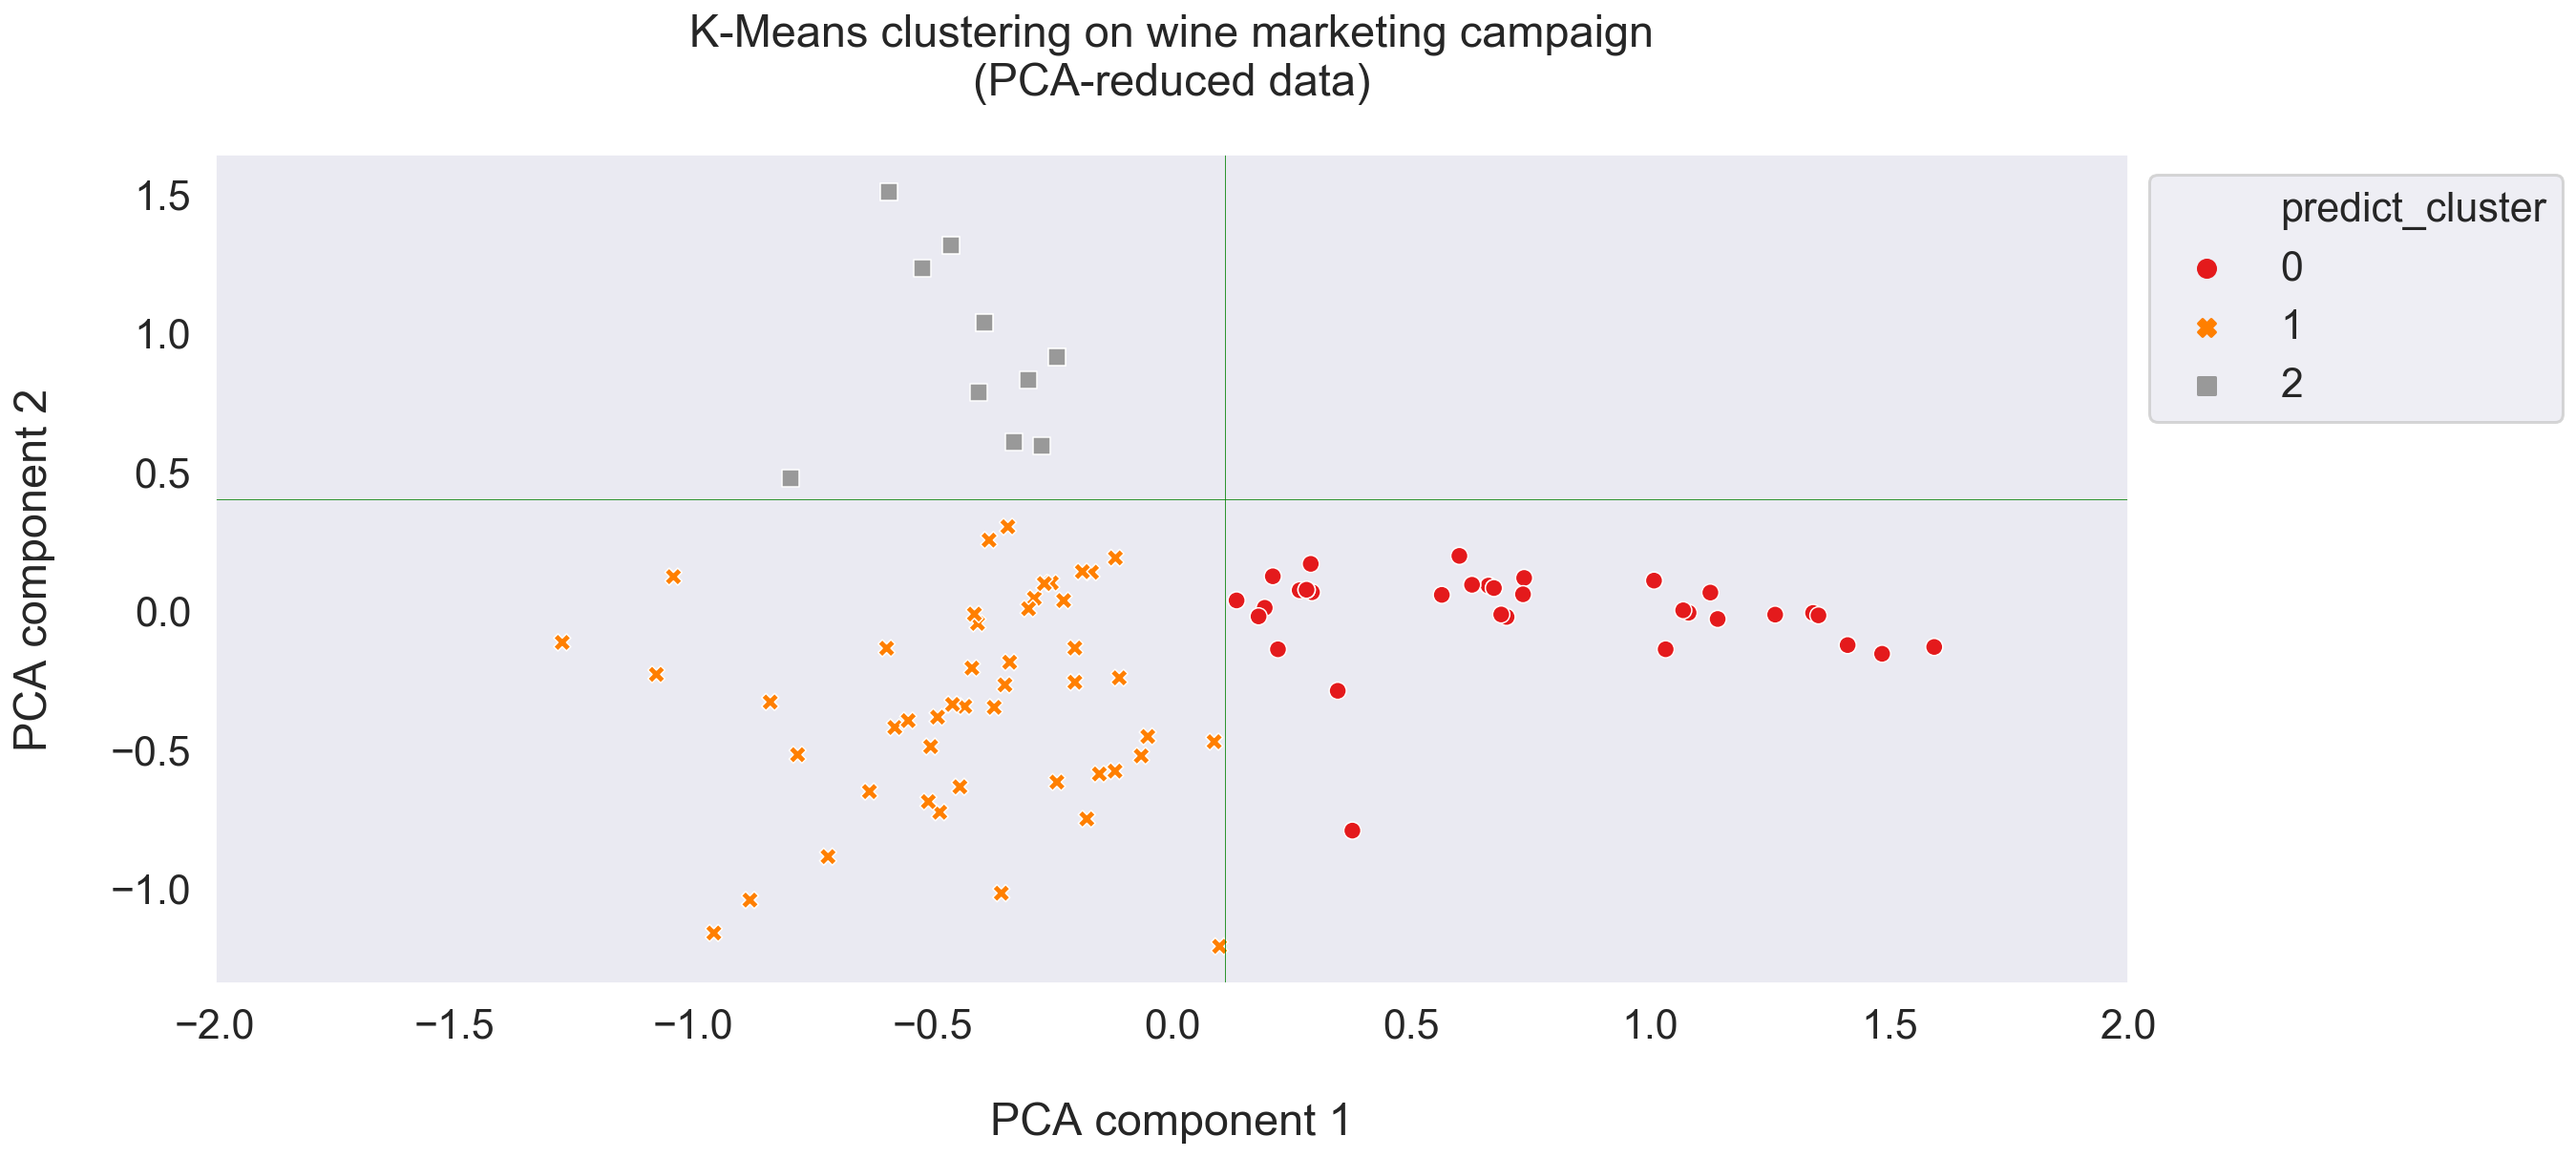

In [28]:
_=plt.rcParams['figure.figsize'] = [16,8]
sns.set_context("talk", font_scale=1.3, rc={"lines.linewidth": .4}, )
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)

#plot the featured reduced data by cluster.
_=sns.scatterplot(x = 'x', y ='y', hue='predict_cluster', data = pca_segmentation,style='predict_cluster',palette="Set1")
_=plt.xlim(-2,2)
_=plt.legend(bbox_to_anchor=(1, 1), loc=2, title_fontsize=20)
_=plt.axhline(0.4, color="green")
_=plt.axvline(0.11, color="green")
_=plt.title('K-Means clustering on wine marketing campaign\n(PCA-reduced data)\n')
_=plt.xlabel('\nPCA component 1')
_=plt.ylabel('PCA component 2\n')

The k-means clustering method used at the beginning of the analysis creates three distinct segments. However, cluster 0 and 1 are very close to each other, with two data points from cluster 1 and 1 from cluster 0 sitting very close to the decision boundary between the two clusters. 

<a id='edaclusters'></a>

# EDA with clusters

In [29]:
customer_segmentation = pd.merge(df, pca_segmentation)

In [30]:
customer_segmentation.head(2)

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak,predict_cluster,x,y
0,Smith,2,1,January,Pinot Noir,72,17,France,False,2,-0.300227,0.829765
1,Smith,24,1,September,Pinot Noir,6,34,Italy,False,2,-0.300227,0.829765


<a id='mpc'></a>

## Most popular variety by cluster

Using the data with the cluster label, we're interested to see if there are distinct pattterns among clusters.

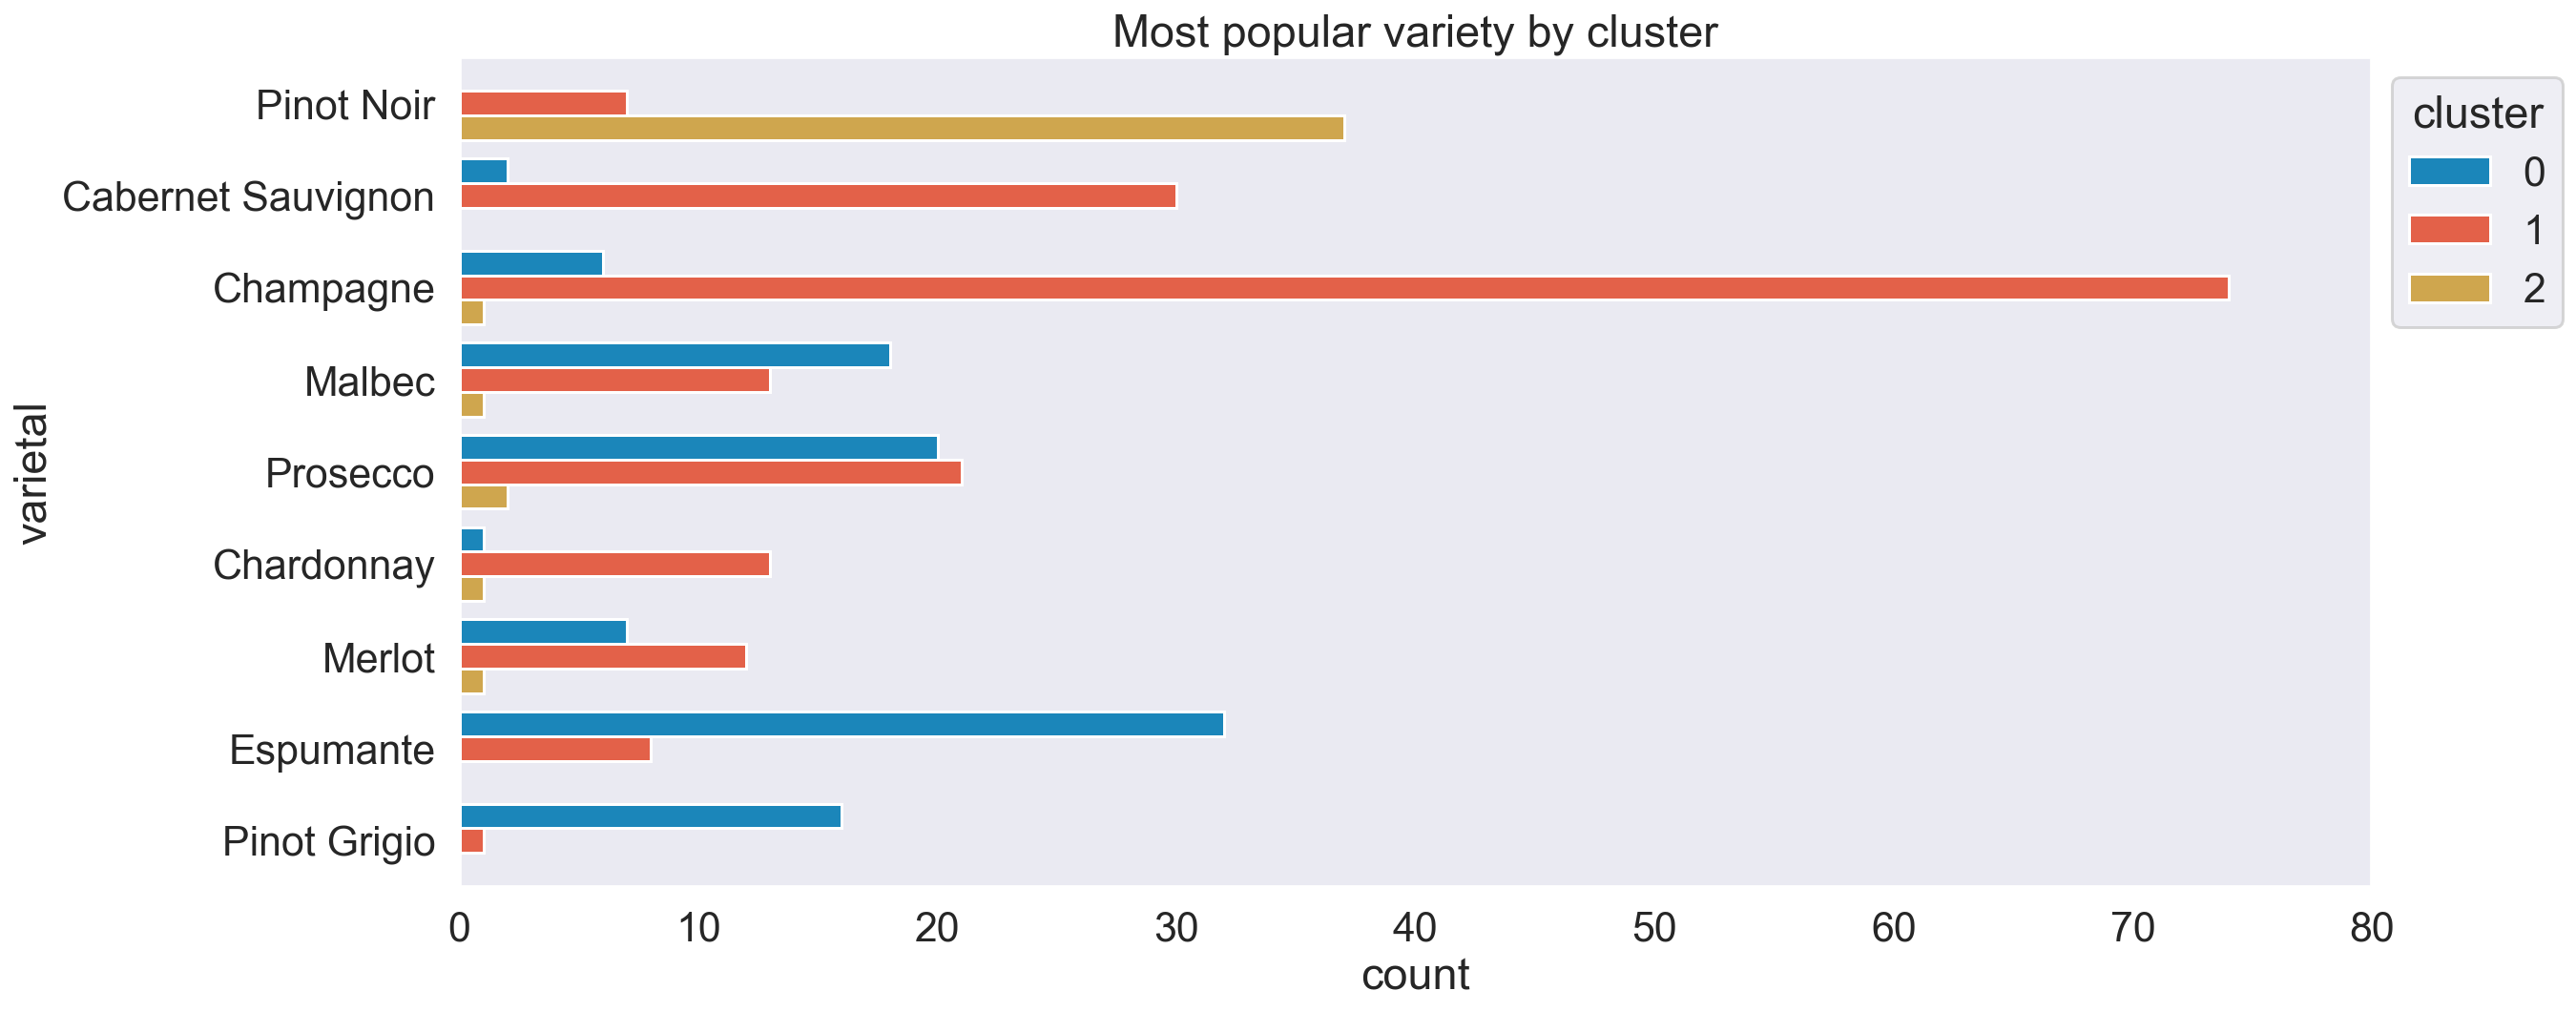

In [31]:
#plot variety by cluster
_=sns.countplot(y='varietal', hue= 'predict_cluster',data = customer_segmentation)
_=plt.legend(bbox_to_anchor=(1, 1), loc=2, title= 'cluster')
_=plt.title('Most popular variety by cluster')
_=plt.xlim(0,80)
_=plt.xlabel('count')

The bar plot shows that champagne and Prosecco are the most popular varieties for cluster 1, while cluster 2 is mainly Pinot Noir, and there is not a distinct wine variety for cluster 0, as these customers responded to most offers. 

<a id='cmc'></a>

## Clusters by campaign month

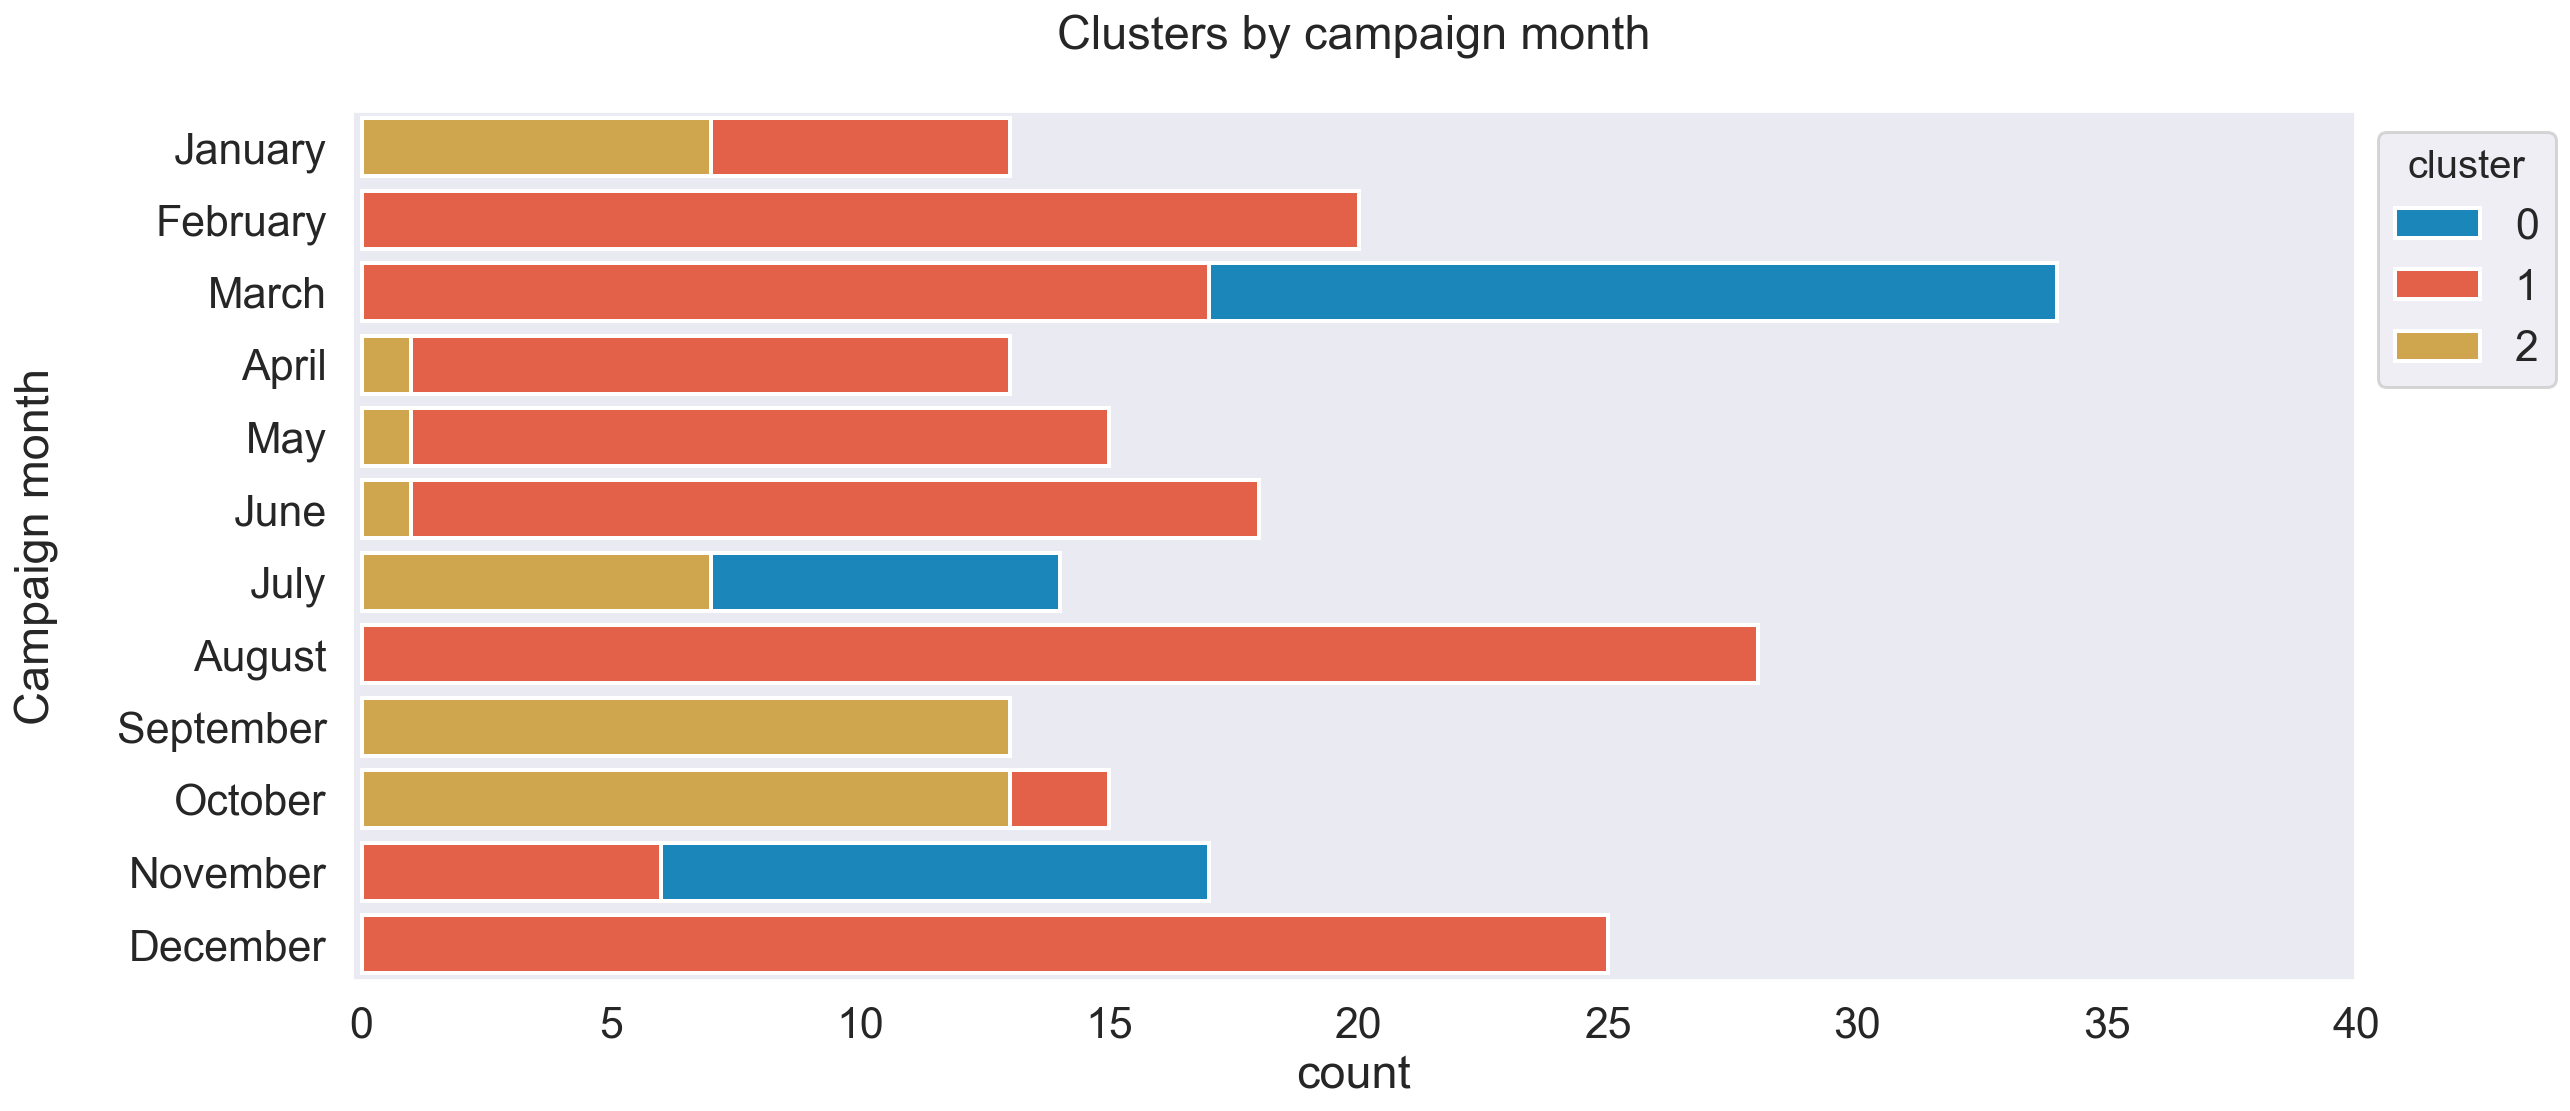

In [32]:
# create a list to order y-axis
months = ['January','February','March','April','May','June','July','August','September','October','November','December']
#plot cluster by campaign month
_=sns.countplot(y='campaign', hue= 'predict_cluster',data = customer_segmentation, linewidth=2, dodge=False, order = months)
_=plt.legend(bbox_to_anchor=(1, 1), loc=2, title= 'cluster', title_fontsize=20)
_=plt.xlim(-0.2,40)
_=plt.title('Clusters by campaign month\n')
_=plt.ylabel('Campaign month\n')

Customers in cluster 1 were the only ones that responded to the February, August and December campaigns. The responses for the March campaign were evenly distributed between cluster 0 and cluster 1.

## Minimum quantity by cluster

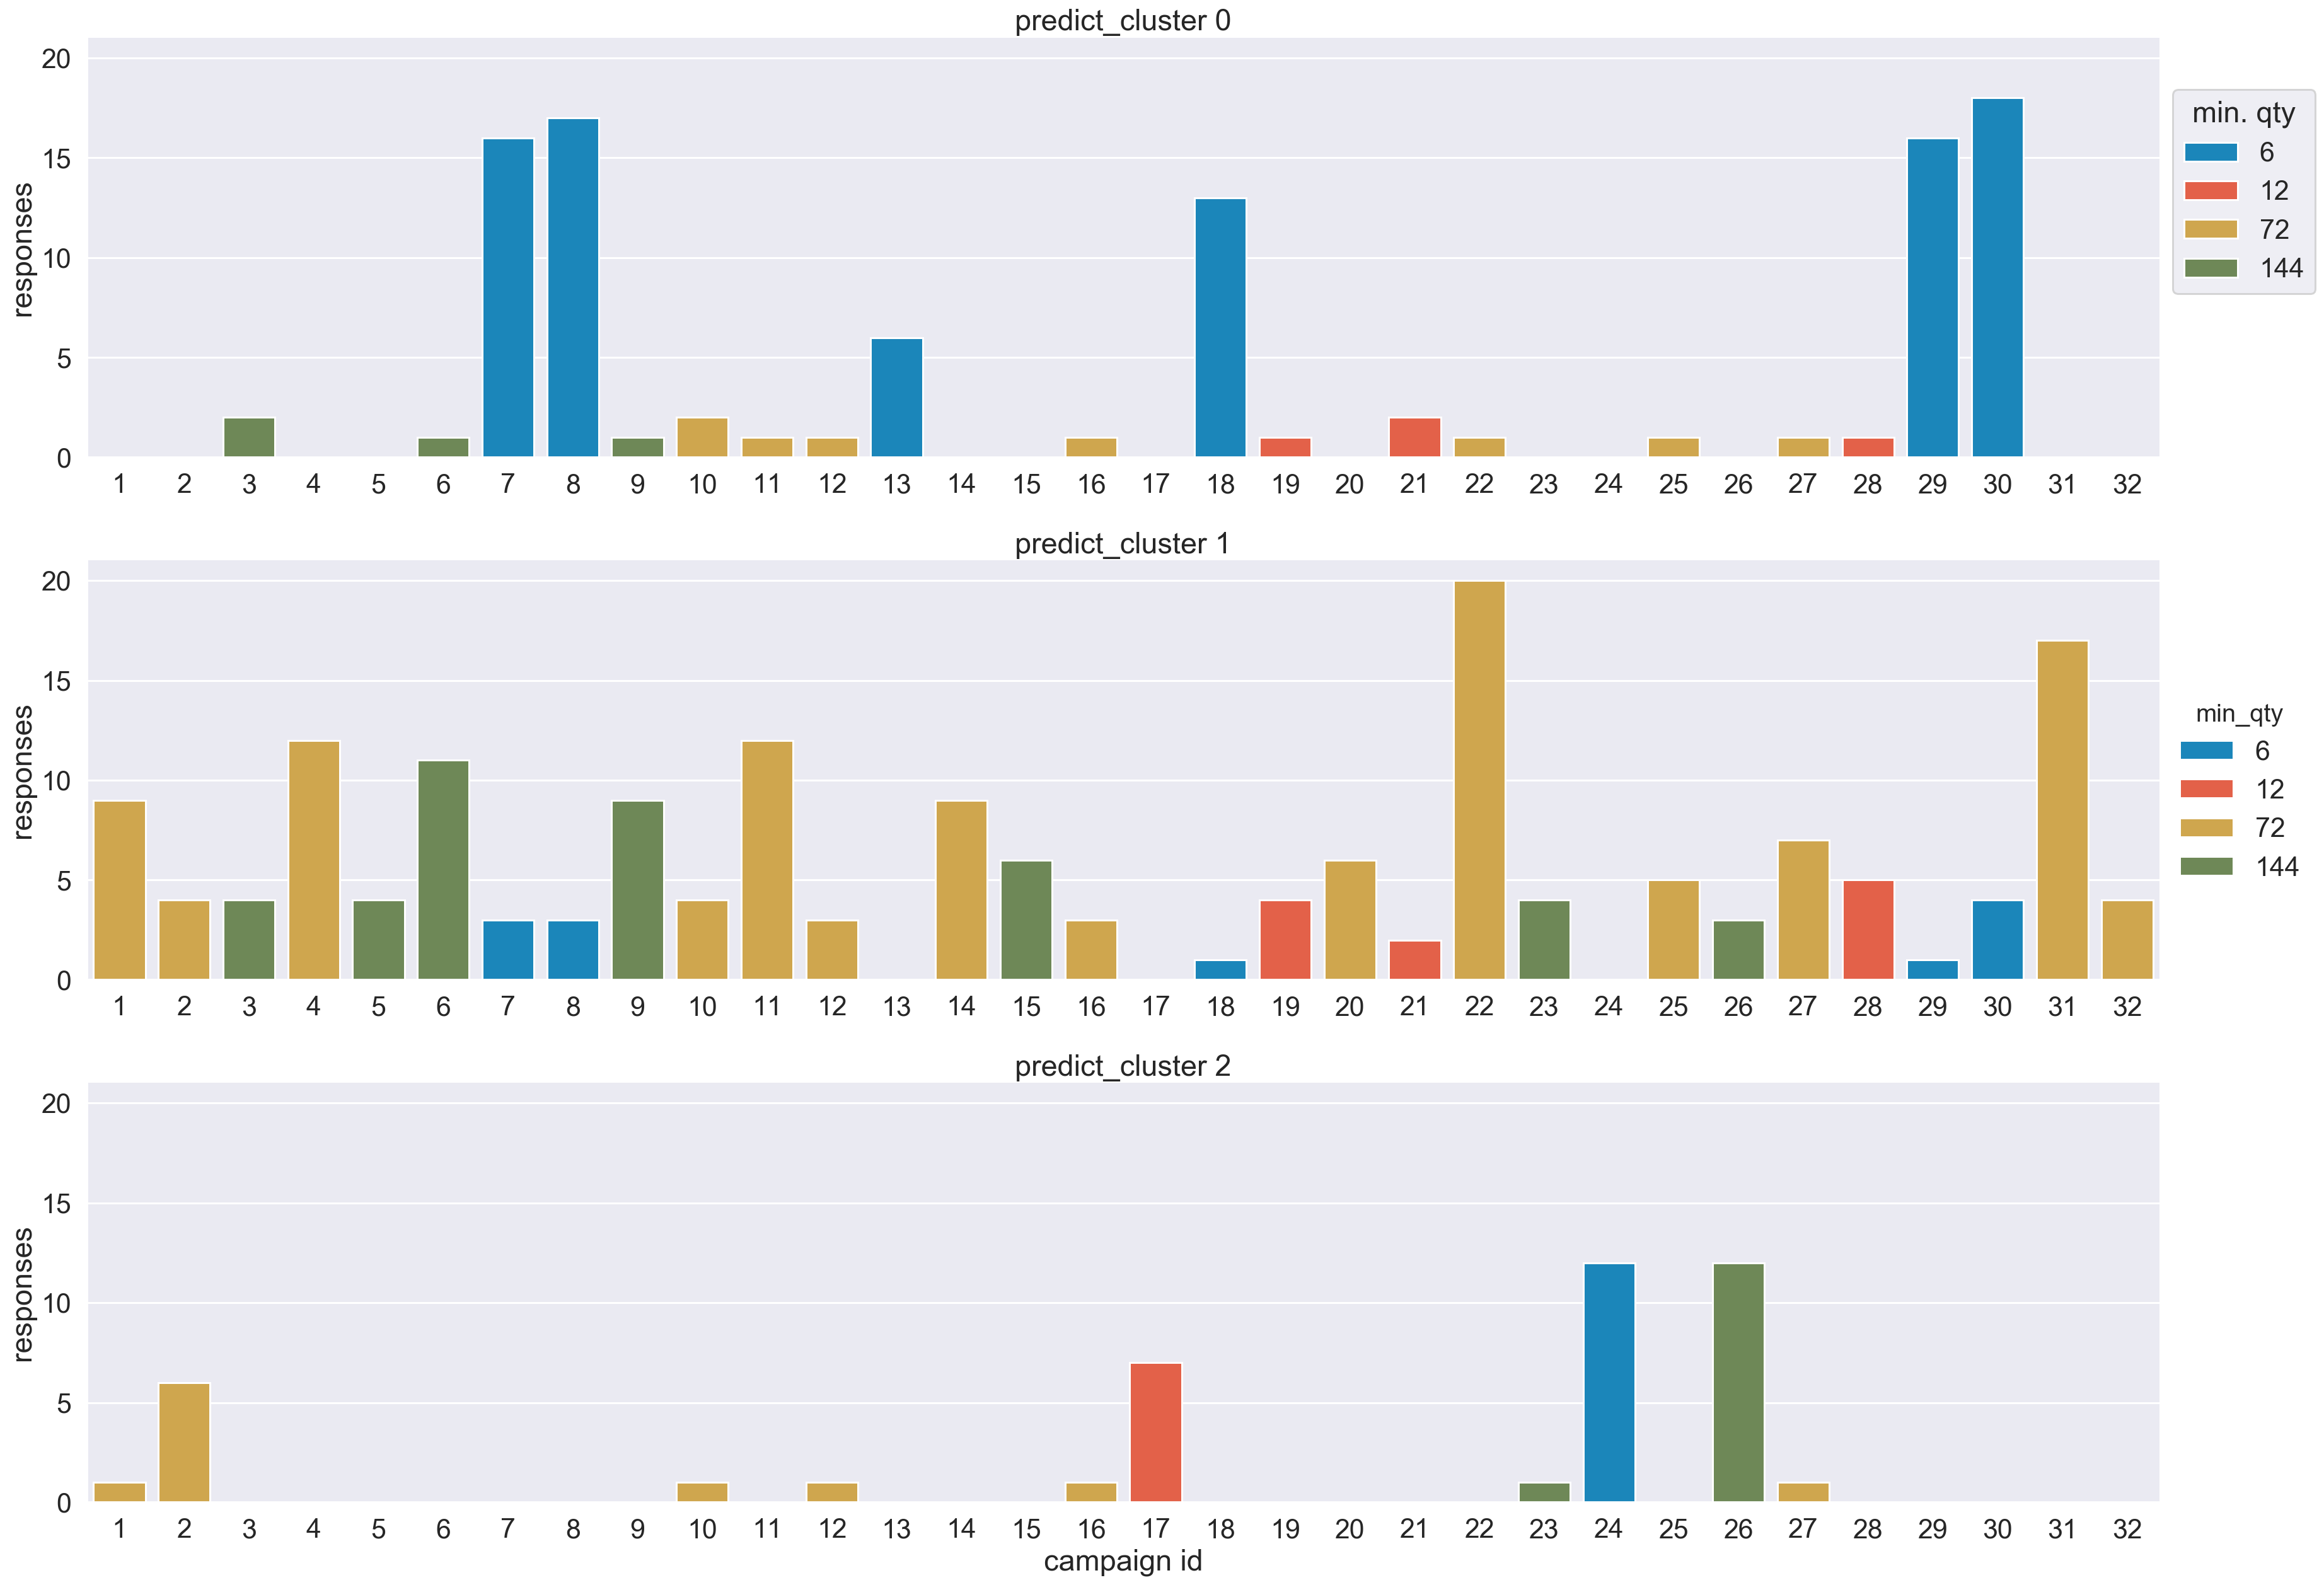

In [33]:
_=plt.rcParams['figure.figsize'] = [12,4]
_=sns.set_style("darkgrid")
_=sns.catplot(x="offer_id", hue="min_qty", col="predict_cluster",
              data=customer_segmentation, kind="count",height=6, aspect=4, col_wrap=1, sharex=False, dodge = False)
_=_.set_titles("{col_var} {col_name}")
_=_.set_axis_labels("campaign id", "responses")
_=plt.legend(bbox_to_anchor=(1, 3.4), loc=0, title= 'min. qty')

<p>The previous plots show that customers in cluster 1 prefer high volume offers, with campaign number 22 being the most popular one, which had a minimum quantity of 72. This is the most profitable cluster and one reason they prefer bulk-packaged offers could be that this cluster includes small businesses, making this the most profitable cluster.</p> 
<p>Cluster 0, on the other hand, responded almost exclusively to minimum quantity campaigns and the customers in cluster 2 did not respond to many campaigns, but they did respond well to campaign number 26, which had a minimum quantity of 144. </p>

<a id='cluster1'></a>

## Cluster 1

In [34]:
k1 = customer_segmentation.loc[customer_segmentation.predict_cluster==1]

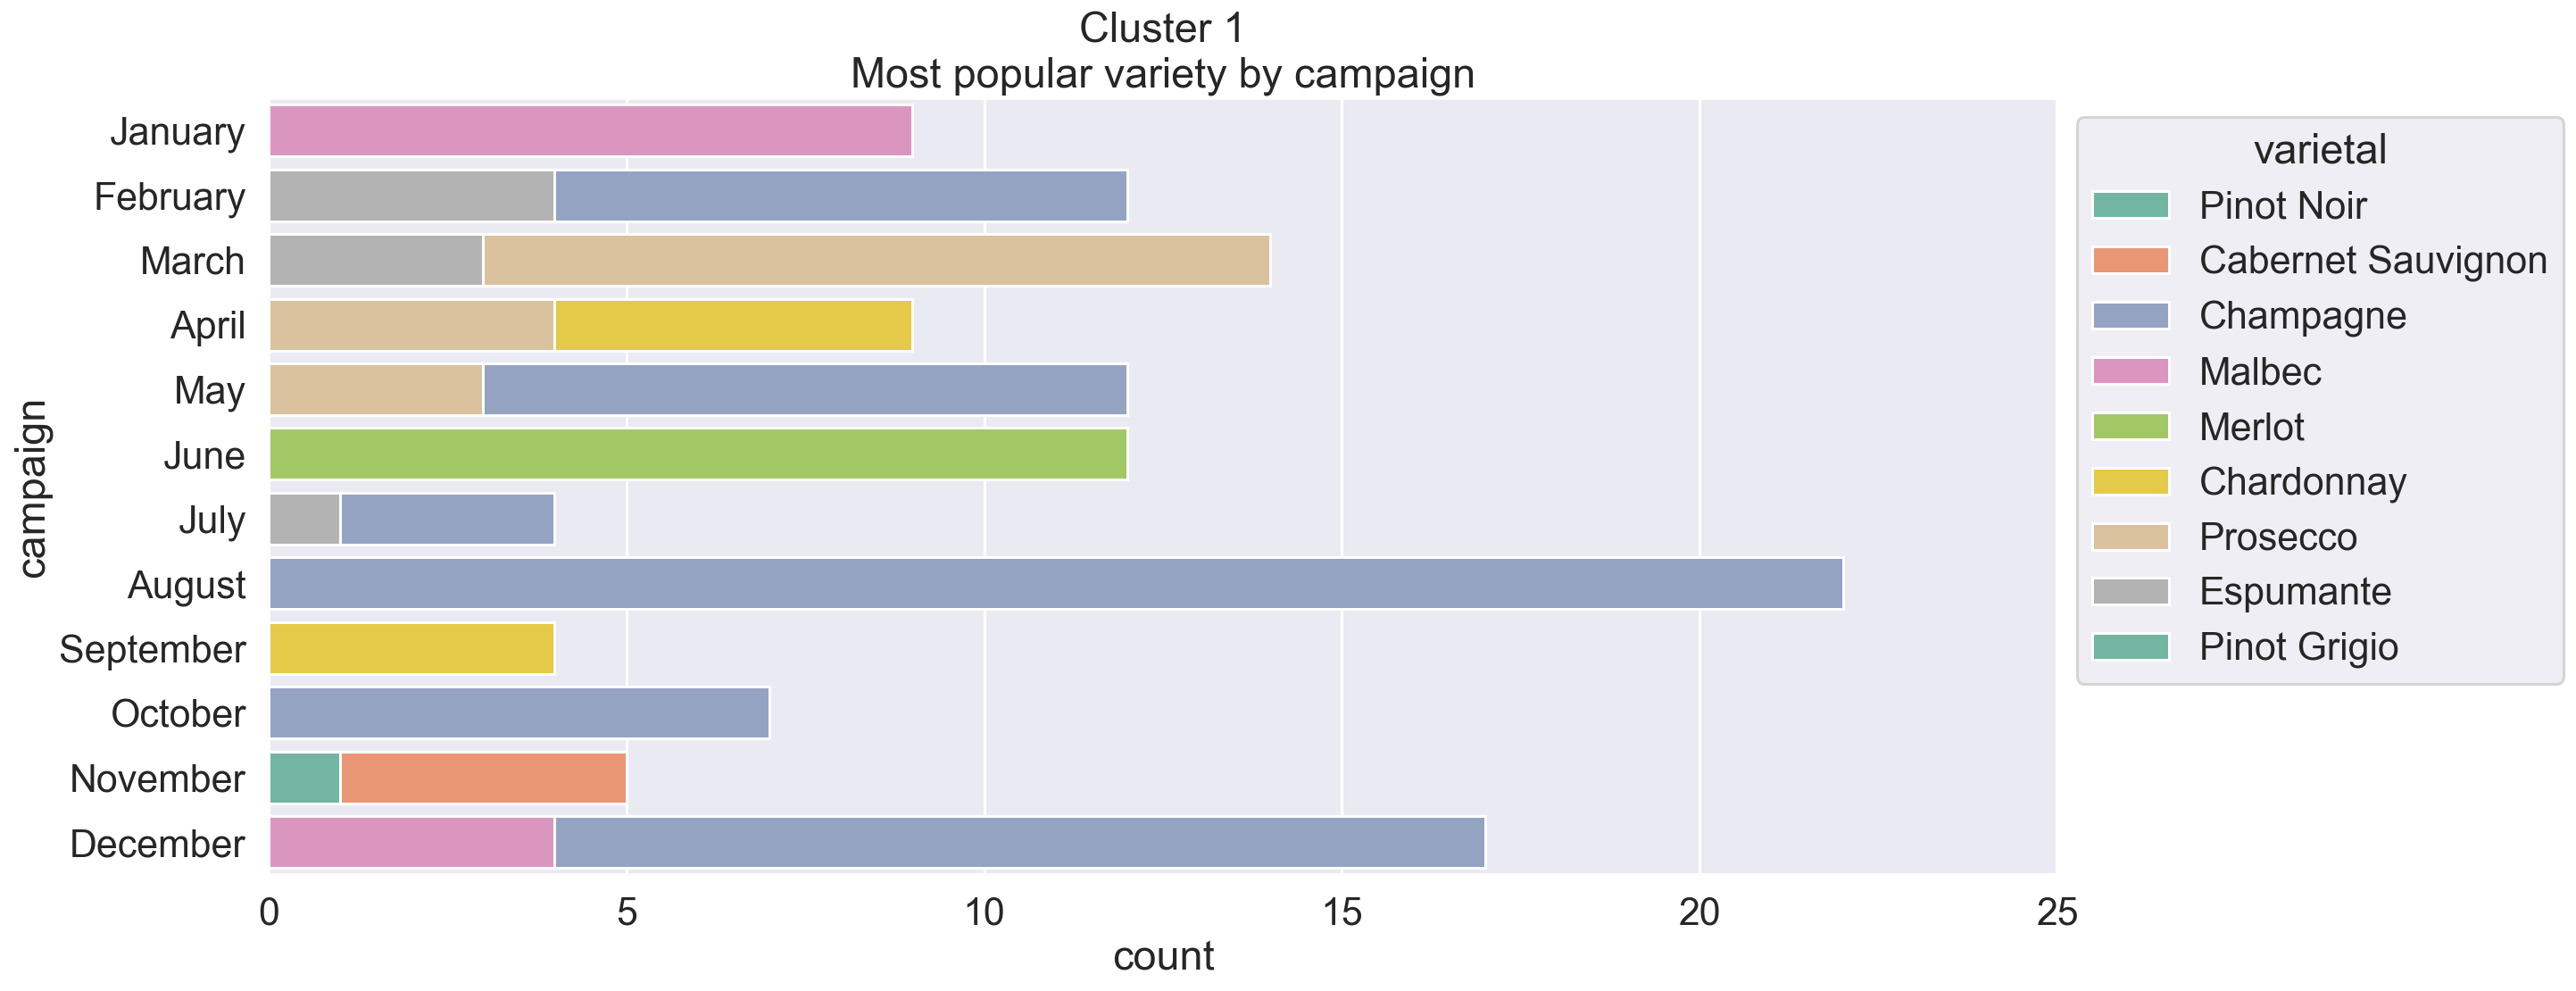

In [35]:
_=plt.rcParams['figure.figsize'] = [16,8]
_=sns.countplot(y='campaign', hue= 'varietal',data = k1, dodge=False, order=months, palette='Set2')
_=plt.legend(bbox_to_anchor=(1, 1), loc=2, title= 'varietal')
_=plt.title('Cluster 1\nMost popular variety by campaign')
_=plt.xlim(0,25)
_=plt.xlabel('count')

Looking exclusively at cluster 1, we can see that the August campaign was the most popular offer for the Champagne variety. In December, this cluster responded to both the Champagne and the Malbec offers and January was exclusive for the Malbec offer.

#### Discounts

The previous graphs have shown that cluster one may be the most profitable cluster, with customers responding almost entirely to the high volume campaigns. However, how many of these campaigns also offer high discounts? 

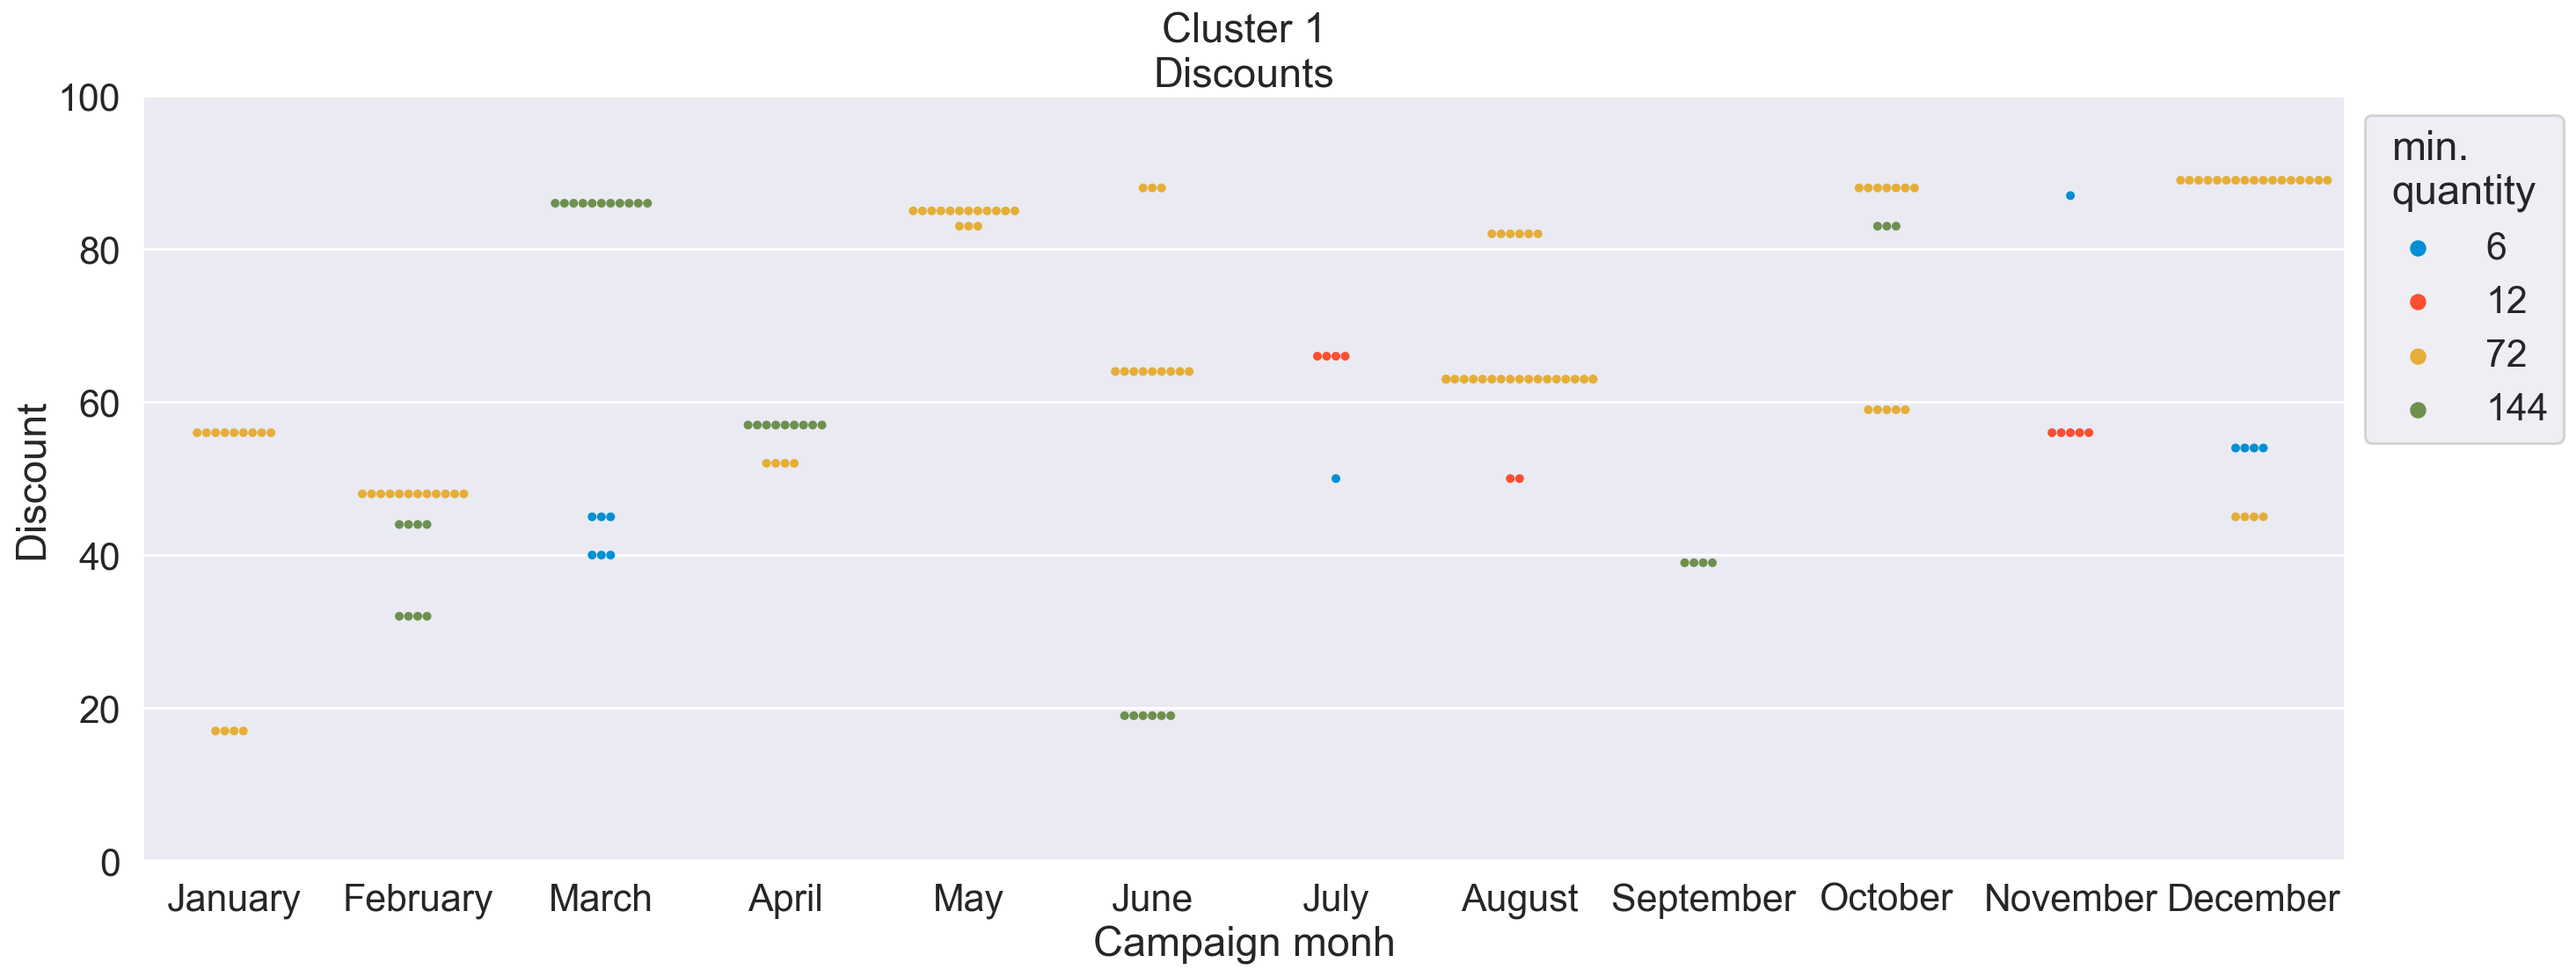

In [36]:
_=sns.set_style("darkgrid")
_=plt.rcParams['figure.figsize'] = [20,8]
_=sns.swarmplot(y='discount', hue='min_qty',x='campaign',data = k1, order=months)
_=plt.xlabel('Campaign monh')
_=plt.ylabel('Discount')
_=plt.title('Cluster 1\nDiscounts')
_=plt.legend(bbox_to_anchor=(1, 1), loc=2, title= 'min.\nquantity')
_=plt.ylim(0,100)

75% of the offers customers in cluster 1 responded to had a at least a 50% discount, with 9% of all orders getting 89% discount. Hence, even thought these customers responded to the majority of offers, they also enjoyed great discounts.

<a id='kmc'></a>

## K-Means clustering results
The k-means clustering algorithm was able to segment the marketing campaign responses into three groups, with cluster 1 being the most engaged and profitable cluster. The March campaign received the largest number of responses and the most popular varietal among all clusters is Champagne.

<a id='pcaoptimal'></a>

***

## PCA 'optimal' dimensions
<p>A new PCA object was run again, but this time without setting the number of components to find the 'optimal' number of of dimensions.</p>

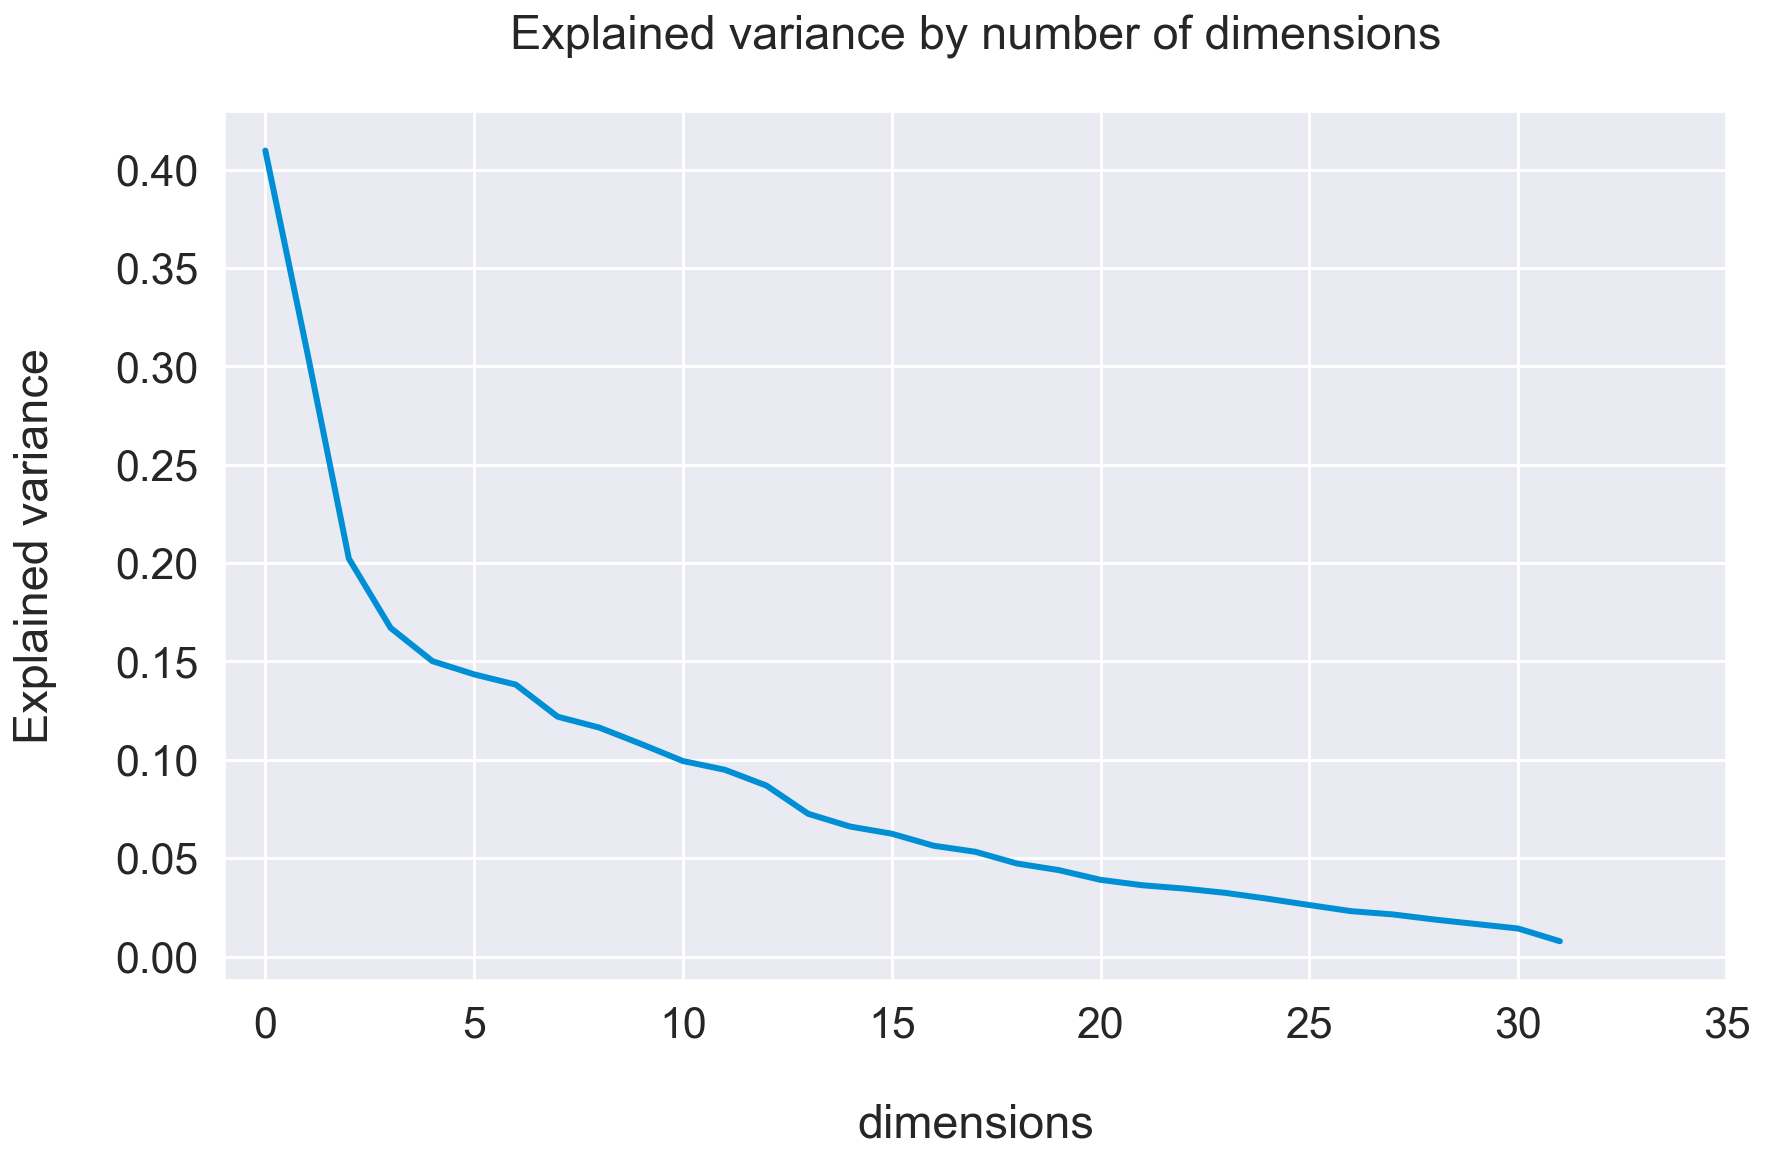

In [37]:

_=plt.rcParams['figure.figsize'] = [12,8]
_=sns.set_context("talk", font_scale=1.3, rc={"lines.linewidth": 3}, )

np.random.seed(88)
# Initialize a new PCA model with a default number of components.
#import sklearn.decomposition
pca = sklearn.decomposition.PCA(random_state=2)
_=pca.fit(x_cols)
_=plt.plot(pca.explained_variance_)
_=plt.title('Explained variance by number of dimensions\n')
_=plt.xlabel('\ndimensions')
_=plt.ylabel('Explained variance\n')
_=plt.xlim(-1,35)

The plot above shows the `explained_variance_` by number of dimensions. Two, where the curve's rate of descent seems to slow sharply, is the 'optimal' value of dimensions.

<a id='oca'></a>

*** 
## Other Clustering Algorithms

The following section provides is a brief description of several clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

## Clustering Algorithms in Scikit-learn
![other_clustering_algorithms](image/clustering_algorithms.png)

# Comparing other algorithms

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>

In [38]:
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn import metrics

In [39]:
algorithms = ['Affinity propagation','Spectral clustering','Agglomerative clustering','DBSCAN']
avg_scores_all = []
n_clusters = []

<a id='afp'></a>

## Affinity propagation

In [40]:
np.random.seed(44)
ap = AffinityPropagation()
labels=ap.fit_predict(x_cols)
cluster_centers = ap.cluster_centers_indices_
n_clusters_ap = len(cluster_centers)
avg_score_ap = metrics.silhouette_score(x_cols, labels)
avg_scores_all.append(avg_score_ap)
n_clusters.append(n_clusters_ap)

In [41]:
print('Estimated number of clusters: %d'%(n_clusters_ap))
print("Average silhouette score: %0.3f"
      %(avg_score_ap))

Estimated number of clusters: 14
Average silhouette score: 0.123


<a id='sc'></a>

## Spectral clustering

In [42]:
np.random.seed(44)
sc = SpectralClustering()
labels_sc = sc.fit_predict(x_cols)
n_clusters_sc = len(set(labels_sc))
avg_score_sc = metrics.silhouette_score(x_cols, labels_sc)
avg_scores_all.append(avg_score_sc)
n_clusters.append(n_clusters_sc)

In [43]:
print('Estimated number of clusters: %d'%(n_clusters_sc))
print("Average silhouette score: %0.3f"
      %(avg_score_sc))

Estimated number of clusters: 8
Average silhouette score: 0.096


<a id='aclustering'></a>

## Agglomerative clustering

In [44]:
np.random.seed(44)
ac = AgglomerativeClustering()
labels_ac = ac.fit_predict(x_cols)
n_clusters_ac= len(set(labels_ac))
avg_score_ac = metrics.silhouette_score(x_cols, labels_ac)
avg_scores_all.append(avg_score_ac)
n_clusters.append(n_clusters_ac)

In [45]:
print('Estimated number of clusters: %d'%(n_clusters_ac))
print("Average silhouette score: %0.3f"
      %(avg_score_ac))

Estimated number of clusters: 2
Average silhouette score: 0.083


<a id='db'></a>

## DBSCAN

In [46]:
np.random.seed(44)
dbscan = DBSCAN(min_samples=3)
labels_db = dbscan.fit_predict(x_cols)
n_clusters_db = len(set(labels_db[labels_db>=0]))
avg_score_db = metrics.silhouette_score(x_cols, labels_db)
avg_scores_all.append(avg_score_db)
n_clusters.append(n_clusters_db)

In [47]:
print('Estimated number of clusters: %d'%(n_clusters_db))
print("Average silhouette score: %0.3f"
      %(avg_score_db))

Estimated number of clusters: 3
Average silhouette score: -0.107


## Comparison

In [48]:
results = pd.DataFrame(list(zip(algorithms, avg_scores_all, n_clusters)), columns=['Algorithms', 'Avg. silhouette score', 'n_clusters'])
results

,Algorithms,Avg. silhouette score,n_clusters
0,Affinity propagation,0.123465,14
1,Spectral clustering,0.095662,8
2,Agglomerative clustering,0.082580,2
3,DBSCAN,-0.106636,3


None of the algorithms perform better than k-means clustering, with all the average silhouette scores below 0.2, which means that none of them found a substantial structure. The affinity propagation algorithm found 14 clusters, which seems to large considering there are only 100 records. The DBSCAN had a negative score indicating samples were misclassified.

<a id='conclusion'></a>

# Conclusions

<p>The previous analysis used several clustering algorithms to find similarities among wine marketing campaigns to form groups of customers. The k-means clustering was the best performer segmenting the data into three distinct clusters, which identified cluster 1 as the most engaged group with the highest number of responses to campaigns with minimum quantities of 72. Cluster 1 was also identified as favoring Champagne The clustering also identified the March, August and December campaigns as the most popular ones, with cluster 1 being the only one who responded to the August and December campaigns. Customers in cluster 2 tend to prefer sparkling ones, responding equally to the Espumante and Prosecco offers and almost exclusevely to the Pinot Grigio offer.</p>
<p>These results can be used by the marketing department to send offers of a specific wine to a single group based on their clusters. For instance, Pinot Grigio offers should not be sent to cluster 0, since they did not reply to this campaign in the past.</p>

[Top](#top)

                                                                                                                                                           March 2019